# NEW workflow -> ifcb-analysis + PlanktoNET analysis

## 1. Create 1_ifcb-analysis_feature_output.db

In [2]:
import os
import sqlite3
import pandas as pd
from glob import glob

# === Define paths ===
data_dir = "02_metadata/Ishigaki2023/feature_output"
metadata_path = "02_metadata/Ishigaki2023/IFCB_info.csv"
db_path = "03_datasets/Ishigaki2023/1_ifcb-analysis_feature_output.db"

# === Load and prepare metadata ===
metadata_df = pd.read_csv(metadata_path)

# Rename 'folder' to match IFCB output format
metadata_df.rename(columns={'folder': 'folder_id'}, inplace=True)

# Clean folder_id to match feature file naming
metadata_df['folder_id'] = metadata_df['folder_id'].str.replace('_IFCB108', '', regex=False)

# Debug
print("Columns in metadata:", metadata_df.columns.tolist())

# === Connect to SQLite and reset table ===
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS ifcb_features")
conn.commit()

# === Process each feature file ===
csv_files = glob(os.path.join(data_dir, "*.csv"))
exclude_prefixes = ["Wedge", "Ring", "HOG"]

for file_path in csv_files:
    original_file_name = os.path.basename(file_path)
    file_name = original_file_name.replace("_fea_v2.csv", "")  # e.g., D20240831T061553_IFCB108
    folder_id = file_name.replace("_IFCB108", "")  # For matching with metadata

    # Load features
    df = pd.read_csv(file_path)

    # Drop high-dimensional columns
    cols_to_drop = [col for col in df.columns if any(col.startswith(p) for p in exclude_prefixes)]
    df.drop(columns=cols_to_drop, inplace=True)

    # Use summed values if numBlobs > 1
    for col in ["Area", "Biovolume", "ConvexArea", "ConvexPerimeter", "FeretDiameter",
                "MajorAxisLength", "MinorAxisLength", "Perimeter"]:
        summed_col = f"summed{col}"
        if summed_col in df.columns and "numBlobs" in df.columns:
            df[col] = df.apply(
                lambda row: row[summed_col] if row["numBlobs"] > 1 else row[col],
                axis=1
            )

    # Add identifiers
    df["roi_number"] = df["roi_number"].astype(int)
    df["roi_number_str"] = df["roi_number"].apply(lambda x: f"{x:05d}")
    df["file_name_w_roi"] = file_name + "_" + df["roi_number_str"]
    df["file_name"] = file_name
    df.drop(columns=["roi_number_str"], inplace=True)
    df["folder_id"] = folder_id

    # Merge with metadata
    merged = df.merge(metadata_df, on="folder_id", how="left")

    # Reorder columns
    reordered = ["file_name", "file_name_w_roi", "folder_id", "roi_number"] + \
        [col for col in merged.columns if col not in ["file_name", "file_name_w_roi", "folder_id", "roi_number"]]
    merged = merged[reordered]

    # Save to SQLite
    merged.to_sql("ifcb_features", conn, if_exists="append", index=False)

conn.close()
print("Optimized IFCB feature database saved as 1_ifcb-analysis_feature_output.db with metadata included.")

Columns in metadata: ['IFCB', 'date', 'time', 'folder_id', 'year', 'day', 'treatment', 'replicate']
Optimized IFCB feature database saved as 1_ifcb-analysis_feature_output.db with metadata included.


In [2]:
# Confirm columns 

In [3]:
import sqlite3

# Path to your database
db_path = "03_datasets/Ishigaki2023/1_ifcb-analysis_feature_output.db"
table_name = "ifcb_features"

# Connect to the database
conn = sqlite3.connect(db_path)

# Query column info
cursor = conn.execute(f"PRAGMA table_info({table_name});")
columns = [row[1] for row in cursor.fetchall()]

conn.close()

# Print or export the list
print("Columns:", columns)

Columns: ['file_name', 'file_name_w_roi', 'folder_id', 'roi_number', 'Area', 'Biovolume', 'BoundingBox_xwidth', 'BoundingBox_ywidth', 'ConvexArea', 'ConvexPerimeter', 'Eccentricity', 'EquivDiameter', 'Extent', 'FeretDiameter', 'H180', 'H90', 'Hflip', 'MajorAxisLength', 'MinorAxisLength', 'Orientation', 'Perimeter', 'RWcenter2total_powerratio', 'RWhalfpowerintegral', 'Solidity', 'moment_invariant1', 'moment_invariant2', 'moment_invariant3', 'moment_invariant4', 'moment_invariant5', 'moment_invariant6', 'moment_invariant7', 'numBlobs', 'shapehist_kurtosis_normEqD', 'shapehist_mean_normEqD', 'shapehist_median_normEqD', 'shapehist_mode_normEqD', 'shapehist_skewness_normEqD', 'summedArea', 'summedBiovolume', 'summedConvexArea', 'summedConvexPerimeter', 'summedFeretDiameter', 'summedMajorAxisLength', 'summedMinorAxisLength', 'summedPerimeter', 'texture_average_contrast', 'texture_average_gray_level', 'texture_entropy', 'texture_smoothness', 'texture_third_moment', 'texture_uniformity', 'Rota

In [4]:
# Export first two rows as csv
# Actually, not necessary. Just QC. Can delete.

In [5]:
import sqlite3
import pandas as pd

# Path to your database and desired table
db_path = "03_datasets/Ishigaki2023/1_ifcb-analysis_feature_output.db"
table_name = "ifcb_features"
output_csv = "03_datasets/Ishigaki2023/feature_output.csv"

# Connect to the database and read first 2 rows
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 2;", conn)
conn.close()

# Export to CSV
df.to_csv(output_csv, index=False)
print(f"First 2 rows exported to: {output_csv}")

First 2 rows exported to: 03_datasets/Ishigaki2023/feature_output.csv


## 2. Create 2_PlanktoNET_classification.db

In [6]:
import os
import pandas as pd
import re
import sqlite3

# === CONFIGURATION ===
# Root directory of classified PlanktoNET results (149 measurement folders)
planktonet_root = "/Users/jorge/myPlanktoNET/6_FINAL_results"

# Path to taxonomic metadata file
taxonomic_info_path = "02_metadata/Ishigaki2023/taxonomic_info.csv"

# Output SQLite database path
output_db_path = "03_datasets/Ishigaki2023/2_PlanktoNET_classification.db"

# === STEP 1: Load taxonomic info ===
taxonomic_df = pd.read_csv(taxonomic_info_path)

# === STEP 2: Walk through all folders and extract classification info ===
records = []

for folder_name in os.listdir(planktonet_root):
    folder_path = os.path.join(planktonet_root, folder_name)
    if not os.path.isdir(folder_path):
        continue

    folder_id = folder_name  # e.g., D20240830T054430_IFCB108

    for confidence in ['high_confidence', 'low_confidence']:
        conf_path = os.path.join(folder_path, confidence)
        if not os.path.isdir(conf_path):
            continue

        for class_name in os.listdir(conf_path):
            class_path = os.path.join(conf_path, class_name)
            if not os.path.isdir(class_path):
                continue

            for fname in os.listdir(class_path):
                if fname.endswith('.png'):
                    # Example: D20240830T054430_IFCB108_01880_0.7938.png
                    match = re.match(r'.*_(\d+)_([0-9.]+)\.png', fname)
                    if match:
                        roi = int(match.group(1))
                        probability = float(match.group(2))

                        records.append({
                            'folder_id': folder_id,
                            'ROI': roi,
                            'probability': probability,
                            'confidence': confidence,
                            'class_name': class_name
                        })

# === STEP 3: Convert to DataFrame and merge with taxonomy ===
classification_df = pd.DataFrame(records)
classification_merged = classification_df.merge(taxonomic_df, on="class_name", how="left")

# === STEP 4: Save to SQLite database ===
conn = sqlite3.connect(output_db_path)
classification_merged.to_sql('planktonet_classification', conn, if_exists='replace', index=False)
conn.close()

print(f"Classification database created with {len(classification_merged)} entries:")
print(f"→ {output_db_path}")

Classification database created with 481808 entries:
→ 03_datasets/Ishigaki2023/2_PlanktoNET_classification.db


In [8]:
# Confirm columns

In [7]:
import sqlite3

# Path to your database
db_path = "03_datasets/Ishigaki2023/2_PlanktoNET_classification.db"
table_name = "planktonet_classification"

# Connect to the database
conn = sqlite3.connect(db_path)

# Query column info
cursor = conn.execute(f"PRAGMA table_info({table_name});")
columns = [row[1] for row in cursor.fetchall()]

conn.close()

# Print or export the list
print("Columns:", columns)

Columns: ['folder_id', 'ROI', 'probability', 'confidence', 'class_name', 'organism_type', 'feeding_mode', 'toxins', 'phylum', 'class', 'order', 'family', 'genus', 'taxon_name', 'category']


In [10]:
# Export first 2 rows as csv

In [10]:
import sqlite3
import pandas as pd

# Path to your database and desired table
db_path = "03_datasets/Ishigaki2023/2_PlanktoNET_classification.db"
table_name = "planktonet_classification"
output_csv = "03_datasets/Ishigaki2023/classification.csv"

# Connect to the database and read first 2 rows
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 2;", conn)
conn.close()

# Export to CSV
df.to_csv(output_csv, index=False)
print(f"First 2 rows exported to: {output_csv}")

First 2 rows exported to: 03_datasets/Ishigaki2023/classification.csv


## 3. Merging both databases in '3_merged_ifcb_data.db'

In [11]:
import sqlite3
import pandas as pd

# === Paths ===
features_db = "03_datasets/Ishigaki2023/1_ifcb-analysis_feature_output.db"
classification_db = "03_datasets/Ishigaki2023/2_PlanktoNET_classification.db"
output_db = "03_datasets/Ishigaki2023/3_merged_ifcb_data.db"

# === Load IFCB features ===
conn_feat = sqlite3.connect(features_db)
features_df = pd.read_sql("SELECT * FROM ifcb_features;", conn_feat)
conn_feat.close()

# Ensure correct types
features_df['folder_id'] = features_df['folder_id'].astype(str)
features_df['ROI'] = features_df['roi_number'].astype(int)

# === Load classification data ===
conn_class = sqlite3.connect(classification_db)
class_df = pd.read_sql("SELECT * FROM planktonet_classification;", conn_class)
conn_class.close()

# Fix mismatch in folder_id by removing '_IFCB108'
class_df['folder_id'] = class_df['folder_id'].str.replace('_IFCB108', '', regex=False)

# === Merge datasets ===
merged_df = features_df.merge(
    class_df,
    how='left',
    on=['folder_id', 'ROI']
)

# === Save merged data ===
conn_out = sqlite3.connect(output_db)
merged_df.to_sql('ifcb_with_classification', conn_out, if_exists='replace', index=False)
conn_out.close()

# Check results
print(f"Merged dataset saved to: {output_db}")
print(f"Total merged rows: {len(merged_df)}")
print("Classification data available for rows:", merged_df['class_name'].notna().sum())

Merged dataset saved to: 03_datasets/Ishigaki2023/3_merged_ifcb_data.db
Total merged rows: 481808
Classification data available for rows: 481808


In [14]:
# Confirm columns 

In [12]:
import sqlite3

# Path to your database
db_path = "03_datasets/Ishigaki2023/3_merged_ifcb_data.db"
table_name = "ifcb_with_classification"

# Connect to the database
conn = sqlite3.connect(db_path)

# Query column info
cursor = conn.execute(f"PRAGMA table_info({table_name});")
columns = [row[1] for row in cursor.fetchall()]

conn.close()

# Print or export the list
print("Columns:", columns)

Columns: ['file_name', 'file_name_w_roi', 'folder_id', 'roi_number', 'Area', 'Biovolume', 'BoundingBox_xwidth', 'BoundingBox_ywidth', 'ConvexArea', 'ConvexPerimeter', 'Eccentricity', 'EquivDiameter', 'Extent', 'FeretDiameter', 'H180', 'H90', 'Hflip', 'MajorAxisLength', 'MinorAxisLength', 'Orientation', 'Perimeter', 'RWcenter2total_powerratio', 'RWhalfpowerintegral', 'Solidity', 'moment_invariant1', 'moment_invariant2', 'moment_invariant3', 'moment_invariant4', 'moment_invariant5', 'moment_invariant6', 'moment_invariant7', 'numBlobs', 'shapehist_kurtosis_normEqD', 'shapehist_mean_normEqD', 'shapehist_median_normEqD', 'shapehist_mode_normEqD', 'shapehist_skewness_normEqD', 'summedArea', 'summedBiovolume', 'summedConvexArea', 'summedConvexPerimeter', 'summedFeretDiameter', 'summedMajorAxisLength', 'summedMinorAxisLength', 'summedPerimeter', 'texture_average_contrast', 'texture_average_gray_level', 'texture_entropy', 'texture_smoothness', 'texture_third_moment', 'texture_uniformity', 'Rota

In [23]:
# Export first 2 rows as csv

In [13]:
import sqlite3
import pandas as pd

# Path to your database and desired table
db_path = "03_datasets/Ishigaki2023/3_merged_ifcb_data.db"
table_name = "ifcb_with_classification"
output_csv = "03_datasets/Ishigaki2023/merged.csv"

# Connect to the database and read first 2 rows
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 2;", conn)
conn.close()

# Export to CSV
df.to_csv(output_csv, index=False)
print(f"First 2 rows exported to: {output_csv}")

First 2 rows exported to: 03_datasets/Ishigaki2023/merged.csv


## Appendix (filtering by confidence)

### Filter only high confidence ones (Higher than 70%)

In [14]:
import sqlite3
import pandas as pd
import os

# === Input & output paths ===
base_dir = "/Users/jorge/Documents/GitHub/PlanktoQNT"
input_db = os.path.join(base_dir, "03_datasets/Ishigaki2023/3_merged_ifcb_data.db")
output_dir = os.path.join(base_dir, "03_datasets/Ishigaki2023")
output_db = os.path.join(output_dir, "high_confidence_classification.db")

# === Ensure output folder exists ===
os.makedirs(output_dir, exist_ok=True)

# === Load merged data ===
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_with_classification;", conn)
conn.close()

# === Filter only high-confidence classifications ===
filtered_df = df[df['confidence'] == 'high_confidence'].copy()

# === Save to new SQLite DB ===
conn_out = sqlite3.connect(output_db)
filtered_df.to_sql("ifcb_high_confidence", conn_out, if_exists="replace", index=False)
conn_out.close()

print(f"High-confidence classification saved to:")
print(f"→ {output_db}")
print(f"Total rows: {len(filtered_df)}")

High-confidence classification saved to:
→ /Users/jorge/Documents/GitHub/PlanktoQNT/03_datasets/Ishigaki2023/high_confidence_classification.db
Total rows: 208386


### Filter only low-confidence ones (Lower than 70%)

In [15]:
import sqlite3
import pandas as pd
import os

# === Input & output paths ===
base_dir = "/Users/jorge/Documents/GitHub/PlanktoQNT"
input_db = os.path.join(base_dir, "03_datasets/Ishigaki2023/3_merged_ifcb_data.db")
output_dir = os.path.join(base_dir, "03_datasets/Ishigaki2023")
output_db = os.path.join(output_dir, "low_confidence_classification.db")

# === Ensure output folder exists ===
os.makedirs(output_dir, exist_ok=True)

# === Load merged data ===
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_with_classification;", conn)
conn.close()

# === Filter only low-confidence classifications ===
filtered_df = df[df['confidence'] == 'low_confidence'].copy()

# === Save to new SQLite DB ===
conn_out = sqlite3.connect(output_db)
filtered_df.to_sql("ifcb_low_confidence", conn_out, if_exists="replace", index=False)
conn_out.close()

print(f"low-confidence classification saved to:")
print(f"→ {output_db}")
print(f"Total rows: {len(filtered_df)}")

low-confidence classification saved to:
→ /Users/jorge/Documents/GitHub/PlanktoQNT/03_datasets/Ishigaki2023/low_confidence_classification.db
Total rows: 273422


## 4. C biomass calculation per particle (pgC/Cell)

In [1]:
import sqlite3
import pandas as pd
import numpy as np

# === Paths ===
input_db = "03_datasets/Ishigaki2023/3_merged_ifcb_data.db"
output_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
metadata_csv = "02_metadata/Ishigaki2023/IFCB_info.csv"

# === Load IFCB merged data ===
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_with_classification;", conn)
conn.close()

# === Compute volume (pixels³ → µm³) ===
PIXEL_TO_UM3 = 0.422
df["volume_um3"] = df["summedBiovolume"] * PIXEL_TO_UM3

# === Define C biomass formula ===
def assign_carbon(row):
    V = row['volume_um3']
    category = row['category']
    
    if pd.isna(V) or V <= 0 or pd.isna(category):
        return pd.Series({'carbon_formula': None, 'carbon_pgC': None})
    
    if category == "Diatoms":
        pgC = 0.288 * (V ** 0.811)
        formula = "Menden-Deuer 2000: Diatom"
    elif category == "Dinoflagellates":
        pgC = 0.760 * (V ** 0.819)
        formula = "Menden-Deuer 2000: Dino"
    elif category == "Ciliates":
        pgC = 0.216 * (V ** 0.939)
        formula = "Putt & Stoecker 1989: Ciliate"
    elif category == "Detritus":
        pgC = 0.22 * V
        formula = "Parsons et al. 1984 (Detritus)"
    else:
        pgC = 0.216 * (V ** 0.939)
        formula = "Putt & Stoecker 1989: Other Protists"
    
    return pd.Series({'carbon_formula': formula, 'carbon_pgC': pgC})

# === Apply formulas ===
df[['carbon_formula', 'carbon_pgC']] = df.apply(assign_carbon, axis=1)

# === Re-merge clean metadata to fix duplicated columns ===
meta = pd.read_csv(metadata_csv)

# Ensure correct column naming
meta.rename(columns={'folder': 'folder_id'}, inplace=True)
meta['folder_id'] = meta['folder_id'].str.replace('_IFCB108', '', regex=False)

# Drop existing 'treatment' and 'replicate' columns if they already exist
df.drop(columns=['treatment', 'replicate'], errors='ignore', inplace=True)

# Merge metadata cleanly (no duplicates)
df = df.merge(meta[['folder_id', 'treatment', 'replicate']], on='folder_id', how='left')

# === Save final result ===
conn_out = sqlite3.connect(output_db)
df.to_sql("ifcb_biomass_per_particle", conn_out, if_exists="replace", index=False)
conn_out.close()

# Confirmation
print(f"Final carbon biomass table with corrected metadata saved to: {output_db}")
print(f"Total rows: {len(df)}")

Final carbon biomass table with corrected metadata saved to: 03_datasets/Ishigaki2023/4_carbon_biomass.db
Total rows: 481808


In [2]:
# exporting the first rows

import sqlite3
import pandas as pd

# Path to your database and desired table
db_path = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
table_name = "ifcb_biomass_per_particle"
output_csv = "03_datasets/Ishigaki2023/carbon.csv"

# Connect to the database and read first 2 rows
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 2;", conn)
conn.close()

# Export to CSV
df.to_csv(output_csv, index=False)
print(f"First 2 rows exported to: {output_csv}")

First 2 rows exported to: 03_datasets/Ishigaki2023/carbon.csv


## 5. C_biomass calculation (µgC/L) per replicate

### 5A_C_biomass_per_replicate.db. Uses numBlobs to count particles per ROI (abundance). Converts pgC → µgC. Normalizes per 5 mL replicate (volume = 0.005 L)

In [3]:
import sqlite3
import pandas as pd

# === Paths ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
output_db = "03_datasets/Ishigaki2023/5A_C_biomass_per_replicate.db"

# === Load particle-level data ===
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Drop rows without carbon values or metadata ===
df = df.dropna(subset=["carbon_pgC", "year", "day", "treatment", "replicate", "taxon_name"])

# Convert pgC → µgC
df["carbon_ugC"] = df["carbon_pgC"] / 1e6

# Default numBlobs to 1 if missing
df["numBlobs"] = df["numBlobs"].fillna(1)
df["particles"] = df["numBlobs"]

# === Replicates with only one 5 mL aliquot ===
replicates_with_5ml = [('2023', 6, 'P', '3.2')]

# Effective volume logic
def get_effective_volume(row):
    key = (str(row['year']), row['day'], row['treatment'], str(row['replicate']))
    return 0.05 if key in replicates_with_5ml else 0.1

df['effective_volume_L'] = df.apply(get_effective_volume, axis=1)

# === Metadata to keep ===
metadata_cols = [
    "file_name", "phylum", "order", "family", "genus", "taxon_name", "class_name",
    "category", "organism_type", "feeding_mode", "toxins"
]

# Remove taxon_name from metadata_cols (already in groupby)
metadata_cols = [col for col in metadata_cols if col != "taxon_name"]

# Group by replicate, taxon_name, etc.
grouped = df.groupby(["year", "day", "treatment", "replicate", "effective_volume_L", "taxon_name"], observed=True).agg({
    "particles": "sum",
    "carbon_ugC": "sum",
    **{col: "first" for col in metadata_cols}
}).reset_index()

# Normalize per liter
grouped["abundance_per_L"] = grouped["particles"] / grouped["effective_volume_L"]
grouped["carbon_ugC_per_L"] = grouped["carbon_ugC"] / grouped["effective_volume_L"]

# Reorder columns
ordered_cols = [
    "file_name", "year", "day", "treatment", "replicate", "effective_volume_L",
    "particles", "carbon_ugC", "abundance_per_L", "carbon_ugC_per_L",
    "phylum", "order", "family", "genus", "taxon_name", "class_name",
    "category", "organism_type", "feeding_mode", "toxins"
]
grouped = grouped[ordered_cols]

# Save output
conn_out = sqlite3.connect(output_db)
grouped.to_sql("C_biomass_by_replicate", conn_out, if_exists="replace", index=False)
conn_out.close()

print("Step 5A saved with updated format.")
print(f"Total rows (unique combinations): {len(grouped)}")

Step 5A saved with updated format.
Total rows (unique combinations): 4453


### exporting the first rows

In [4]:
# exporting the first rows

import sqlite3
import pandas as pd

# Path to your database and desired table
db_path = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
table_name = "C_biomass_by_replicate"
output_csv = "03_datasets/Ishigaki2023/5A_output.csv"

# Connect to the database and read first 2 rows
conn = sqlite3.connect(db_path)
df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 20;", conn)
conn.close()

# Export to CSV
df.to_csv(output_csv, index=False)
print(f"First 20 rows exported to: {output_csv}")

First 20 rows exported to: 03_datasets/Ishigaki2023/5A_output.csv


### Visualization of Carbon biomass and comparison between replicates

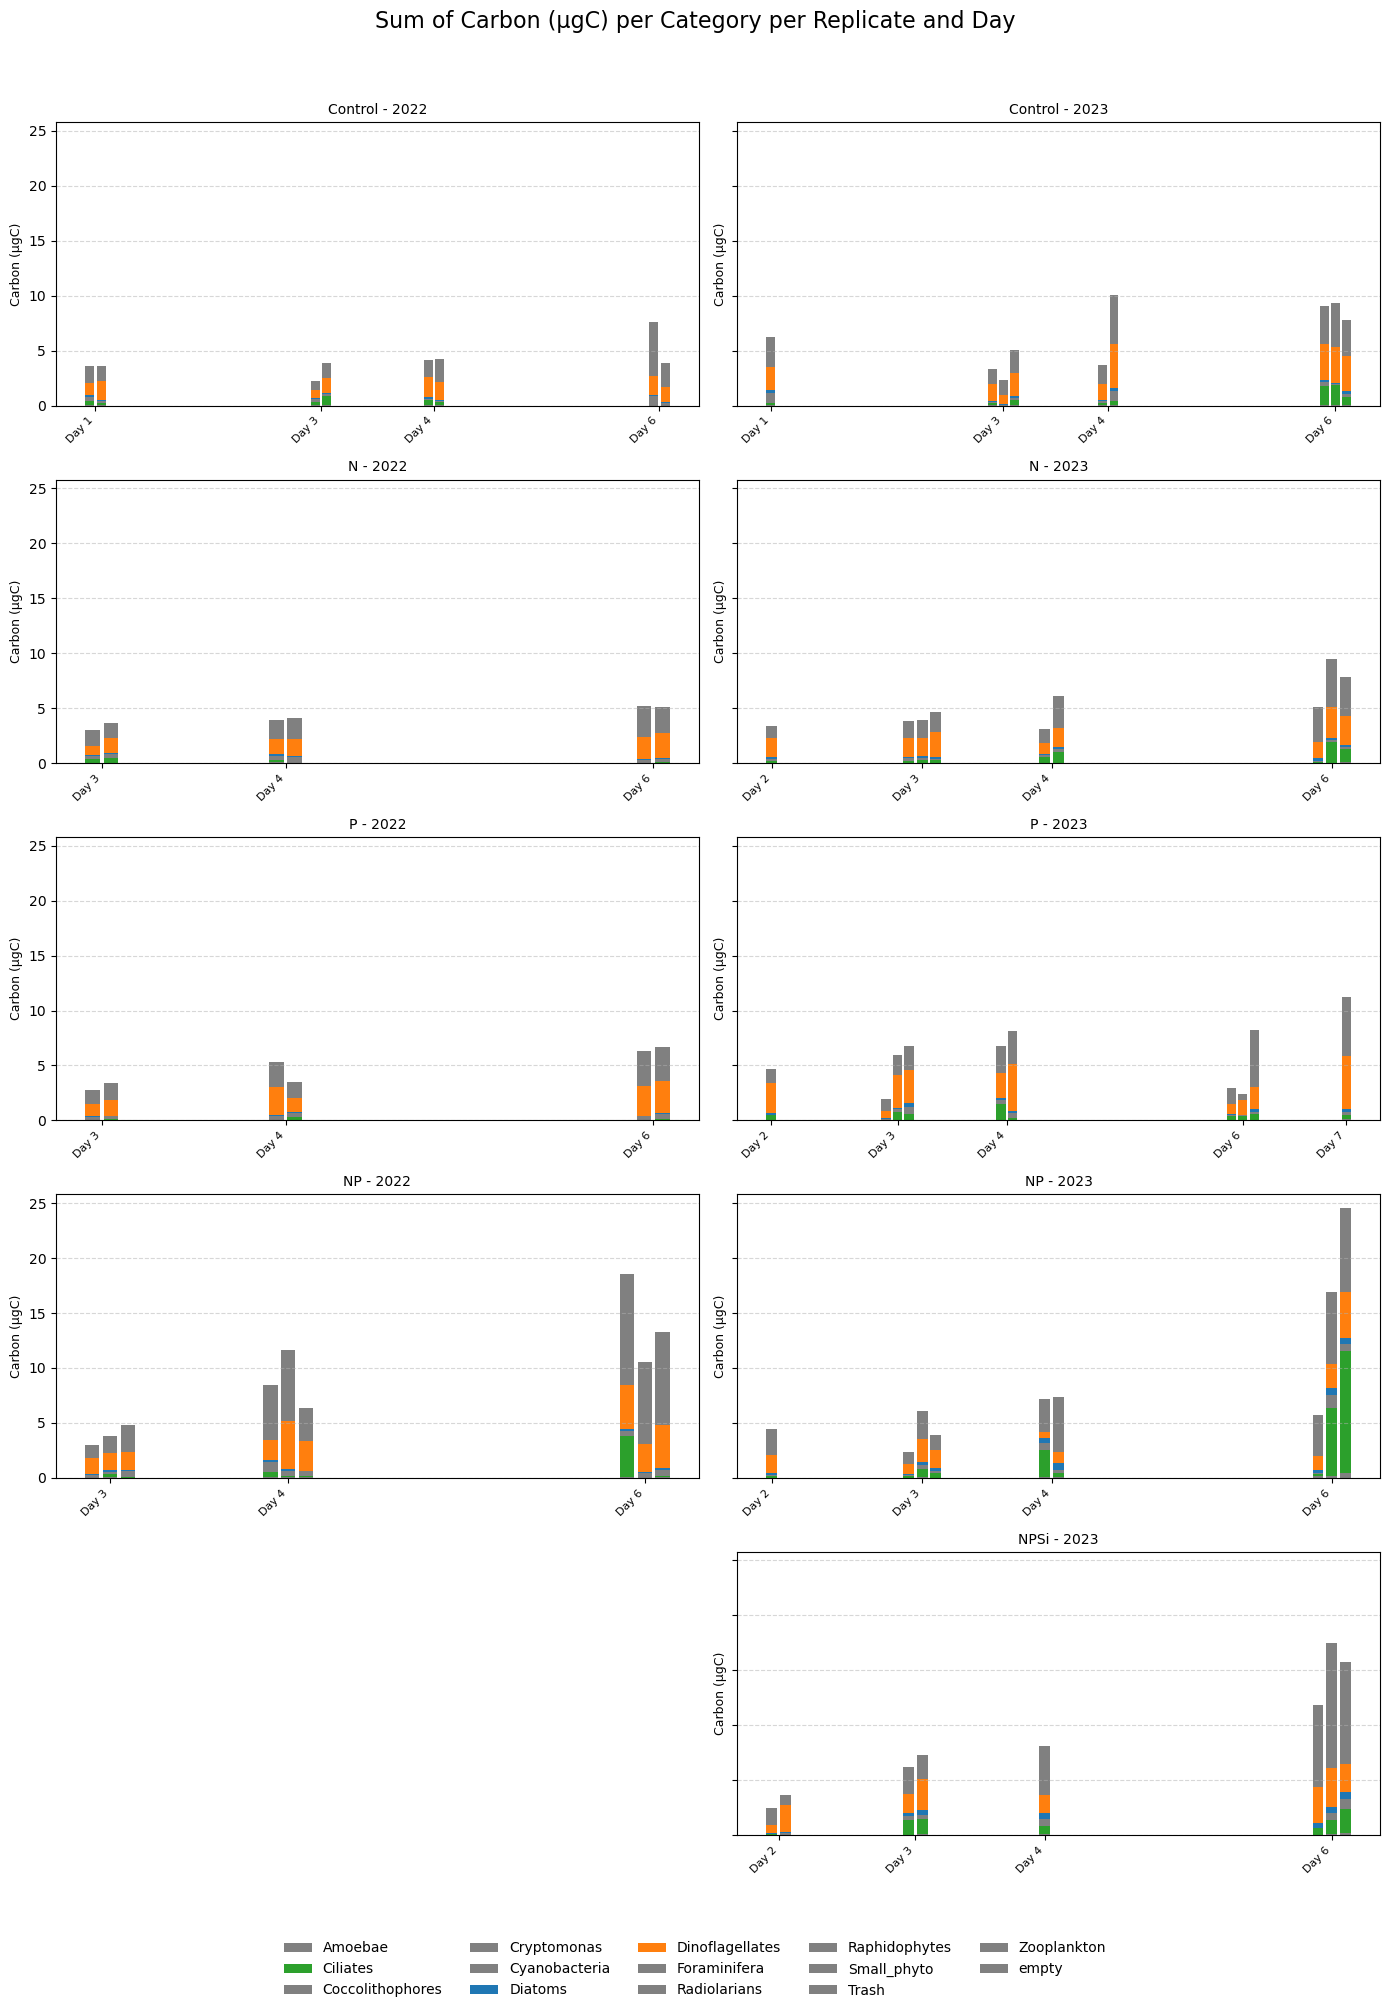

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'carbon_ugC']]

# === Filter only valid categories ===
df = df.dropna(subset=['category', 'carbon_ugC'])

# === Manual option: exclude Detritus? ===
EXCLUDE_DETRITUS = True

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

# === Define order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Define consistent color palette for categories (optional: you can customize) ===
category_palette = {
    'Diatoms': '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates': '#2ca02c',
    'Detritus': '#9467bd',
    'Other': '#8c564b'
}

# === Set output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Plot settings ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2, 
    figsize=(14, 20), 
    sharex=False, sharey=True
)

# === Loop over treatments and years ===
for i, treatment in enumerate(treatment_order):
    for j, year in enumerate([2022, 2023]):
        ax = axes[i, j]
        
        # Filter data for this subplot
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]
        
        if subset.empty:
            ax.axis('off')
            continue
        
        # Group by day, replicate, category and sum carbon
        grouped = subset.groupby(['day', 'replicate', 'category'], observed=True)['carbon_ugC'].sum().reset_index()
        
        # Pivot for plotting (replicates × categories), grouped by day
        pivot = grouped.pivot_table(
            index=['day', 'replicate'], 
            columns='category', 
            values='carbon_ugC', 
            fill_value=0
        ).reset_index()

        # Sort days for plotting
        days = sorted(pivot['day'].unique())
        
        # Assign x positions: 1, 2, 3... per replicate per day
        pivot['x'] = pivot.groupby('day').cumcount()
        pivot['x'] += pivot['day'] * 10  # Separate days by big gaps
        
        bottom = np.zeros(len(pivot))

        for category in sorted(pivot.columns[2:-1]):  # skip 'day', 'replicate', 'x'
            values = pivot[category].values
            ax.bar(
                pivot['x'],
                values,
                bottom=bottom,
                label=category if (i == 0 and j == 0) else "",
                color=category_palette.get(category, 'gray'),
                width=0.8
            )
            bottom += values

        # Set x-ticks at the middle of each day
        day_centers = [pivot[pivot['day'] == day]['x'].mean() for day in days]
        ax.set_xticks(day_centers)
        ax.set_xticklabels([f'Day {day}' for day in days], rotation=45, ha='right', fontsize=8)
        
        # Label settings
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        ax.set_ylabel("Carbon (µgC)", fontsize=9)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# === General figure settings ===
fig.suptitle("Sum of Carbon (µgC) per Category per Replicate and Day", fontsize=16)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.02), 
    ncol=len(category_palette),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save figure
figure_name = "carbon_per_category_per_replicate_matrix"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

#fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
#fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

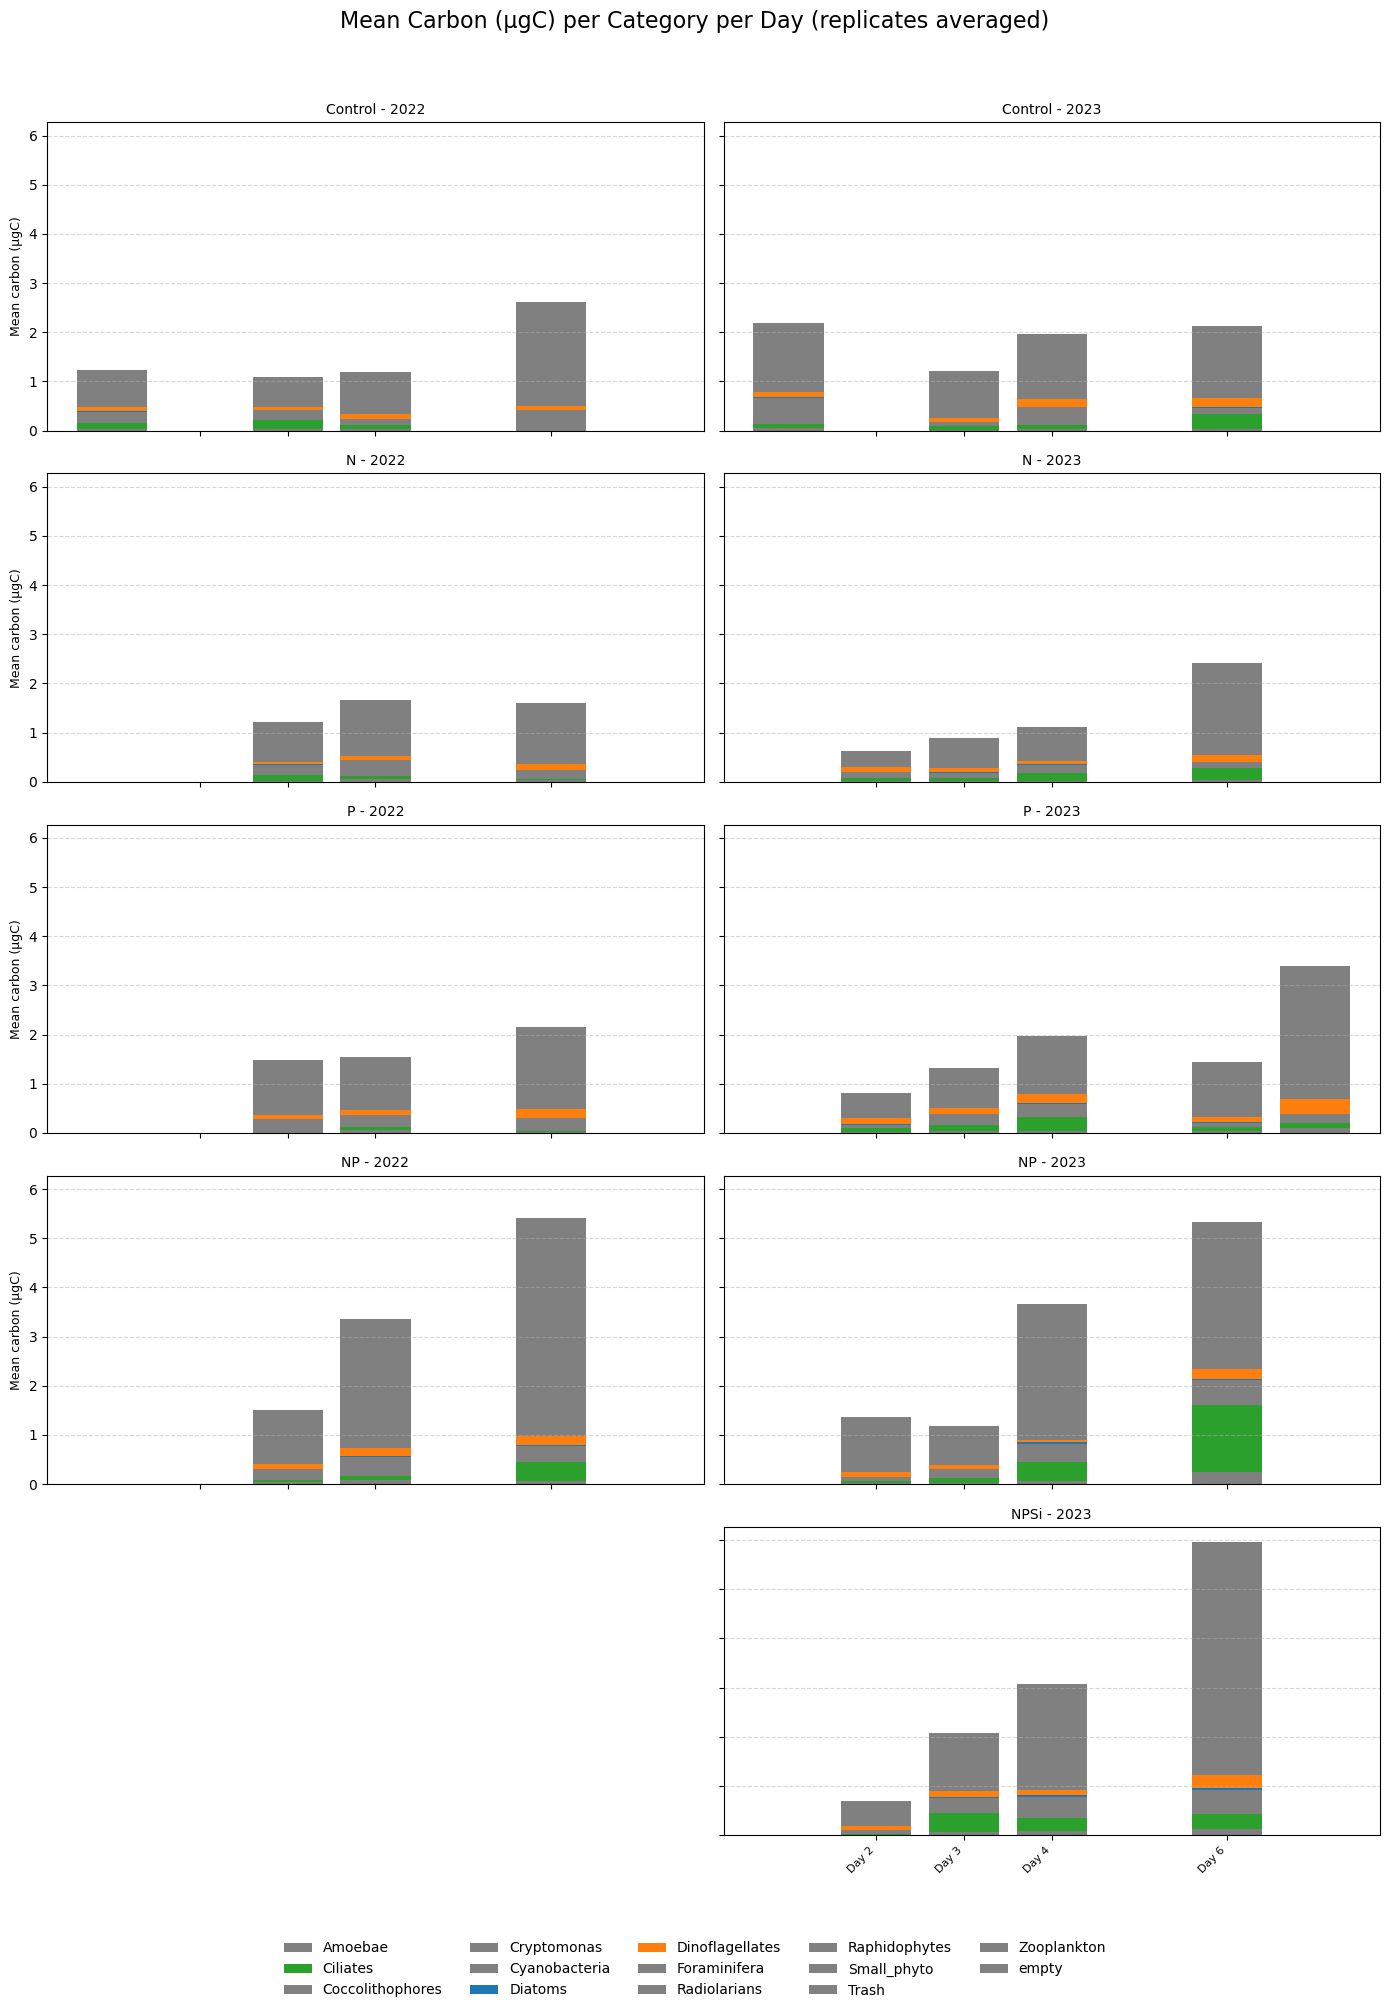

In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'carbon_ugC']]

# === Filter only valid categories ===
df = df.dropna(subset=['category', 'carbon_ugC'])

# === Manual option: exclude Detritus? ===
EXCLUDE_DETRITUS = True

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

# === Define order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Define consistent color palette for categories ===
category_palette = {
    'Diatoms': '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates': '#2ca02c',
    'Detritus': '#9467bd',
    'Other': '#8c564b'
}

# === Set output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Plot settings ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

# === Loop over treatments and years ===
for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data for this subplot
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        if subset.empty:
            ax.axis('off')
            continue

        # === Average over replicates ===
        # Mean carbon per day × category
        mean_grouped = (
            subset
            .groupby(['day', 'category'], observed=True)['carbon_ugC']
            .mean()
            .reset_index()
        )

        # Pivot: index = day, columns = category, values = mean carbon
        pivot = mean_grouped.pivot_table(
            index='day',
            columns='category',
            values='carbon_ugC',
            fill_value=0
        )

        # Sort days for plotting
        pivot = pivot.sort_index()
        days = pivot.index.values

        # Ensure x positions are just the days
        x = days

        # Stacked bars per day
        bottom = np.zeros(len(pivot))

        # Use sorted category names for consistent stacking
        for category in sorted(pivot.columns):
            values = pivot[category].values
            ax.bar(
                x,
                values,
                bottom=bottom,
                label=category if (i == 0 and j == 0) else "",
                color=category_palette.get(category, 'gray'),
                width=0.8
            )
            bottom += values

        # X-ticks: one per day
        ax.set_xticks(days)
        ax.set_xticklabels(
            [f'Day {d}' for d in days],
            rotation=45,
            ha='right',
            fontsize=8
        )

        # Label settings
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        if j == 0:
            ax.set_ylabel("Mean carbon (µgC)", fontsize=9)
        else:
            ax.set_ylabel("")
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# === General figure settings ===
fig.suptitle(
    "Mean Carbon (µgC) per Category per Day (replicates averaged)",
    fontsize=16
)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(category_palette),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save figure
figure_name = "mean_carbon_per_category_per_day_matrix"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

# fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
# fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

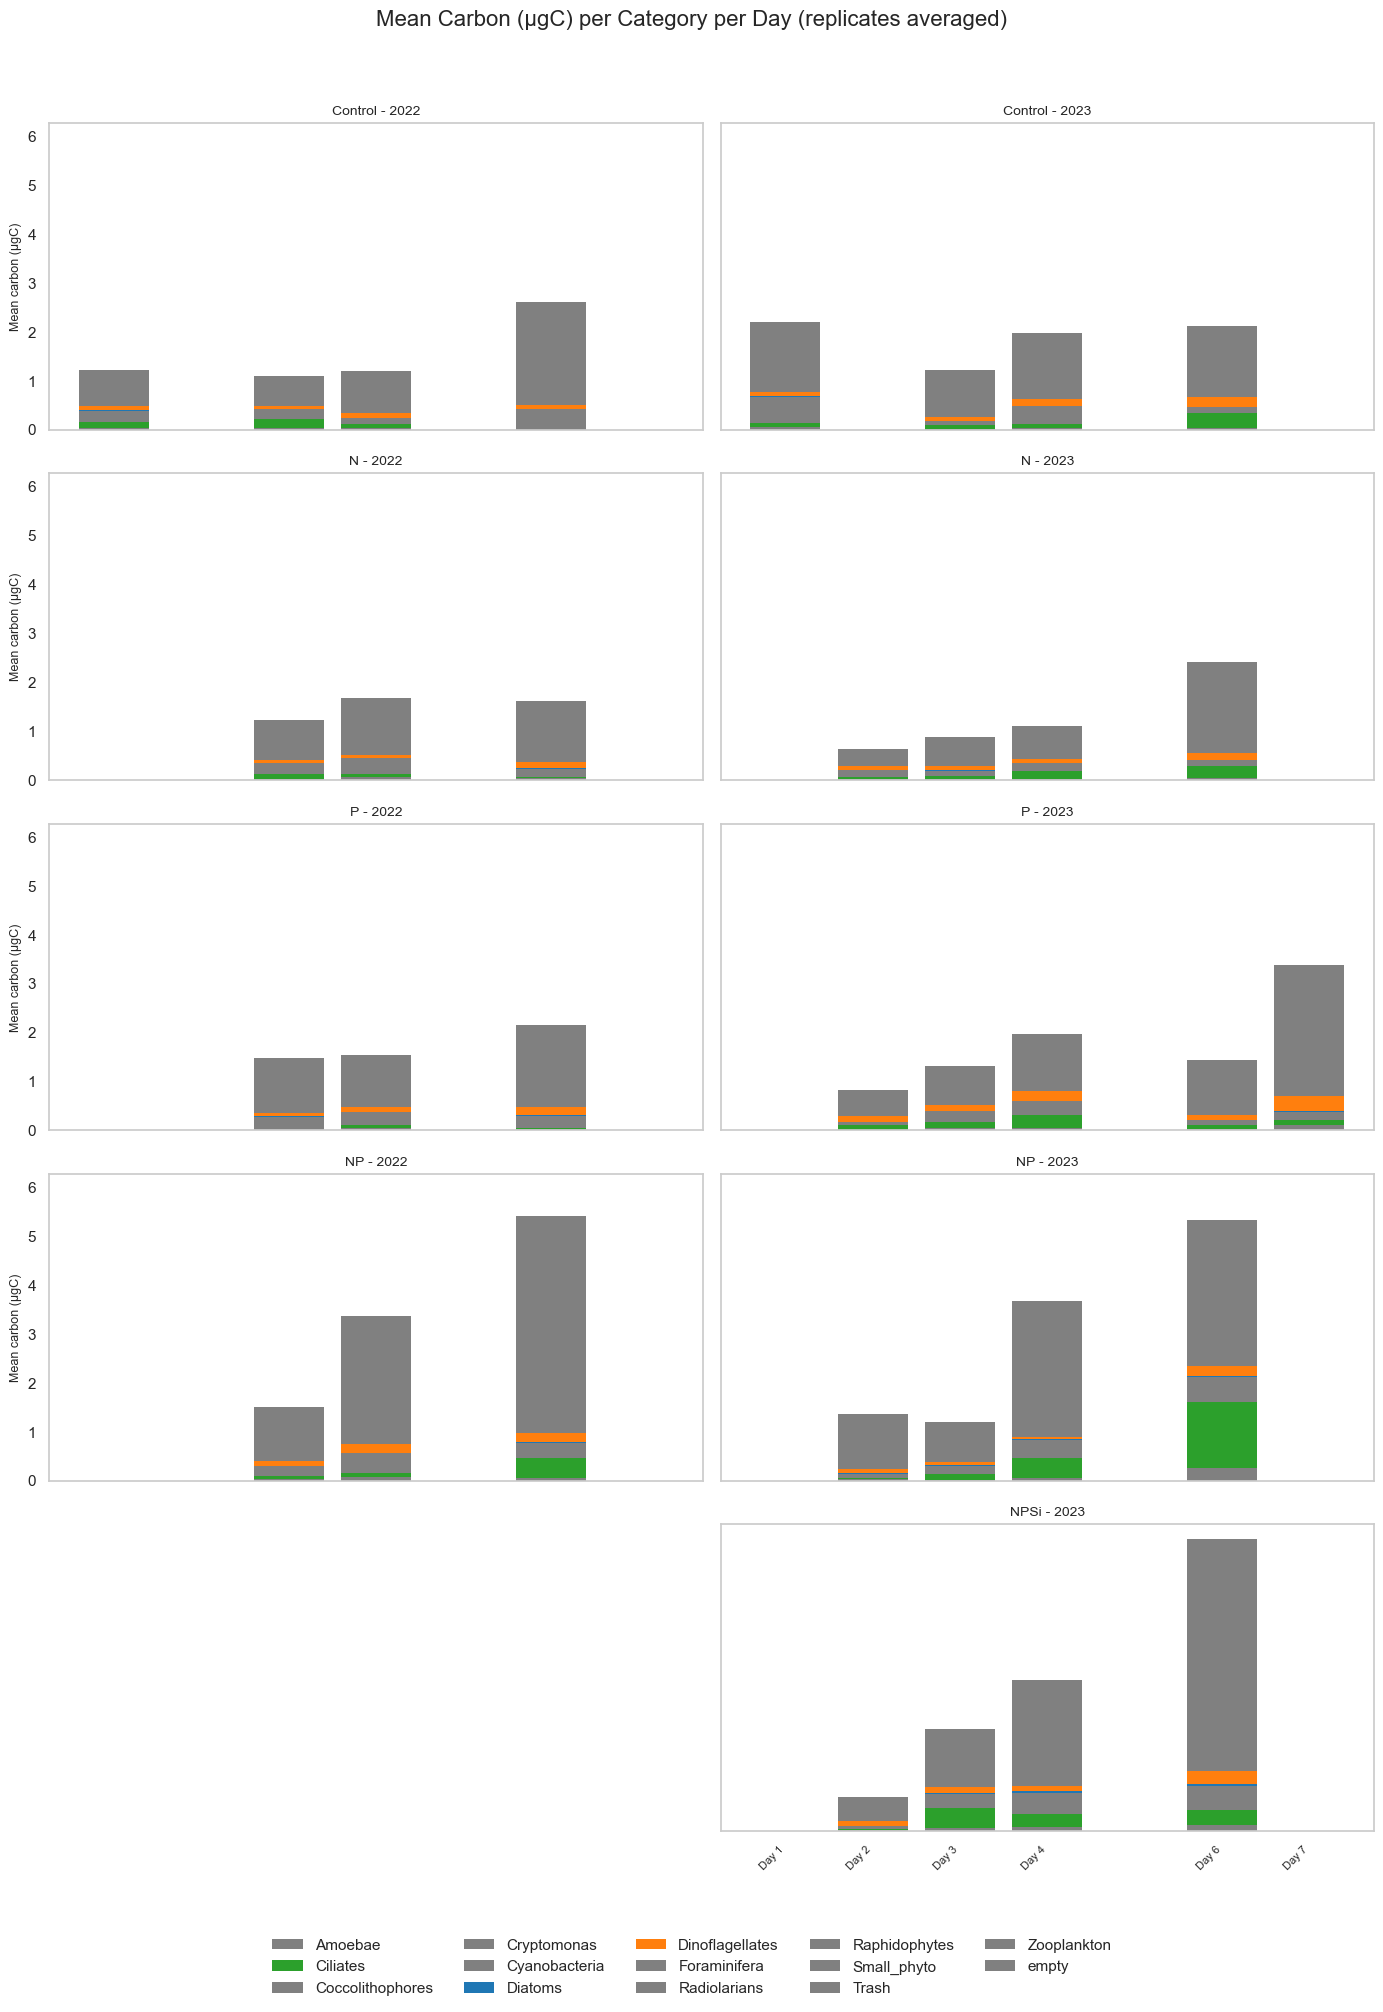

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'carbon_ugC']]

# === Filter only valid categories ===
df = df.dropna(subset=['category', 'carbon_ugC'])

# === Manual option: exclude Detritus? ===
EXCLUDE_DETRITUS = True

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

# === Define order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Define consistent color palette for categories (each group a different color) ===
category_palette = {
    'Diatoms': '#1f77b4',        # blue
    'Dinoflagellates': '#ff7f0e',# orange
    'Ciliates': '#2ca02c',       # green
    'Detritus': '#9467bd',       # purple
    'Other': '#8c564b'           # brown
}

# === Global day axis: make all x-axes parallel ===
global_days = sorted(df['day'].unique())

# === Set output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Plot settings ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data for this subplot
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        if subset.empty:
            ax.axis('off')
            continue

        # === Average over replicates ===
        mean_grouped = (
            subset
            .groupby(['day', 'category'], observed=True)['carbon_ugC']
            .mean()
            .reset_index()
        )

        # Pivot: index = day, columns = category
        pivot = mean_grouped.pivot_table(
            index='day',
            columns='category',
            values='carbon_ugC',
            fill_value=0
        )

        # Reindex to global days so all x-axes are aligned
        pivot = pivot.reindex(global_days, fill_value=0)

        # Sort categories alphabetically for consistent stacking
        categories = sorted(pivot.columns)

        # X positions are the same global days for all panels
        x = np.array(global_days, dtype=float)

        bottom = np.zeros(len(pivot))

        for category in categories:
            values = pivot[category].values

            ax.bar(
                x,
                values,
                bottom=bottom,
                label=category if (i == 0 and j == 0) else "",
                color=category_palette.get(category, 'gray'),
                width=0.8,
                edgecolor='none',   # remove contour line
                linewidth=0.0
            )
            bottom += values

        # X-ticks: same for all subplots
        ax.set_xticks(global_days)
        if i == len(treatment_order) - 1:
            ax.set_xticklabels(
                [f'Day {d}' for d in global_days],
                rotation=45,
                ha='right',
                fontsize=8
            )
        else:
            # hide tick labels on upper rows to avoid clutter
            ax.set_xticklabels([])

        # Labels and titles
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        if j == 0:
            ax.set_ylabel("Mean carbon (µgC)", fontsize=9)
        else:
            ax.set_ylabel("")

        # Remove background grid
        ax.grid(False)

# === General figure settings ===
fig.suptitle(
    "Mean Carbon (µgC) per Category per Day (replicates averaged)",
    fontsize=16
)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(category_palette),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save figure
figure_name = "mean_carbon_per_category_per_day_matrix"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

# fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
# fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

### Visualization of abundance (comparison between replicates)

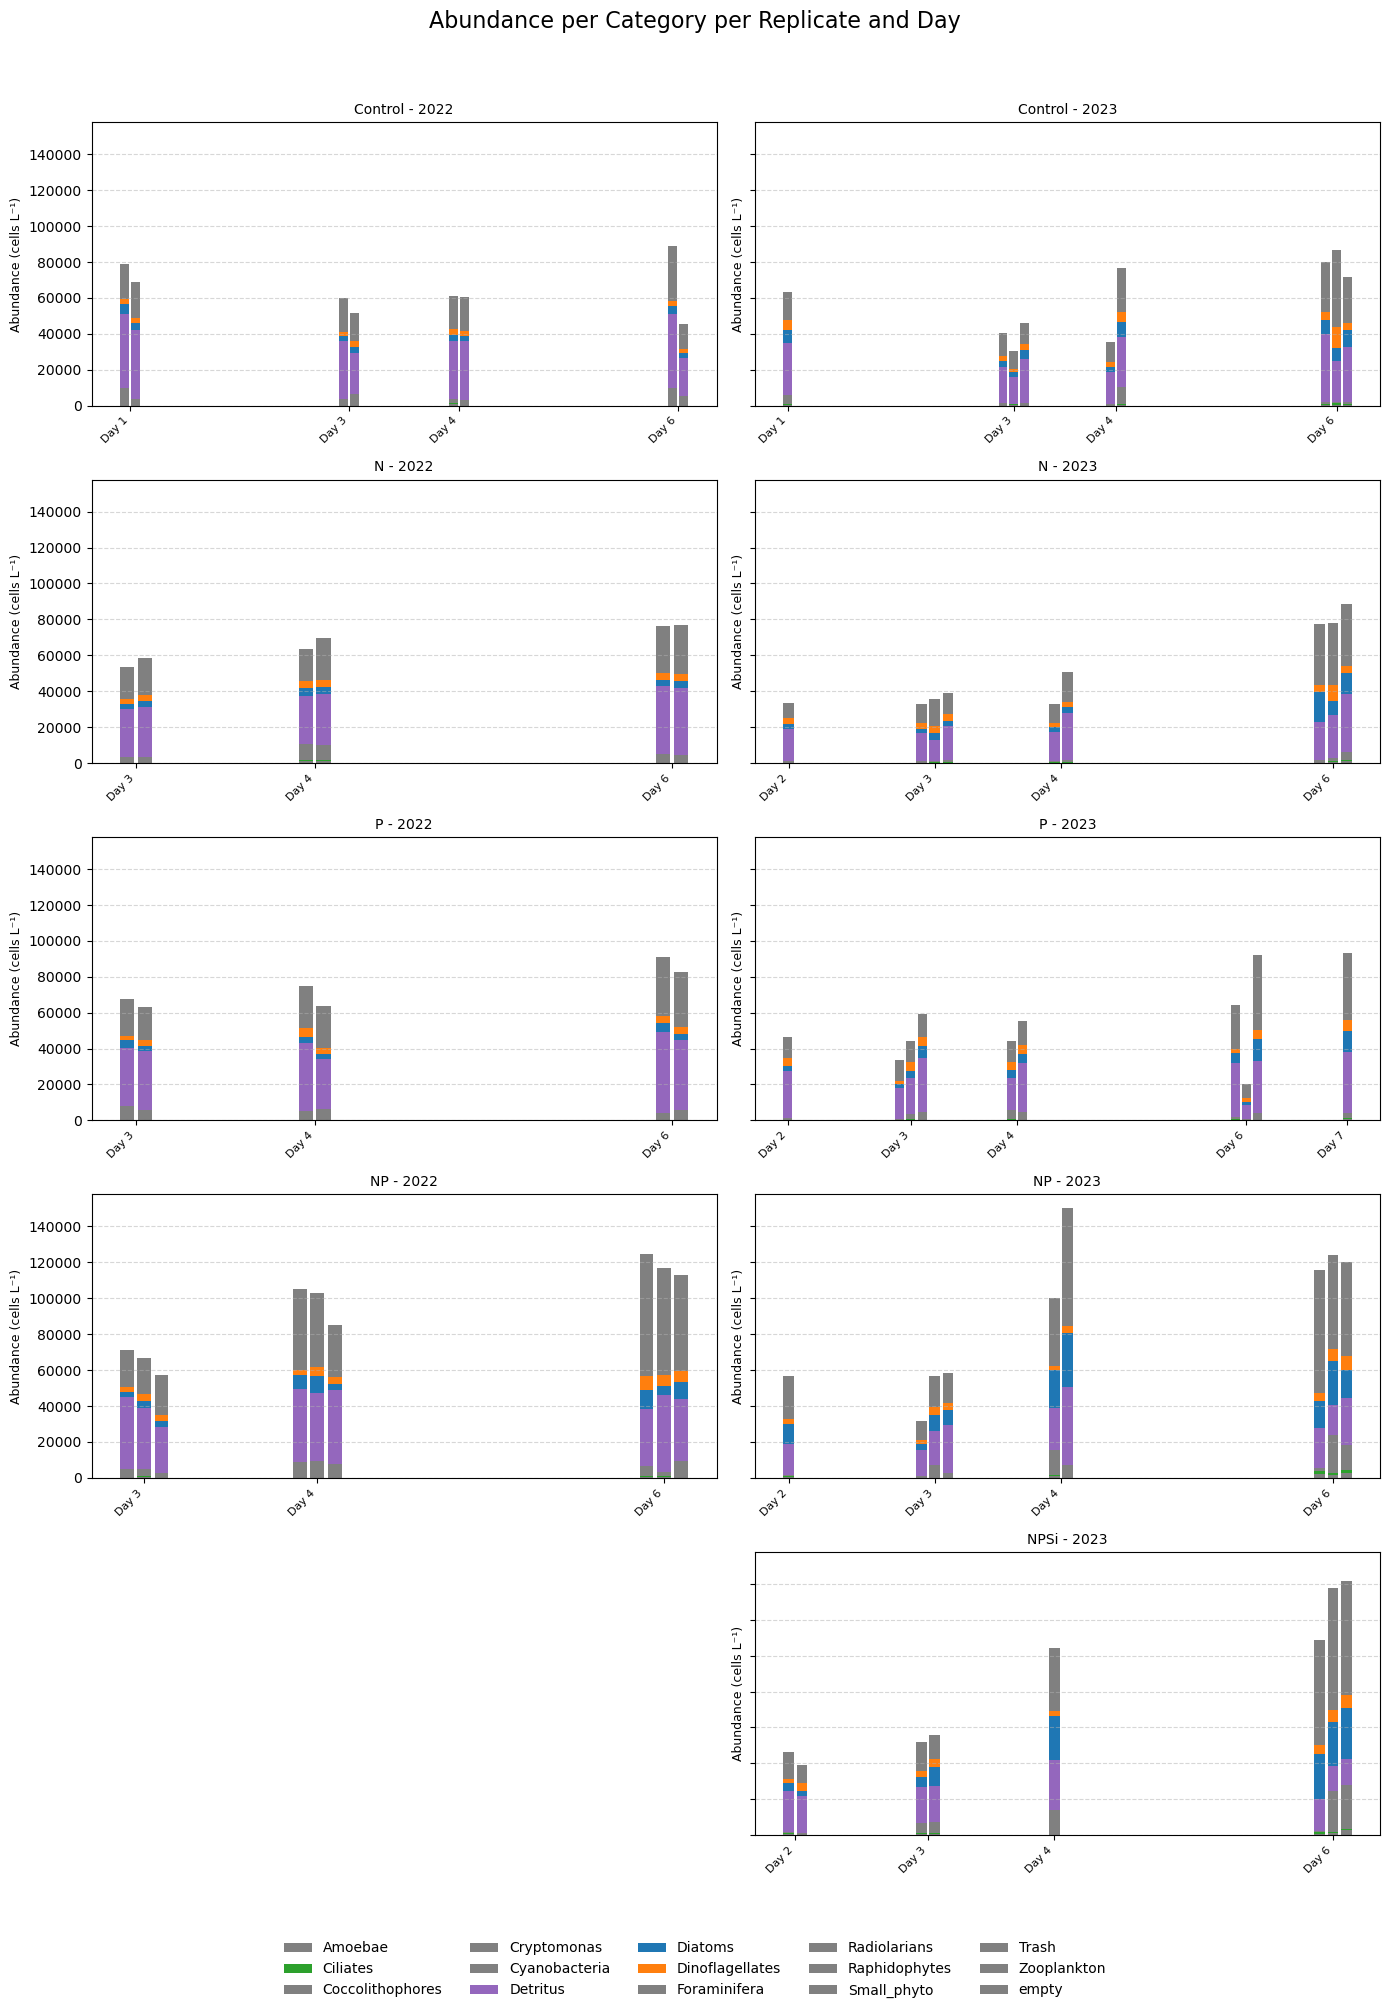

In [8]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'abundance_per_L']]

# === Filter only valid categories ===
df = df.dropna(subset=['category', 'abundance_per_L'])

# === Manual option: exclude Detritus? ===
EXCLUDE_DETRITUS = False

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

# === Define order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Define consistent color palette for categories ===
category_palette = {
    'Diatoms': '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates': '#2ca02c',
    'Detritus': '#9467bd',
    'Other': '#8c564b'
}

# === Set output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Plot settings ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2, 
    figsize=(14, 20), 
    sharex=False, sharey=True
)

# === Loop over treatments and years ===
for i, treatment in enumerate(treatment_order):
    for j, year in enumerate([2022, 2023]):
        ax = axes[i, j]
        
        # Filter data for this subplot
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]
        
        if subset.empty:
            ax.axis('off')
            continue
        
        # Group by day, replicate, category and sum abundance
        grouped = subset.groupby(['day', 'replicate', 'category'], observed=True)['abundance_per_L'].sum().reset_index()
        
        # Pivot for plotting (replicates × categories), grouped by day
        pivot = grouped.pivot_table(
            index=['day', 'replicate'], 
            columns='category', 
            values='abundance_per_L', 
            fill_value=0
        ).reset_index()

        # Sort days for plotting
        days = sorted(pivot['day'].unique())
        
        # Assign x positions: 1, 2, 3... per replicate per day
        pivot['x'] = pivot.groupby('day').cumcount()
        pivot['x'] += pivot['day'] * 10  # Separate days by big gaps
        
        bottom = np.zeros(len(pivot))

        for category in sorted(pivot.columns[2:-1]):  # skip 'day', 'replicate', 'x'
            values = pivot[category].values
            ax.bar(
                pivot['x'],
                values,
                bottom=bottom,
                label=category if (i == 0 and j == 0) else "",
                color=category_palette.get(category, 'gray'),
                width=0.8
            )
            bottom += values

        # Set x-ticks at the middle of each day
        day_centers = [pivot[pivot['day'] == day]['x'].mean() for day in days]
        ax.set_xticks(day_centers)
        ax.set_xticklabels([f'Day {day}' for day in days], rotation=45, ha='right', fontsize=8)
        
        # Label settings
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        ax.set_ylabel("Abundance (cells L⁻¹)", fontsize=9)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# === General figure settings ===
fig.suptitle("Abundance per Category per Replicate and Day", fontsize=16)

# Create a single legend outside the plot
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.02), 
    ncol=len(category_palette),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Save figure
figure_name = "abundance_per_category_per_replicate_matrix"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

#fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
#fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

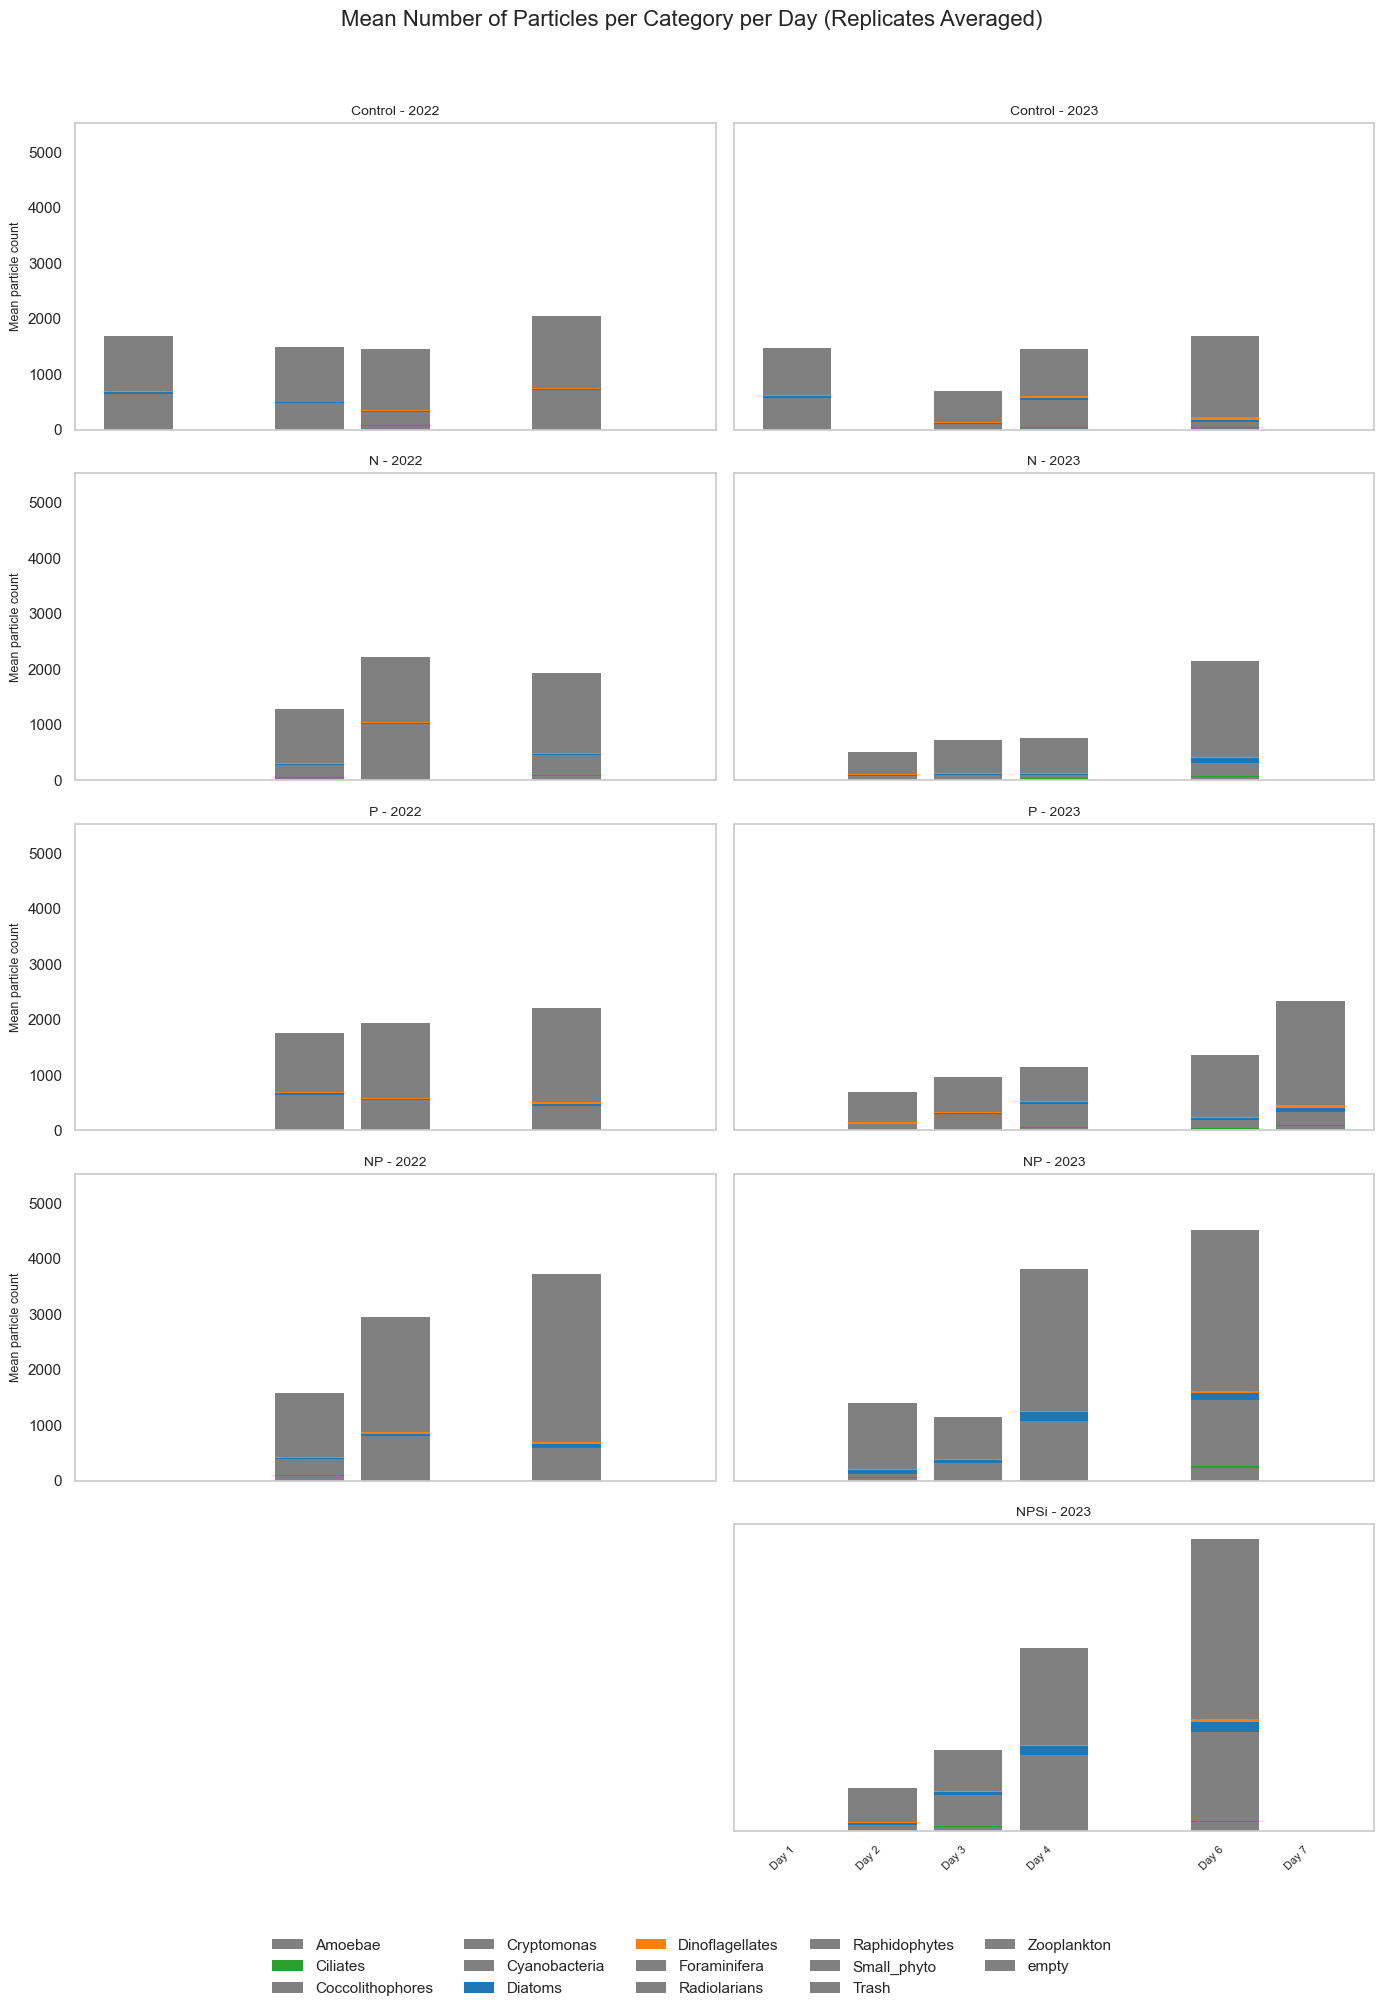

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "/Users/jorge/Documents/Data_Analysis/C_biomass_calculation/NEW_workflow/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
# IMPORTANT: we will use "particles" (or your count column)
# If your column is named differently (e.g., 'n_particles'), change it here
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'particles']]

# === Remove missing ===
df = df.dropna(subset=['category', 'particles'])

# === Manual option: exclude Detritus? ===
EXCLUDE_DETRITUS = True
if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

# === Order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Colors ===
category_palette = {
    'Diatoms': '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates': '#2ca02c',
    'Detritus': '#9467bd',
    'Other': '#8c564b'
}

# === Create global days to align all x-axes ===
global_days = sorted(df['day'].unique())

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]
        if subset.empty:
            ax.axis('off')
            continue

        # === Average over replicates: mean particle counts ===
        mean_grouped = (
            subset
            .groupby(['day', 'category'], observed=True)['particles']
            .mean()
            .reset_index()
        )

        # Pivot: rows = day, columns = category
        pivot = mean_grouped.pivot_table(
            index='day',
            columns='category',
            values='particles',
            fill_value=0
        )

        # Align days across all panels
        pivot = pivot.reindex(global_days, fill_value=0)

        # Consistent category order
        categories = sorted(pivot.columns)

        x = np.array(global_days, dtype=float)
        bottom = np.zeros(len(pivot))

        # === Stacked bars ===
        for category in categories:
            values = pivot[category].values
            ax.bar(
                x,
                values,
                bottom=bottom,
                color=category_palette.get(category, 'gray'),
                width=0.8,
                edgecolor='none',
                linewidth=0.0,
                label=category if (i == 0 and j == 0) else ""
            )
            bottom += values

        # X-axis formatting
        ax.set_xticks(global_days)
        if i == len(treatment_order) - 1:
            ax.set_xticklabels(
                [f"Day {d}" for d in global_days],
                rotation=45,
                ha='right',
                fontsize=8
            )
        else:
            ax.set_xticklabels([])

        # Labels and title
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        if j == 0:
            ax.set_ylabel("Mean particle count", fontsize=9)
        else:
            ax.set_ylabel("")

        ax.grid(False)

# === Figure title ===
fig.suptitle(
    "Mean Number of Particles per Category per Day (Replicates Averaged)",
    fontsize=16
)

# === Legend ===
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=len(category_palette),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Optionally save
figure_name = "mean_particle_counts_per_category_per_day"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

# fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
# fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

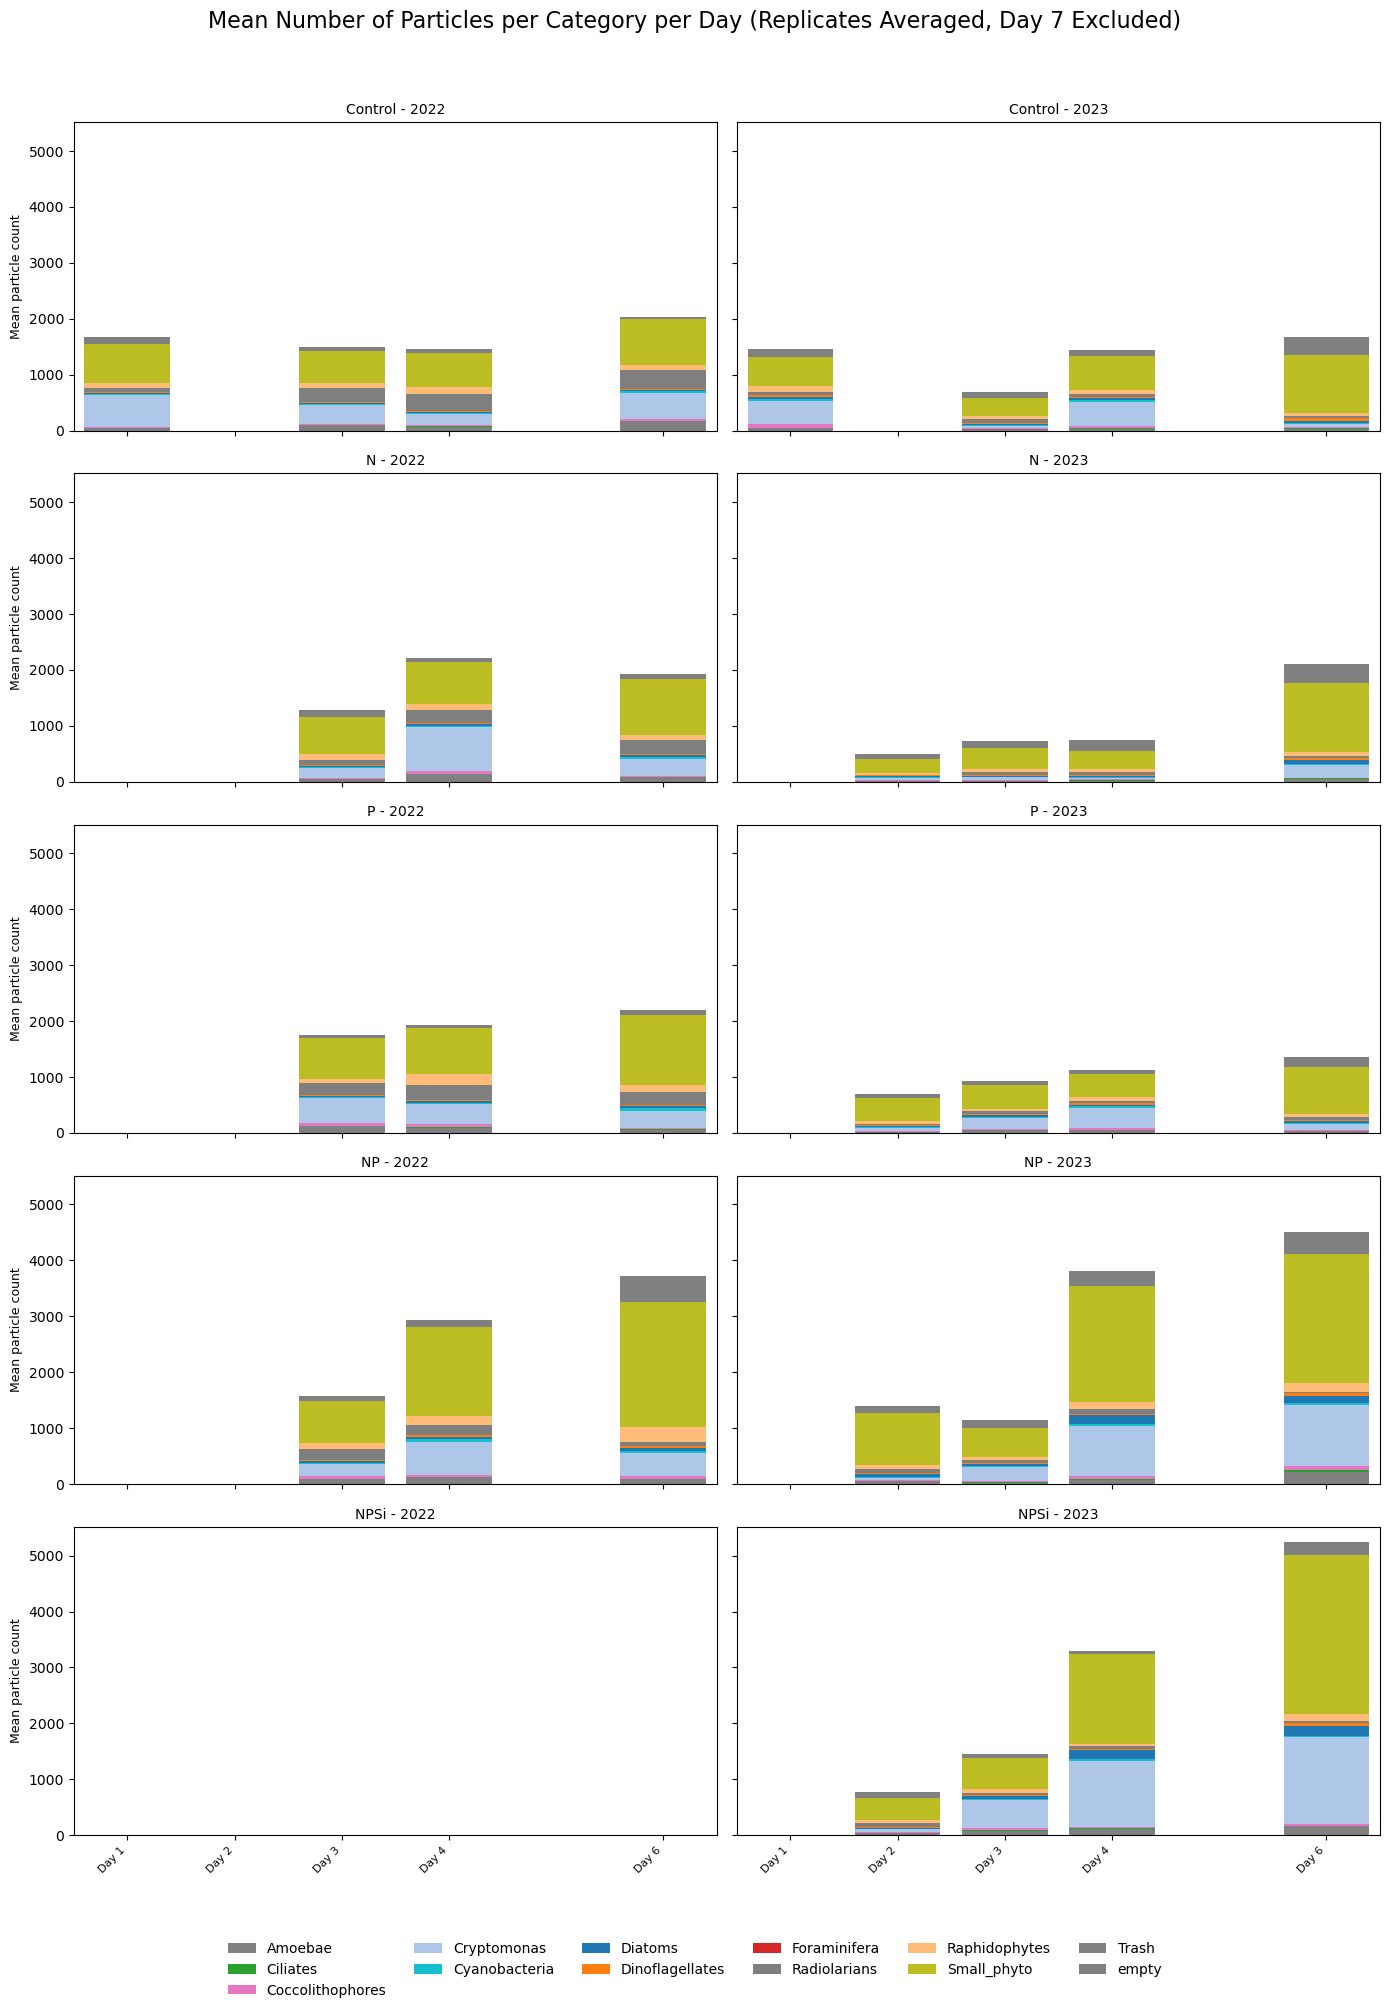

In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
# NOTE: assuming 'particles' is the count column
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'particles']]

# === Remove missing ===
df = df.dropna(subset=['category', 'particles'])

# === Manual options ===
EXCLUDE_DETRITUS = True
EXCLUDE_ZOOPLANKTON = True

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

if EXCLUDE_ZOOPLANKTON:
    df = df[df['category'] != 'Zooplankton']

# === Exclude Day 7 ===
df = df[df['day'] != 7]

# === Order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Color palette for all possible groups ===
category_palette = {
    'Diatoms':         '#1f77b4',  # blue
    'Dinoflagellates': '#ff7f0e',  # orange
    'Ciliates':        '#2ca02c',  # green
    'Detritus':        '#9467bd',  # purple (kept in case EXCLUDE_DETRITUS=False)
    'Other':           '#8c564b',  # brown

    # New explicit colors for requested groups:
    'Coccolithophores': '#e377c2',  # pink
    'Cyanobacteria':    '#17becf',  # cyan
    'Radiolarians':     '#7f7f7f',  # gray
    'Small_phyto':      '#bcbd22',  # yellow-green
    'Foraminifera':     '#d62728',  # red
    'Cryptomonas':      '#aec7e8',  # light blue
    'Raphidophytes':    '#ffbb78'   # light orange
}

# === Global days (after excluding Day 7) for aligned x-axes ===
global_days = sorted(df['day'].unique())

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data for this treatment–year
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        # We do NOT turn off empty axes; we want the panel to exist for comparison
        if subset.empty:
            # Create an empty pivot with zeros for all days and no categories;
            # panel will just show empty axes.
            pivot = pd.DataFrame(index=global_days)
            categories = []
        else:
            # === Average over replicates: mean particle counts ===
            mean_grouped = (
                subset
                .groupby(['day', 'category'], observed=True)['particles']
                .mean()
                .reset_index()
            )

            # Pivot: rows = day, columns = category
            pivot = mean_grouped.pivot_table(
                index='day',
                columns='category',
                values='particles',
                fill_value=0
            )

            # Align days across all panels (ensure Days 1–6)
            pivot = pivot.reindex(global_days, fill_value=0)

            # Consistent category order (sorted by name)
            categories = sorted(pivot.columns)

        x = np.array(global_days, dtype=float)
        bottom = np.zeros(len(pivot))

        # === Stacked bars for each category ===
        for category in categories:
            values = pivot[category].values
            ax.bar(
                x,
                values,
                bottom=bottom,
                color=category_palette.get(category, 'gray'),
                width=0.8,
                edgecolor='none',   # no contour between stacked sections
                linewidth=0.0,
                label=category if (i == 0 and j == 0) else ""
            )
            bottom += values

        # X-axis formatting
        ax.set_xticks(global_days)
        if i == len(treatment_order) - 1:
            ax.set_xticklabels(
                [f"Day {d}" for d in global_days],
                rotation=45,
                ha='right',
                fontsize=8
            )
        else:
            ax.set_xticklabels([])

        # Force same x-limits for all panels
        ax.set_xlim(min(global_days) - 0.5, max(global_days) + 0.5)

        # Labels and title
        ax.set_title(f"{treatment} - {year}", fontsize=10)
        if j == 0:
            ax.set_ylabel("Mean particle count", fontsize=9)
        else:
            ax.set_ylabel("")

        # Remove background grid
        ax.grid(False)

# === Figure title ===
fig.suptitle(
    "Mean Number of Particles per Category per Day (Replicates Averaged, Day 7 Excluded)",
    fontsize=16
)

# === Legend ===
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=min(len(category_palette), 6),
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])

# Optionally save
figure_name = "mean_particle_counts_per_category_per_day_no_day7"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"
if EXCLUDE_ZOOPLANKTON:
    figure_name += "_no_zooplankton"

# fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
# fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

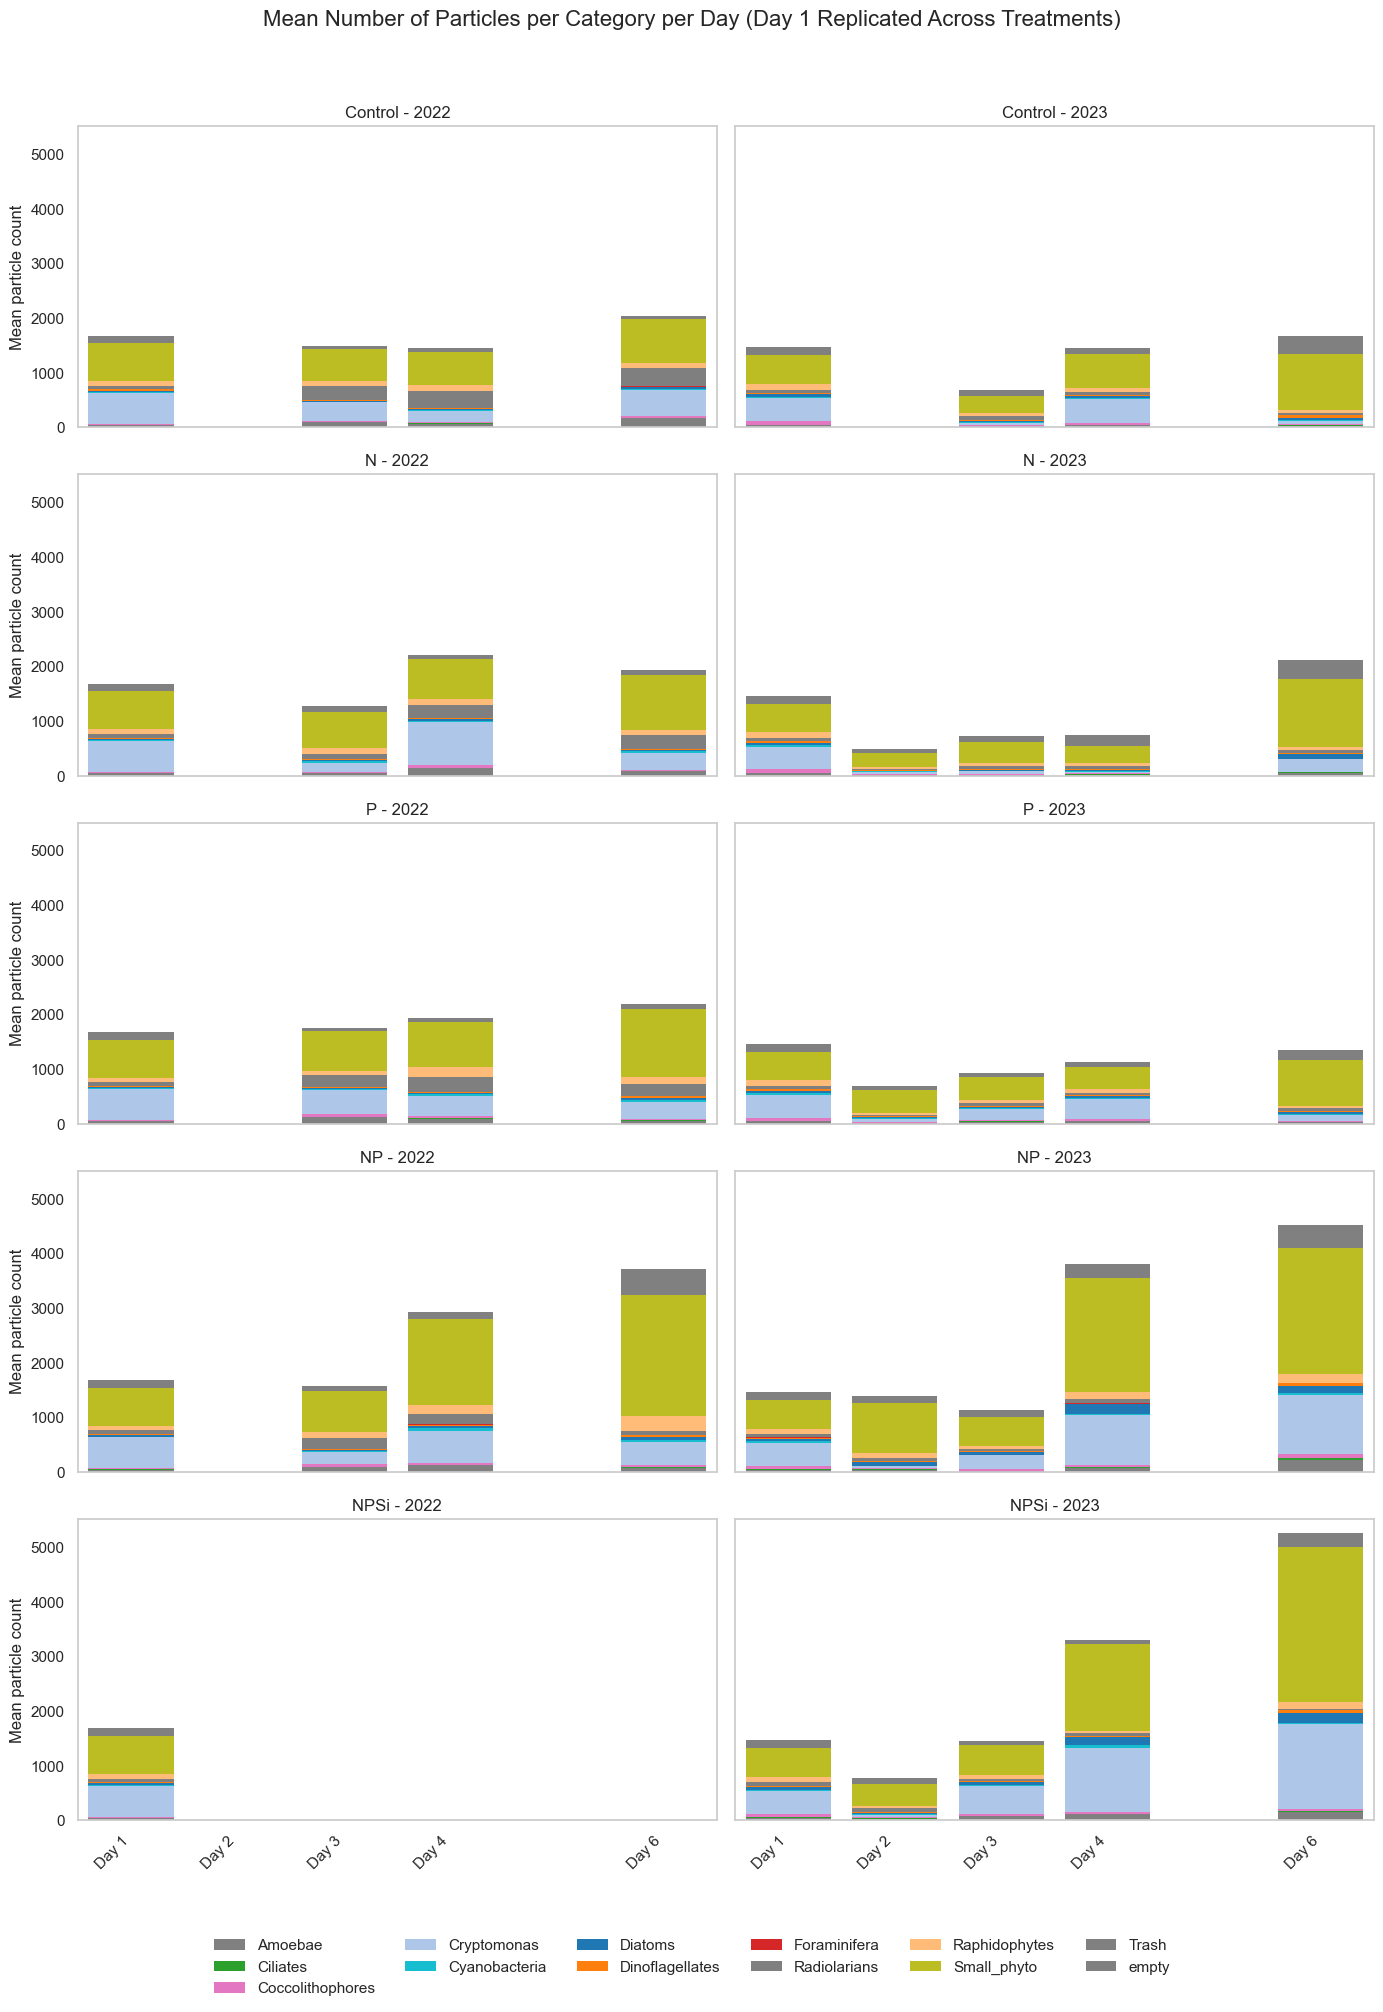

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "/Users/jorge/Documents/Data_Analysis/C_biomass_calculation/NEW_workflow/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'particles']]

# === Remove missing ===
df = df.dropna(subset=['category', 'particles'])

# === Manual options ===
EXCLUDE_DETRITUS = True
EXCLUDE_ZOOPLANKTON = True

if EXCLUDE_DETRITUS:
    df = df[df['category'] != 'Detritus']

if EXCLUDE_ZOOPLANKTON:
    df = df[df['category'] != 'Zooplankton']

# === Exclude Day 7 ===
df = df[df['day'] != 7]

# ============================================================
# === NEW STEP: replicate Day 1 within each year to all treatments ===
# ============================================================

df_day1 = df[df['day'] == 1]

replicated_rows = []

for year in [2022, 2023]:
    # extract the real day1 data of that year
    base_day1 = df_day1[df_day1['year'] == year]
    if base_day1.empty:
        continue
    
    # for each treatment, create a copy of day 1 rows
    for treatment in ['Control', 'N', 'P', 'NP', 'NPSi']:
        temp = base_day1.copy()
        temp['treatment'] = treatment
        replicated_rows.append(temp)

# Combine everything
df = df[df['day'] != 1]   # remove original Day 1 (we will replace it)
df_day1_combined = pd.concat(replicated_rows, ignore_index=True)
df = pd.concat([df, df_day1_combined], ignore_index=True)

# ============================================================

# === Order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Color palette ===
category_palette = {
    'Diatoms':         '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates':        '#2ca02c',
    'Detritus':        '#9467bd',
    'Other':           '#8c564b',

    'Coccolithophores': '#e377c2',
    'Cyanobacteria':    '#17becf',
    'Radiolarians':     '#7f7f7f',
    'Small_phyto':      '#bcbd22',
    'Foraminifera':     '#d62728',
    'Cryptomonas':      '#aec7e8',
    'Raphidophytes':    '#ffbb78'
}

# === Global days (1–6) ===
global_days = sorted(df['day'].unique())

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        # Average across replicates
        mean_grouped = (
            subset
            .groupby(['day', 'category'], observed=True)['particles']
            .mean()
            .reset_index()
        )

        pivot = mean_grouped.pivot_table(
            index='day',
            columns='category',
            values='particles',
            fill_value=0
        )

        # Align to all days
        pivot = pivot.reindex(global_days, fill_value=0)

        categories = sorted(pivot.columns)

        x = np.array(global_days, dtype=float)
        bottom = np.zeros(len(pivot))

        # === Stacked bars ===
        for category in categories:
            ax.bar(
                x,
                pivot[category].values,
                bottom=bottom,
                color=category_palette.get(category, 'gray'),
                width=0.8,
                edgecolor='none',
                linewidth=0.0,
                label=category if (i == 0 and j == 0) else ""
            )
            bottom += pivot[category].values

        ax.set_xticks(global_days)
        if i == len(treatment_order) - 1:
            ax.set_xticklabels([f"Day {d}" for d in global_days], rotation=45, ha='right')
        else:
            ax.set_xticklabels([])

        ax.set_xlim(min(global_days) - 0.5, max(global_days) + 0.5)

        if j == 0:
            ax.set_ylabel("Mean particle count")
        ax.set_title(f"{treatment} - {year}")

        ax.grid(False)

fig.suptitle(
    "Mean Number of Particles per Category per Day (Day 1 Replicated Across Treatments)",
    fontsize=16
)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=6, frameon=False)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.show()

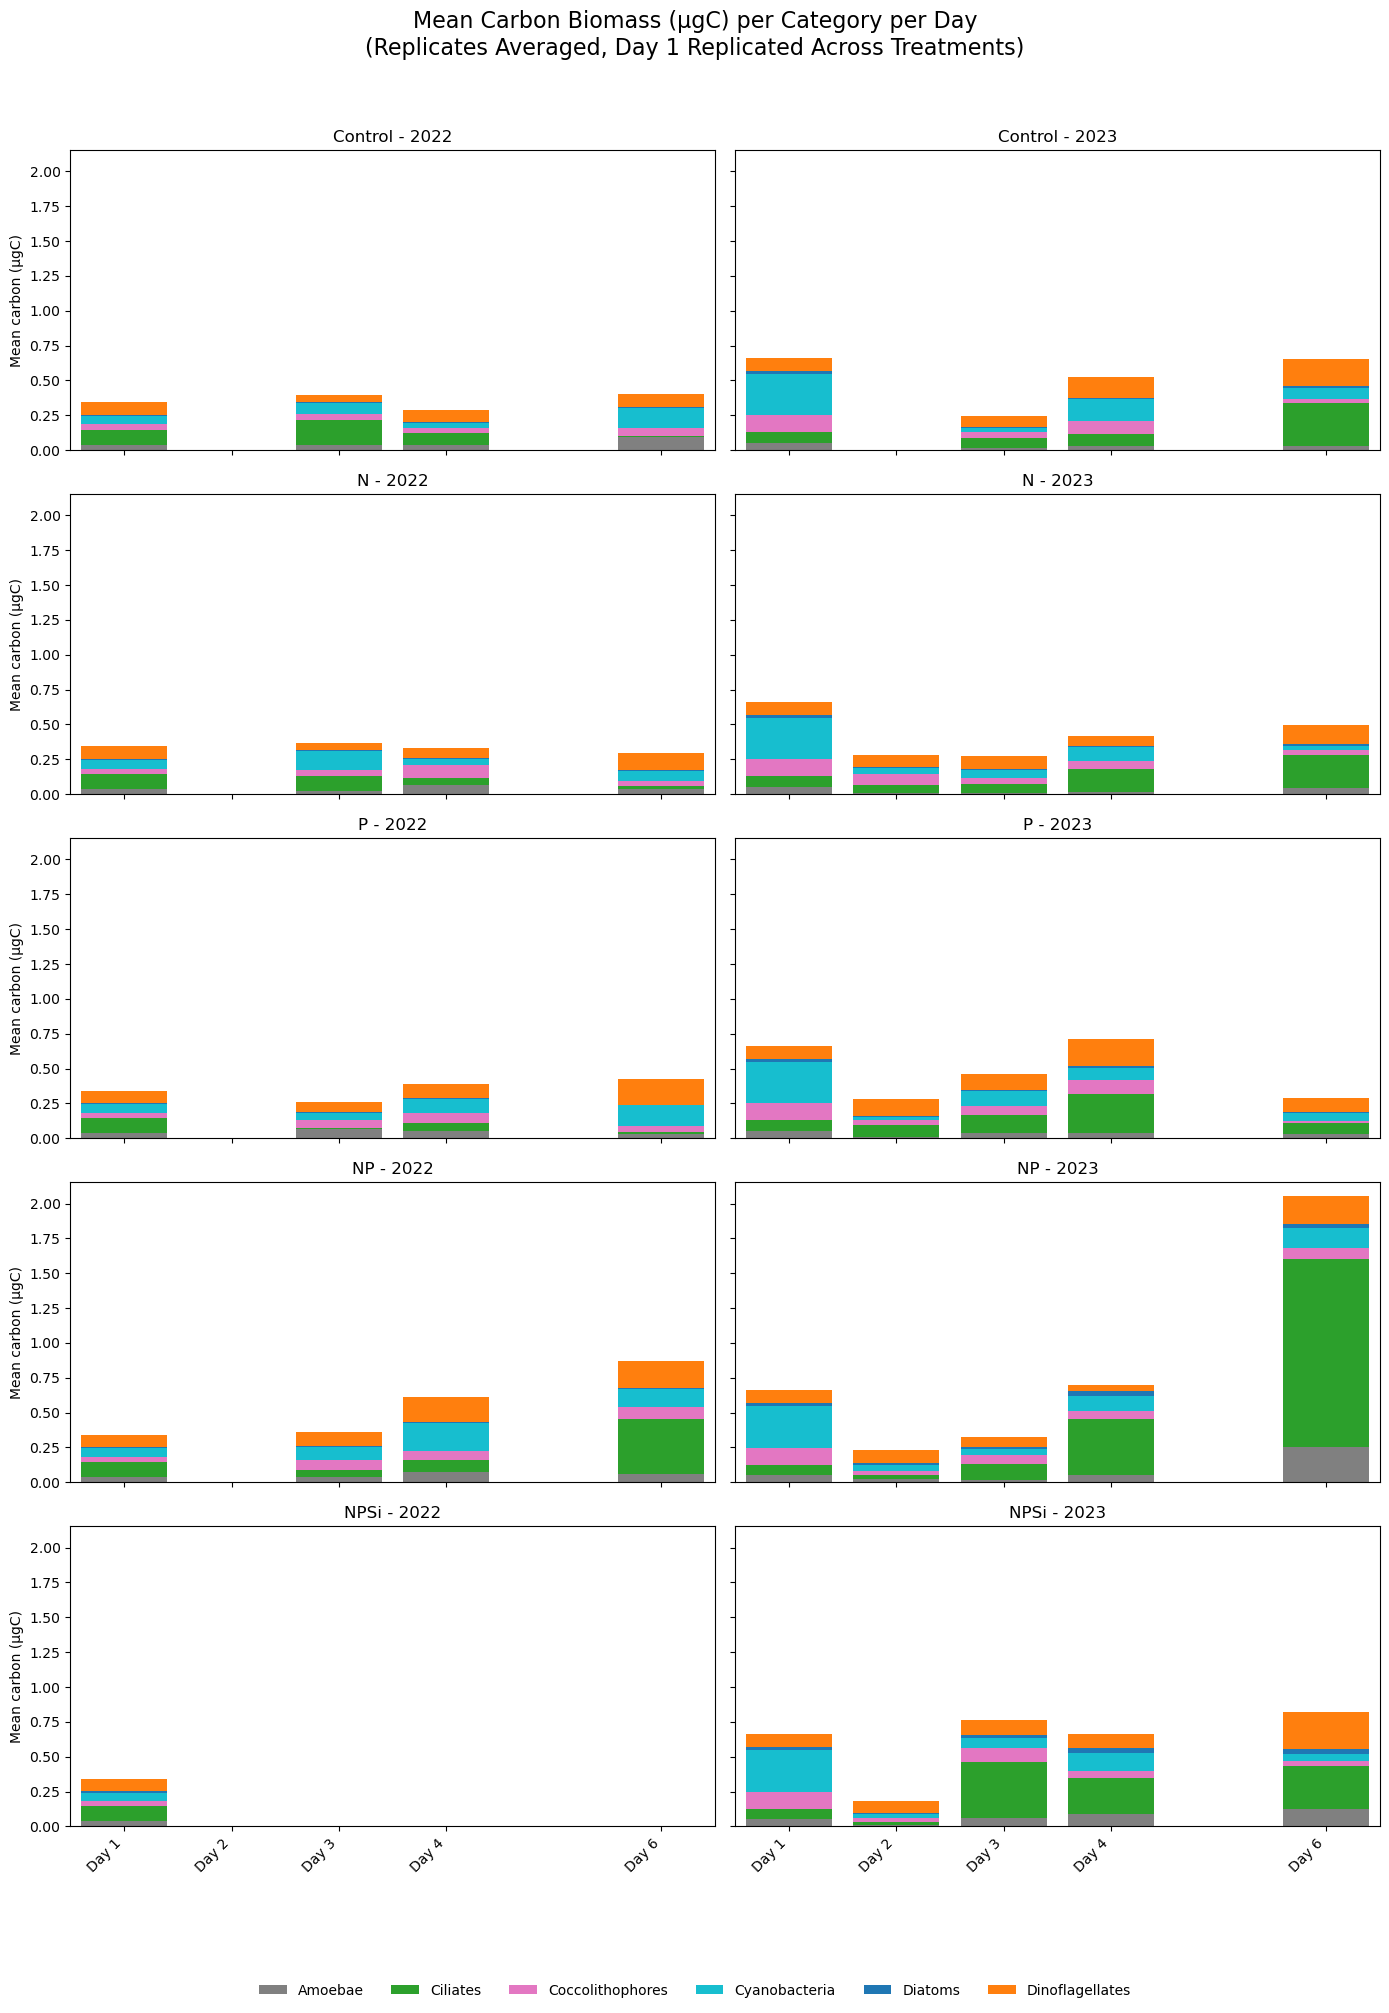

In [13]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns (CARBON this time) ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'carbon_ugC']]

# === Remove missing ===
df = df.dropna(subset=['category', 'carbon_ugC'])

# ======================================================================
# === MANUAL EXCLUSION LIST (EDIT THIS ONLY) ============================
# ======================================================================
EXCLUDE_CATEGORIES = [
     "Detritus",
     "Zooplankton",
    # "Cyanobacteria",
     "Small_phyto",
     "empty",
    # "Coccolithophores",
     "Foraminifera",
     "Radiolarians",
     "Trash",
     "Cryptomonas",
     "Raphidophytes",
    # "Other"
]
# ======================================================================

if EXCLUDE_CATEGORIES:
    df = df[~df['category'].isin(EXCLUDE_CATEGORIES)]

# === Exclude Day 7 ===
df = df[df['day'] != 7]

# ============================================================
# === NEW STEP: replicate Day 1 within each year to all treatments ===
# ============================================================

df_day1 = df[df['day'] == 1]

replicated_rows = []

for year in [2022, 2023]:
    base_day1 = df_day1[df_day1['year'] == year]
    if base_day1.empty:
        continue
    
    for treatment in ['Control', 'N', 'P', 'NP', 'NPSi']:
        temp = base_day1.copy()
        temp['treatment'] = treatment
        replicated_rows.append(temp)

df = df[df['day'] != 1]   # remove original Day 1 rows
df_day1_combined = pd.concat(replicated_rows, ignore_index=True)
df = pd.concat([df, df_day1_combined], ignore_index=True)

# ============================================================

# === Order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Color palette ===
category_palette = {
    'Diatoms':         '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates':        '#2ca02c',
    'Detritus':        '#9467bd',
    'Other':           '#8c564b',

    'Coccolithophores': '#e377c2',
    'Cyanobacteria':    '#17becf',
    'Radiolarians':     '#7f7f7f',
    'Small_phyto':      '#bcbd22',
    'Foraminifera':     '#d62728',
    'Cryptomonas':      '#aec7e8',
    'Raphidophytes':    '#ffbb78'
}

# === Global days (1–6) ===
global_days = sorted(df['day'].unique())

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure ===
fig, axes = plt.subplots(
    nrows=len(treatment_order), ncols=2,
    figsize=(14, 20),
    sharex=True, sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        # === Compute mean carbon biomass across replicates ===
        mean_grouped = (
            subset
            .groupby(['day', 'category'], observed=True)['carbon_ugC']
            .mean()
            .reset_index()
        )

        # Pivot day × category
        pivot = mean_grouped.pivot_table(
            index='day',
            columns='category',
            values='carbon_ugC',
            fill_value=0
        )

        # Align all panels to the same days
        pivot = pivot.reindex(global_days, fill_value=0)

        categories = sorted(pivot.columns)

        # X-axis = global days
        x = np.array(global_days, dtype=float)
        bottom = np.zeros(len(pivot))

        # === Plot stacked bars ===
        for category in categories:
            ax.bar(
                x,
                pivot[category].values,
                bottom=bottom,
                color=category_palette.get(category, 'gray'),
                width=0.8,
                edgecolor='none',
                linewidth=0.0,
                label=category if (i == 0 and j == 0) else ""
            )
            bottom += pivot[category].values

        # X-axis formatting
        ax.set_xticks(global_days)
        if i == len(treatment_order) - 1:
            ax.set_xticklabels([f"Day {d}" for d in global_days],
                               rotation=45, ha='right')
        else:
            ax.set_xticklabels([])

        ax.set_xlim(min(global_days) - 0.5, max(global_days) + 0.5)

        if j == 0:
            ax.set_ylabel("Mean carbon (µgC)")
        ax.set_title(f"{treatment} - {year}")

        ax.grid(False)

# === Figure title ===
fig.suptitle(
    "Mean Carbon Biomass (µgC) per Category per Day\n(Replicates Averaged, Day 1 Replicated Across Treatments)",
    fontsize=16
)

# === Legend ===
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=6,
    frameon=False
)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.show()

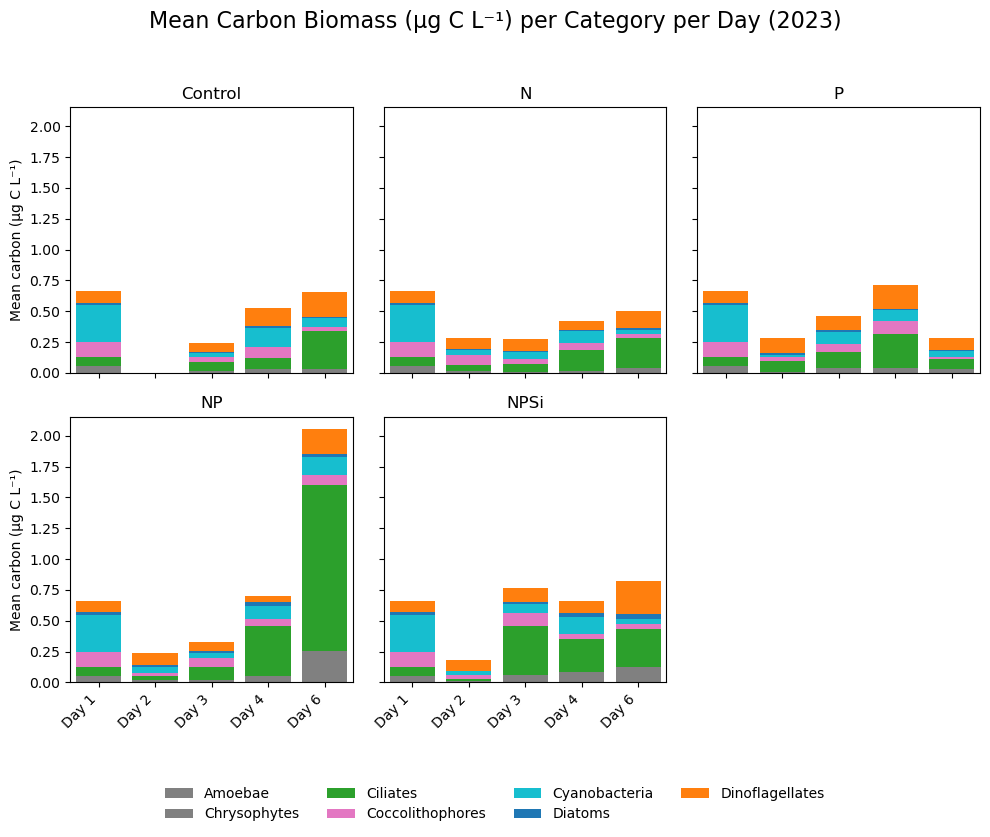

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023//5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns (CARBON this time) ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'carbon_ugC']]

# === Remove missing ===
df = df.dropna(subset=['category', 'carbon_ugC'])

# ======================================================================
# === MANUAL EXCLUSION LIST ============================================
# ======================================================================
EXCLUDE_CATEGORIES = [
    "Detritus",
    "Zooplankton",
    # "Cyanobacteria",
    "Small_phyto",
    "empty",
    # "Coccolithophores",
    "Foraminifera",
    "Radiolarians",
    "Trash",
    "Cryptomonas",
    "Raphidophytes",
    "Other"
]
# ======================================================================

if EXCLUDE_CATEGORIES:
    df = df[~df['category'].isin(EXCLUDE_CATEGORIES)]

# === ONLY KEEP YEAR 2023 ===
df = df[df['year'] == 2023]

# === Exclude Day 7 and Day 5 from the data ===
df = df[(df['day'] != 7) & (df['day'] != 5)]

# ============================================================
# === Replicate Day 1 to all treatments (2023 only) ==========
# ============================================================

df_day1 = df[df['day'] == 1]
replicated_rows = []

base_day1 = df_day1[df_day1['year'] == 2023]

if not base_day1.empty:
    for treatment in ['Control', 'N', 'P', 'NP', 'NPSi']:
        temp = base_day1.copy()
        temp['treatment'] = treatment
        replicated_rows.append(temp)

# Replace original Day 1
df = df[df['day'] != 1]
df_day1_combined = pd.concat(replicated_rows, ignore_index=True)
df = pd.concat([df, df_day1_combined], ignore_index=True)

# ============================================================

# === Order of treatments ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# === Color palette ===
category_palette = {
    'Diatoms':         '#1f77b4',
    'Dinoflagellates': '#ff7f0e',
    'Ciliates':        '#2ca02c',
    'Detritus':        '#9467bd',
    'Other':           '#8c564b',

    'Coccolithophores': '#e377c2',
    'Cyanobacteria':    '#17becf',
    'Radiolarians':     '#7f7f7f',
    'Small_phyto':      '#bcbd22',
    'Foraminifera':     '#d62728',
    'Cryptomonas':      '#aec7e8',
    'Raphidophytes':    '#ffbb78'
}

# === Days to display (categorical axis) ===
global_days = [1, 2, 3, 4, 6]
x_positions = np.arange(len(global_days))  # 0,1,2,3,4

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure: 2 rows × 3 columns (matrix layout) ===
nrows, ncols = 2, 3
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(10, 8),   # more square-ish
    sharex=True,
    sharey=True
)

axes_flat = axes.ravel()

year = 2023

for i, treatment in enumerate(treatment_order):
    ax = axes_flat[i]

    subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

    # Group & average carbon across replicates
    mean_grouped = (
        subset
        .groupby(['day', 'category'], observed=True)['carbon_ugC']
        .mean()
        .reset_index()
    )

    # Pivot day × category
    pivot = mean_grouped.pivot_table(
        index='day',
        columns='category',
        values='carbon_ugC',
        fill_value=0
    )

    # Align to requested days only (1,2,3,4,6)
    pivot = pivot.reindex(global_days, fill_value=0)

    categories = sorted(pivot.columns)

    bottom = np.zeros(len(global_days))

    for category in categories:
        values = pivot[category].values
        ax.bar(
            x_positions,
            values,
            bottom=bottom,
            color=category_palette.get(category, 'gray'),
            width=0.8,
            edgecolor='none',
            linewidth=0.0,
            label=category if i == 0 else ""
        )
        bottom += values

    # X-axis formatting: categorical positions
    ax.set_xticks(x_positions)
    ax.set_xlim(-0.5, len(global_days) - 0.5)
    ax.set_title(f"{treatment}")

    # Only bottom row with x tick labels
    if i // ncols == nrows - 1:
        ax.set_xticklabels([f"Day {d}" for d in global_days], rotation=45, ha='right')
    else:
        ax.set_xticklabels([])

    # Only left column with y label
    if i % ncols == 0:
        ax.set_ylabel("Mean carbon (µg C L⁻¹)")
    ax.grid(False)

# Turn off any unused subplot (since 2×3 = 6 and we have 5 treatments)
if len(treatment_order) < len(axes_flat):
    for k in range(len(treatment_order), len(axes_flat)):
        axes_flat[k].axis('off')

# === Figure title ===
fig.suptitle(
    "Mean Carbon Biomass (µg C L⁻¹) per Category per Day (2023)",
    fontsize=16
)

# === Legend ===
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=4,
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])

# Save as TIFF
fig.savefig(f"Mean Carbon Biomass {year}.tiff", dpi=600, bbox_inches='tight')

plt.show()

/var/folders/l1/b_46knxj1mzc269h9cdt5j280000gn/T/ipykernel_79583/1032449297.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_genera))


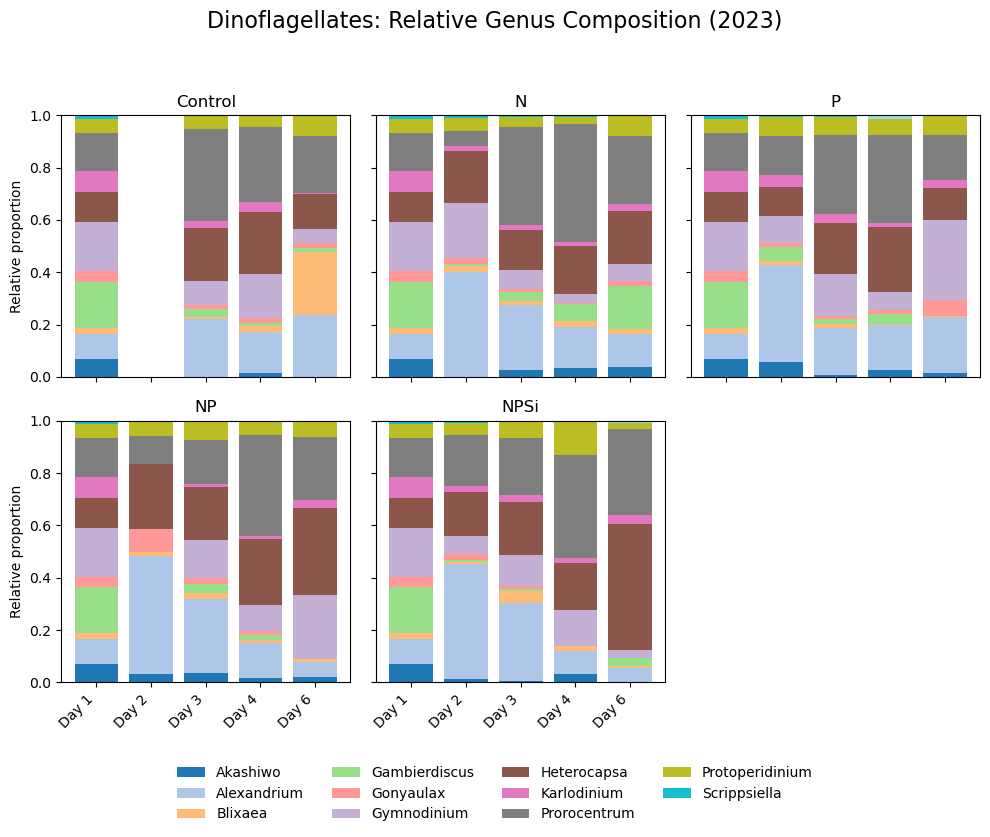

/var/folders/l1/b_46knxj1mzc269h9cdt5j280000gn/T/ipykernel_79583/1032449297.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_genera))


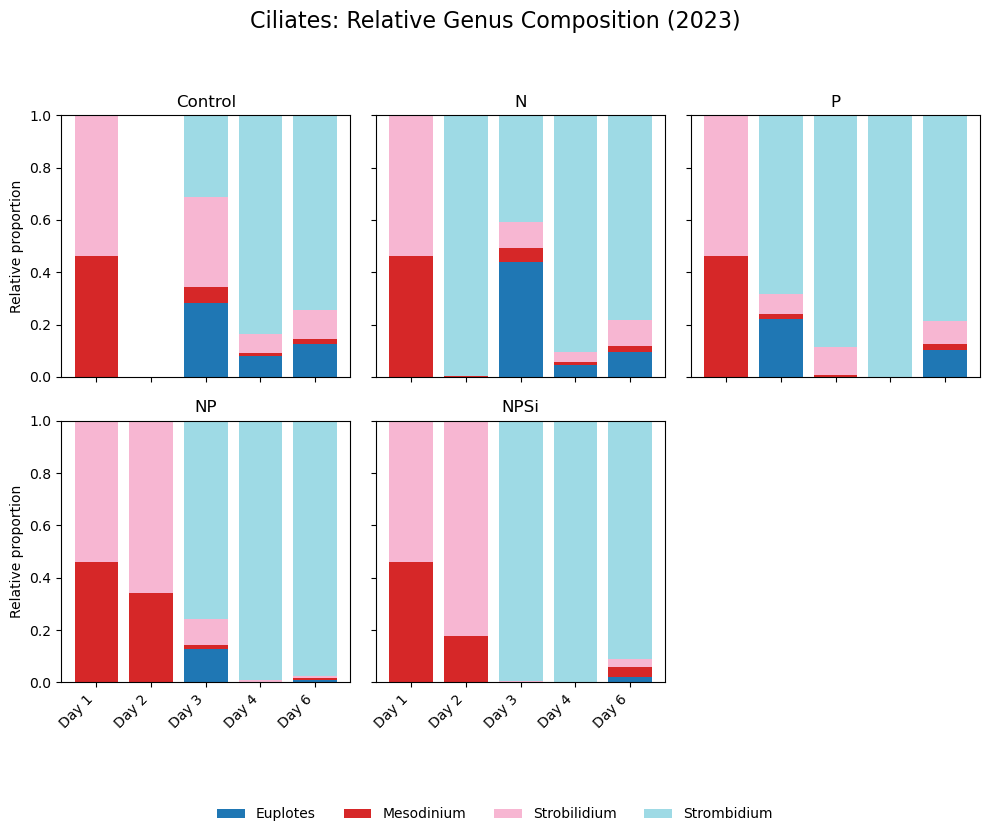

/var/folders/l1/b_46knxj1mzc269h9cdt5j280000gn/T/ipykernel_79583/1032449297.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_genera))


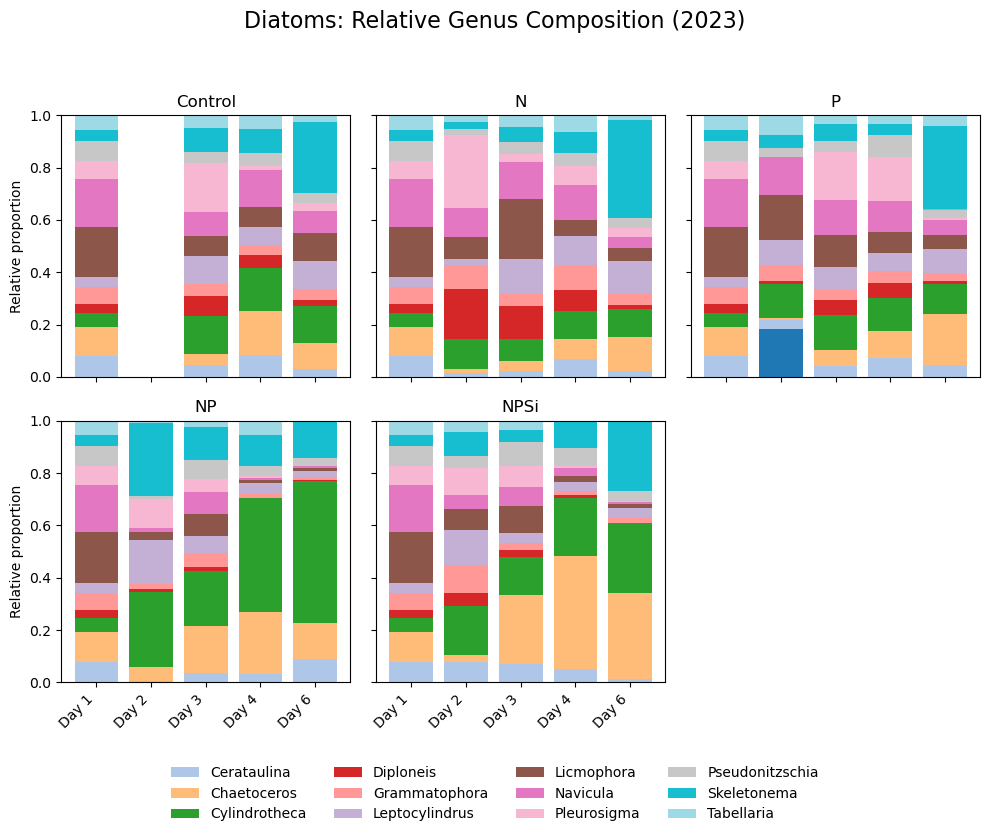

In [12]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'category', 'genus', 'carbon_ugC']]
df = df.dropna(subset=['category', 'carbon_ugC'])

# ======================================================================
# === MANUAL EXCLUSION LIST ============================================
# ======================================================================
EXCLUDE_CATEGORIES = [
    "Detritus",
    "Zooplankton",
    "Small_phyto",
    "empty",
    "Foraminifera",
    "Radiolarians",
    "Trash",
    "Cryptomonas",
    "Raphidophytes",
    "Other"
]
# ======================================================================

df = df[~df['category'].isin(EXCLUDE_CATEGORIES)]

# === ONLY KEEP YEAR 2023 ===
df = df[df['year'] == 2023]

# === Exclude Day 7 and Day 5 ===
df = df[(df['day'] != 7) & (df['day'] != 5)]

# ============================================================
# === Replicate Day 1 across all treatments ==================
# ============================================================

df_day1 = df[df['day'] == 1]
replicated_rows = []
base_day1 = df_day1[df_day1['year'] == 2023]

if not base_day1.empty:
    for treatment in ['Control', 'N', 'P', 'NP', 'NPSi']:
        temp = base_day1.copy()
        temp['treatment'] = treatment
        replicated_rows.append(temp)

df = df[df['day'] != 1]
df_day1_combined = pd.concat(replicated_rows, ignore_index=True)
df = pd.concat([df, df_day1_combined], ignore_index=True)

# === Treatment & day configuration ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
global_days = [1, 2, 3, 4, 6]
x_positions = np.arange(len(global_days))

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)


# ============================================================
# === PLOTTING FUNCTION FOR GENUS-LEVEL RELATIVE FRACTIONS ===
# ============================================================
def plot_matrix_relative(df_full, target_category, outfile):
    """
    Plot relative proportions of genera inside a category (Diatoms, Dinoflagellates, etc.)
    as stacked bars in a 2×3 matrix layout.
    """
    df_cat = df_full[df_full['category'] == target_category].copy()
    df_cat = df_cat.dropna(subset=['genus'])

    if df_cat.empty:
        print(f"No data for category {target_category}. Skipping.")
        return

    # === Generate color palette for all genera found ===
    unique_genera = sorted(df_cat['genus'].unique())
    cmap = plt.cm.get_cmap('tab20', len(unique_genera))
    genus_palette = {g: cmap(i) for i, g in enumerate(unique_genera)}

    # === Figure ===
    fig, axes = plt.subplots(
        nrows=2,
        ncols=3,
        figsize=(10, 8),
        sharex=True,
        sharey=True
    )
    axes_flat = axes.ravel()

    year = 2023

    for i, treatment in enumerate(treatment_order):
        ax = axes_flat[i]
        subset = df_cat[(df_cat['treatment'] == treatment) & (df_cat['year'] == year)]

        if subset.empty:
            ax.axis('off')
            continue

        # Sum: day × genus
        grouped = (
            subset
            .groupby(['day', 'genus'], observed=True)['carbon_ugC']
            .sum()
            .reset_index()
        )

        pivot = grouped.pivot_table(
            index='day',
            columns='genus',
            values='carbon_ugC',
            fill_value=0
        )

        # Align days
        pivot = pivot.reindex(global_days, fill_value=0)

        # Convert to relative proportions PER DAY
        pivot_rel = pivot.div(pivot.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

        bottom = np.zeros(len(global_days))

        for g in pivot_rel.columns:
            vals = pivot_rel[g].values
            ax.bar(
                x_positions,
                vals,
                bottom=bottom,
                color=genus_palette[g],
                edgecolor='none',
                width=0.8,
                label=g if i == 0 else ""
            )
            bottom += vals

        ax.set_xticks(x_positions)
        if i >= 3:  # bottom row
            ax.set_xticklabels([f"Day {d}" for d in global_days], rotation=45, ha='right')
        else:
            ax.set_xticklabels([])

        if i % 3 == 0:  # left column
            ax.set_ylabel("Relative proportion")

        ax.set_ylim(0, 1)
        ax.set_title(treatment)
        ax.grid(False)

    # Turn off unused panel
    for k in range(len(treatment_order), 6):
        axes_flat[k].axis('off')

    fig.suptitle(
        f"{target_category}: Relative Genus Composition (2023)",
        fontsize=16
    )

    # Legend
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.05),
        ncol=4,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0.06, 1, 0.94])
    fig.savefig(os.path.join(output_dir, outfile), dpi=600, bbox_inches='tight')
    plt.show()


# ============================================================
# === GENERATE THE THREE MATRIX FIGURES ======================
# ============================================================

plot_matrix_relative(df, "Dinoflagellates", "Dinoflagellates_Relative_Genus_2023.tiff")

plot_matrix_relative(df, "Ciliates", "Ciliates_Relative_Genus_2023.tiff")

plot_matrix_relative(df, "Diatoms", "Diatoms_Relative_Genus_2023.tiff")

## Morphometry visualization and table (Average values per taxon and category)

### Create tables

In [16]:
import sqlite3
import pandas as pd
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Select necessary columns ===
cols_to_keep = [
    'class_name', 'phylum', 'class', 'order', 'family', 'genus', 'taxon_name', 'category',
    'Area', 'Biovolume', 'MajorAxisLength', 'MinorAxisLength', 'probability', 'volume_um3', 'carbon_pgC'
]

df = df[cols_to_keep]

# === Create carbon_ugC ===
df['carbon_ugC'] = df['carbon_pgC'] / 1e6

# === Remove rows with missing taxon_name or essential numeric fields ===
df = df.dropna(subset=['taxon_name', 'Area', 'Biovolume', 'volume_um3', 'carbon_pgC'])

# === Define pixel to micron conversion factors ===
PIXEL_TO_UM3 = 0.422
PIXEL_TO_UM2 = PIXEL_TO_UM3 ** (2/3)  # ≈ 0.650
PIXEL_TO_UM = PIXEL_TO_UM3 ** (1/3)   # ≈ 0.812

# === Convert pixel-based measurements to microns ===
df['Area'] = df['Area'] * PIXEL_TO_UM2
df['Biovolume'] = df['Biovolume'] * PIXEL_TO_UM3
df['MajorAxisLength'] = df['MajorAxisLength'] * PIXEL_TO_UM
df['MinorAxisLength'] = df['MinorAxisLength'] * PIXEL_TO_UM

# === Variables to summarize ===
numeric_vars = [
    'Area', 'Biovolume', 'MajorAxisLength', 'MinorAxisLength',
    'probability', 'volume_um3', 'carbon_pgC', 'carbon_ugC'
]

# === Define basic aggregation: text columns + mean of numeric columns ===
aggregation = {
    'phylum': 'first',
    'class': 'first',
    'order': 'first',
    'family': 'first',
    'genus': 'first',
    'taxon_name': 'first',
    'category': 'first'
}
aggregation.update({var: 'mean' for var in numeric_vars})

# === Group by class_name (calculate means) ===
grouped_by_class = df.groupby('class_name', observed=True).agg(aggregation)

# === Calculate StdDev and StdErr separately ===
stddev = df.groupby('class_name', observed=True)[numeric_vars].std()
stderr = stddev.divide(df.groupby('class_name', observed=True)[numeric_vars].count().pow(0.5))

# === Rename columns to _StdDev and _StdErr ===
stddev = stddev.rename(columns={col: f"{col}_StdDev" for col in stddev.columns})
stderr = stderr.rename(columns={col: f"{col}_StdErr" for col in stderr.columns})

# === Merge everything together ===
grouped_by_class = pd.concat([grouped_by_class, stddev, stderr], axis=1).reset_index()

# === Group by category ===
# First, remove 'category' from aggregation to avoid duplication
aggregation_no_category = aggregation.copy()
aggregation_no_category.pop('category')

grouped_by_category = df.groupby('category', observed=True).agg(aggregation_no_category)

stddev_cat = df.groupby('category', observed=True)[numeric_vars].std()
stderr_cat = stddev_cat.divide(df.groupby('category', observed=True)[numeric_vars].count().pow(0.5))

stddev_cat = stddev_cat.rename(columns={col: f"{col}_StdDev" for col in stddev_cat.columns})
stderr_cat = stderr_cat.rename(columns={col: f"{col}_StdErr" for col in stderr_cat.columns})

grouped_by_category = pd.concat([grouped_by_category, stddev_cat, stderr_cat], axis=1).reset_index()

# === Drop unnecessary columns from category summary ===
columns_to_drop = ['phylum', 'class', 'order', 'family', 'genus', 'taxon_name']
grouped_by_category = grouped_by_category.drop(columns=columns_to_drop, errors='ignore')

# === Round all numerical columns to 3 decimals ===
grouped_by_class = grouped_by_class.round(3)
grouped_by_category = grouped_by_category.round(3)

# === Save outputs ===
output_dir = "03_datasets/Ishigaki2023/morphometry"
os.makedirs(output_dir, exist_ok=True)

output_path_class = os.path.join(output_dir, "average_morphometry_and_carbon_per_class.csv")
output_path_category = os.path.join(output_dir, "average_morphometry_and_carbon_per_category.csv")

grouped_by_class.to_csv(output_path_class, index=False)
grouped_by_category.to_csv(output_path_category, index=False)

print(f"Summary table by class saved to: {output_path_class}")
print(f"Summary table by category saved to: {output_path_category}")

Summary table by class saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_class.csv
Summary table by category saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_category.csv


### Create figures (choose variable to plot)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


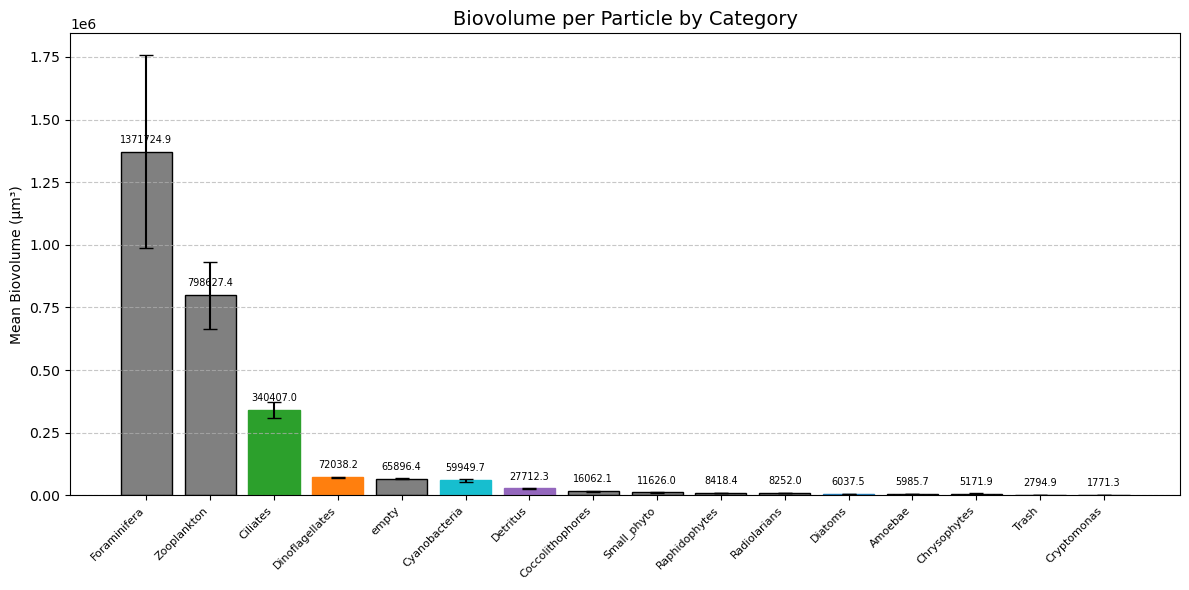

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


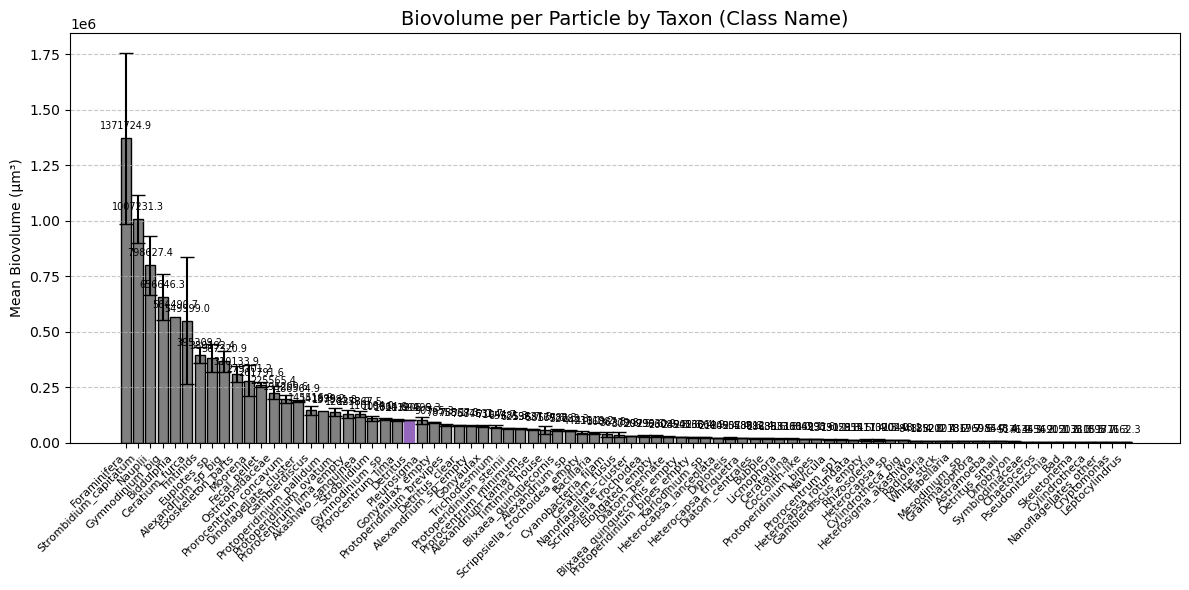

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# === Load the grouped data ===
input_dir = "03_datasets/Ishigaki2023/morphometry"

df_class = pd.read_csv(os.path.join(input_dir, "average_morphometry_and_carbon_per_class.csv"))
df_category = pd.read_csv(os.path.join(input_dir, "average_morphometry_and_carbon_per_category.csv"))

# === Manual switch: choose variable to plot ===
# Options: 'carbon_pgC', 'MajorAxisLength', 'MinorAxisLength', 'Biovolume', 'Area', 'probability'
variable_to_plot = 'Biovolume'

# === Setup automatic labeling based on variable ===
y_labels = {
    'carbon_pgC': "Mean Carbon per Particle (pgC cell⁻¹)",
    'MajorAxisLength': "Mean Major Axis Length (µm)",
    'MinorAxisLength': "Mean Minor Axis Length (µm)",
    'Biovolume': "Mean Biovolume (µm³)",
    'Area': "Mean Area (µm²)",
    'probability': "Mean Classification Probability"
}

titles = {
    'carbon_pgC': "Carbon Content per Particle",
    'MajorAxisLength': "Major Axis Length per Particle",
    'MinorAxisLength': "Minor Axis Length per Particle",
    'Biovolume': "Biovolume per Particle",
    'Area': "Area per Particle",
    'probability': "Classification Probability per Particle"
}

# === Function to create the bar plot ===
def plot_variable(df, group_col, title_suffix, output_name):
    # Sort by selected variable descending
    df_sorted = df.sort_values(variable_to_plot, ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(
        df_sorted[group_col],
        df_sorted[variable_to_plot],
        yerr=df_sorted.get(f"{variable_to_plot}_StdErr"),
        capsize=5,
        color='gray',
        edgecolor='black'
    )
    
    # Highlight a few categories if you want (optional)
    highlight = {
        'Diatoms': '#1f77b4',
        'Dinoflagellates': '#ff7f0e',
        'Ciliates': '#2ca02c',
        'Detritus': '#9467bd',
        'Cyanobacteria': '#17becf'
    }
    for bar, label in zip(bars, df_sorted[group_col]):
        if label in highlight:
            bar.set_color(highlight[label])
    
    ax.set_ylabel(y_labels[variable_to_plot])
    ax.set_title(f"{titles[variable_to_plot]} by {title_suffix}", fontsize=14)
    ax.set_xticks(range(len(df_sorted)))
    ax.set_xticklabels(df_sorted[group_col], rotation=45, ha='right', fontsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Annotate value on top
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    
    output_dir = os.path.join(input_dir, "FIGURES")
    os.makedirs(output_dir, exist_ok=True)
    
    fig.savefig(os.path.join(output_dir, f"{output_name}.tiff"), dpi=600, bbox_inches='tight')
    fig.savefig(os.path.join(output_dir, f"{output_name}.eps"), bbox_inches='tight')
    plt.show()

# === Plot per CATEGORY ===
plot_variable(
    df=df_category,
    group_col='category',
    title_suffix='Category',
    output_name=f'{variable_to_plot}_per_category'
)

# === Plot per TAXON (class_name) ===
plot_variable(
    df=df_class,
    group_col='class_name',
    title_suffix='Taxon (Class Name)',
    output_name=f'{variable_to_plot}_per_taxon'
)

### Step 5B 

In [19]:
import sqlite3
import pandas as pd
import numpy as np
import os

# === Load replicate-level data from Step 5A ===
input_db = "03_datasets/Ishigaki2023/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
rep_df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Drop unnecessary columns ===
rep_df = rep_df.drop(columns=['file_name', 'effective_volume_L', 'particles', 'carbon_ugC'], errors='ignore')

# === Define grouping and variables ===
group_cols = ['year', 'day', 'treatment', 'taxon_name']

# Only numerical variables available at replicate-level
numeric_vars = ['abundance_per_L', 'carbon_ugC_per_L']

# Metadata fields
metadata_cols = [
    'phylum', 'order', 'family', 'genus', 'taxon_name', 'class_name',
    'category', 'organism_type', 'feeding_mode', 'toxins'
]

# === Basic aggregation: mean values ===
grouped_mean = rep_df.groupby(group_cols, observed=True).agg({var: 'mean' for var in numeric_vars})

# === Standard deviation and standard error ===
grouped_std = rep_df.groupby(group_cols, observed=True).agg({var: 'std' for var in numeric_vars})
grouped_count = rep_df.groupby(group_cols, observed=True).agg({var: 'count' for var in numeric_vars})
grouped_se = grouped_std.divide(grouped_count.pow(0.5))

# === Rename std and stderr columns ===
grouped_std = grouped_std.rename(columns={col: f"{col}_StdDev" for col in grouped_std.columns})
grouped_se = grouped_se.rename(columns={col: f"{col}_StdErr" for col in grouped_se.columns})

# === Merge mean, stddev, stderr into one table ===
final_grouped = pd.concat([grouped_mean, grouped_std, grouped_se], axis=1).reset_index()

# === Clean metadata to avoid duplicated 'taxon_name' ===
metadata_cols_clean = [col for col in metadata_cols if col not in group_cols]

# === Merge back metadata ===
meta = rep_df[group_cols + metadata_cols_clean].drop_duplicates(subset=group_cols)
final_table = final_grouped.merge(meta, on=group_cols, how='left')

# === Reorder columns nicely ===
ordered_cols = [
    'year', 'day', 'treatment', 'taxon_name', 'phylum', 'class_name', 'order', 'family', 'genus',
    'category', 'organism_type', 'feeding_mode', 'toxins',
    'abundance_per_L', 'abundance_per_L_StdDev', 'abundance_per_L_StdErr',
    'carbon_ugC_per_L', 'carbon_ugC_per_L_StdDev', 'carbon_ugC_per_L_StdErr'
]
# Keep only available columns
final_table = final_table[[col for col in ordered_cols if col in final_table.columns]]

# === Round all numerical values to 3 decimals ===
#num_cols = final_table.select_dtypes(include=[np.number]).columns
#final_table[num_cols] = final_table[num_cols].round(3)

# === Save output as SQL database ===
output_dir = "03_datasets/Ishigaki2023/"  # Current directory where script is run
output_db = os.path.join(output_dir, "5B_C_biomass_merged_samples.db")

conn_out = sqlite3.connect(output_db)
final_table.to_sql("C_biomass_merged_samples", conn_out, if_exists="replace", index=False)
conn_out.close()

print(f"Step 5B completed! Final sample-level summary saved as SQL database at: {output_db}")

Step 5B completed! Final sample-level summary saved as SQL database at: 03_datasets/Ishigaki2023/5B_C_biomass_merged_samples.db


# Particle sizes

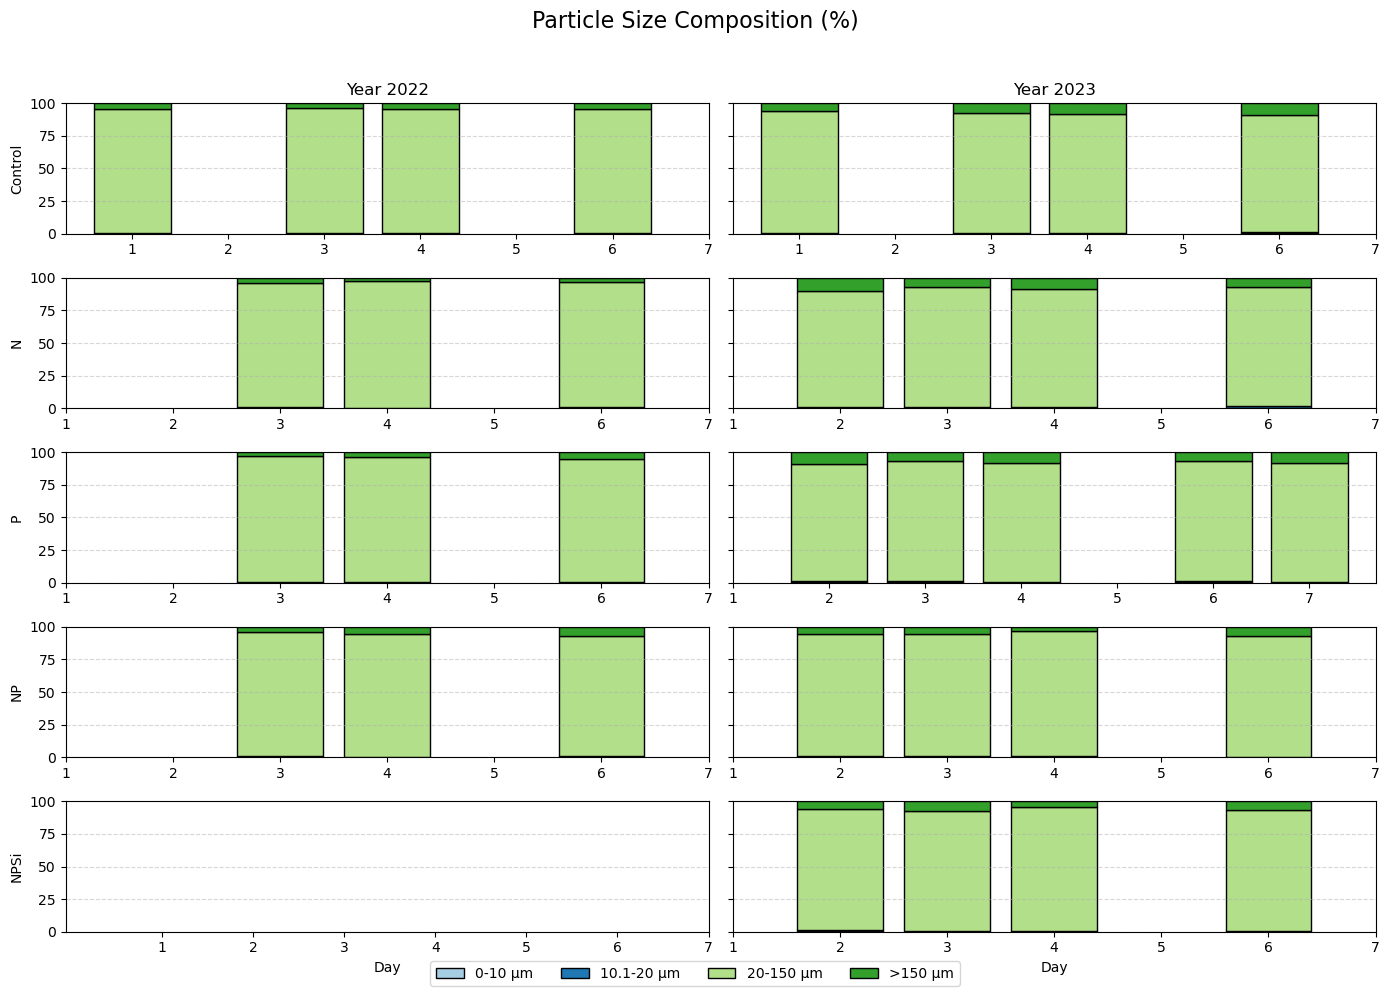

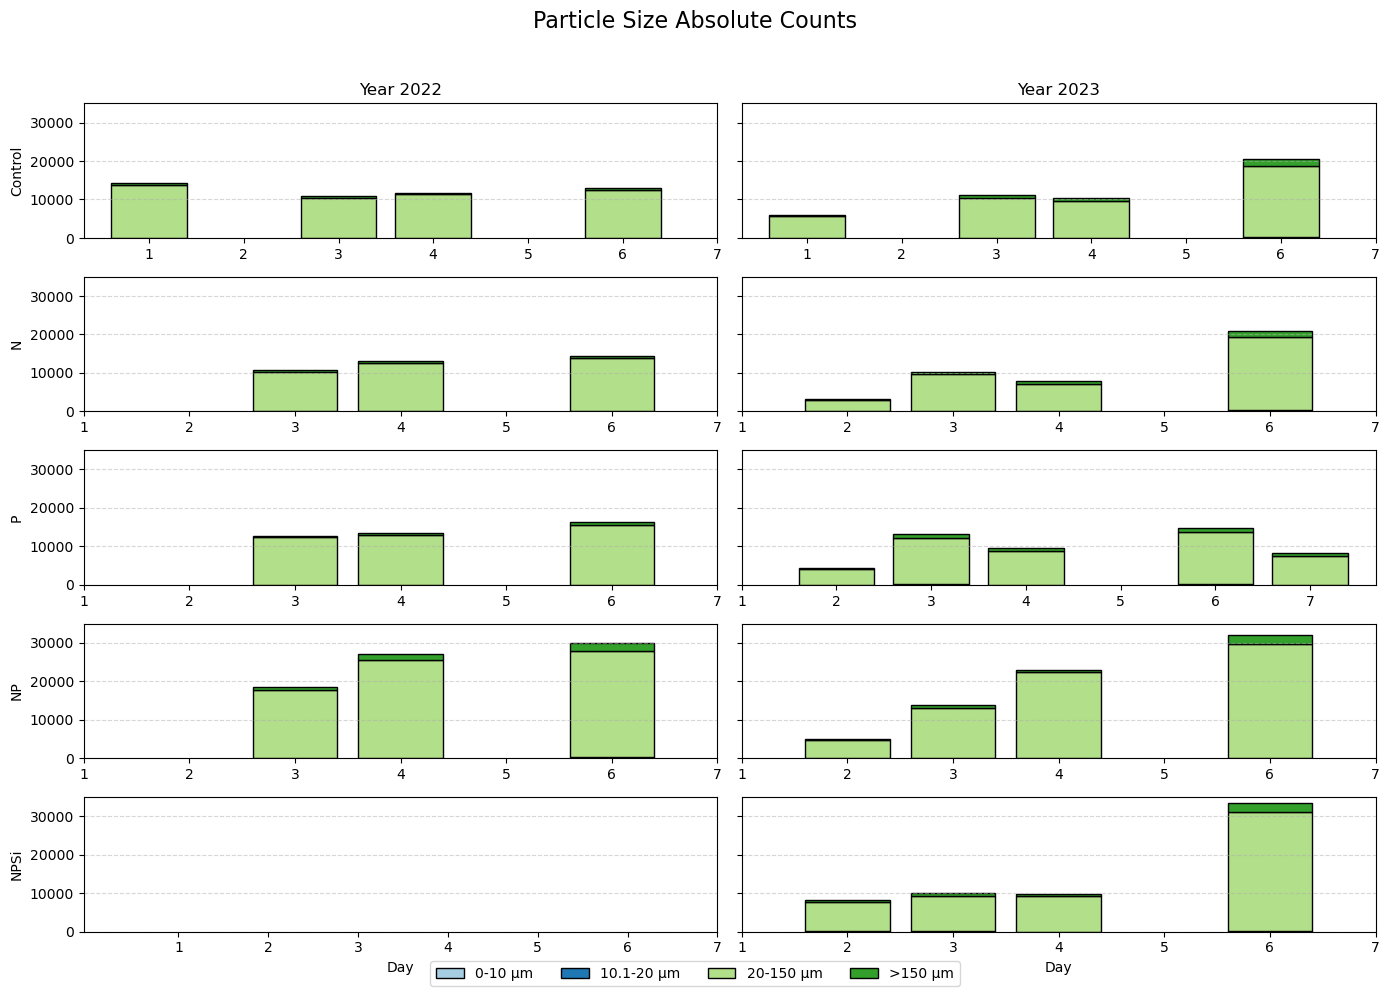

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'MajorAxisLength']]

# === Define Size Classes based on MajorAxisLength ===
def assign_size_class(length):
    if length <= 10:
        return "0-10 µm"
    elif 10 < length <= 20:
        return "10.1-20 µm"
    elif 20 < length <= 150:
        return "20-150 µm"
    else:
        return ">150 µm"

df['Size_Class'] = df['MajorAxisLength'].apply(assign_size_class)

# === Step 1: Count particles per Size Class per sample ===
grouped = df.groupby(['year', 'day', 'treatment', 'Size_Class'], observed=True).size().reset_index(name='particle_count')

# === Step 2: Pivot to wide format (one row per sample) ===
pivot_table = grouped.pivot_table(
    index=['year', 'day', 'treatment'],
    columns='Size_Class',
    values='particle_count',
    fill_value=0
).reset_index()

# Fill missing columns (in case some Size Classes are missing)
for size_class in ["0-10 µm", "10.1-20 µm", "20-150 µm", ">150 µm"]:
    if size_class not in pivot_table.columns:
        pivot_table[size_class] = 0

# === Step 3: Calculate total particles per sample and percent composition ===
pivot_table['Total'] = pivot_table[["0-10 µm", "10.1-20 µm", "20-150 µm", ">150 µm"]].sum(axis=1)
for size_class in ["0-10 µm", "10.1-20 µm", "20-150 µm", ">150 µm"]:
    pivot_table[f'{size_class}_percent'] = (pivot_table[size_class] / pivot_table['Total']) * 100

# === Step 4: Create plots ===

# === Settings ===
size_order = ["0-10 µm", "10.1-20 µm", "20-150 µm", ">150 µm"]
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
year_order = sorted(df['year'].unique())

colors = {
    "0-10 µm": "#a6cee3",
    "10.1-20 µm": "#1f78b4",
    "20-150 µm": "#b2df8a",
    ">150 µm": "#33a02c"
}

# === Step 4A: Percent Composition Plot ===
fig, axes = plt.subplots(len(treatment_order), len(year_order), figsize=(14, 10), sharey=True)

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(year_order):
        ax = axes[i, j]
        
        subset = pivot_table[(pivot_table['treatment'] == treatment) & (pivot_table['year'] == year)]
        subset = subset.sort_values('day')
        
        bottoms = np.zeros(len(subset))
        for size in size_order:
            ax.bar(
                subset['day'],
                subset[f'{size}_percent'],
                bottom=bottoms,
                label=size if (i == 0 and j == 0) else "",
                color=colors[size],
                edgecolor='black'
            )
            bottoms += subset[f'{size}_percent'].values
        
        if i == len(treatment_order) - 1:
            ax.set_xlabel("Day")
        if j == 0:
            ax.set_ylabel(f"{treatment}")
        if i == 0:
            ax.set_title(f"Year {year}")
        
        ax.set_ylim(0, 100)
        ax.set_xticks(range(1, 8))
        ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle("Particle Size Composition (%)", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.legend(size_order, loc='lower center', ncol=4)


# fig.savefig("Particle_Size_Composition_Percent.tiff", dpi=600, bbox_inches='tight')
# fig.savefig("Particle_Size_Composition_Percent.eps", bbox_inches='tight')

plt.show()

# === Step 4B: Absolute Counts Plot ===
fig, axes = plt.subplots(len(treatment_order), len(year_order), figsize=(14, 10), sharey=True)

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(year_order):
        ax = axes[i, j]
        
        subset = pivot_table[(pivot_table['treatment'] == treatment) & (pivot_table['year'] == year)]
        subset = subset.sort_values('day')
        
        bottoms = np.zeros(len(subset))
        for size in size_order:
            ax.bar(
                subset['day'],
                subset[size],
                bottom=bottoms,
                label=size if (i == 0 and j == 0) else "",
                color=colors[size],
                edgecolor='black'
            )
            bottoms += subset[size].values
        
        if i == len(treatment_order) - 1:
            ax.set_xlabel("Day")
        if j == 0:
            ax.set_ylabel(f"{treatment}")
        if i == 0:
            ax.set_title(f"Year {year}")
        
        ax.set_xticks(range(1, 8))
        ax.grid(axis='y', linestyle='--', alpha=0.5)

fig.suptitle("Particle Size Absolute Counts", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.legend(size_order, loc='lower center', ncol=4)


# fig.savefig("Particle_Size_Composition_Absolute.tiff", dpi=600, bbox_inches='tight')
# fig.savefig("Particle_Size_Composition_Absolute.eps", bbox_inches='tight')

plt.show()

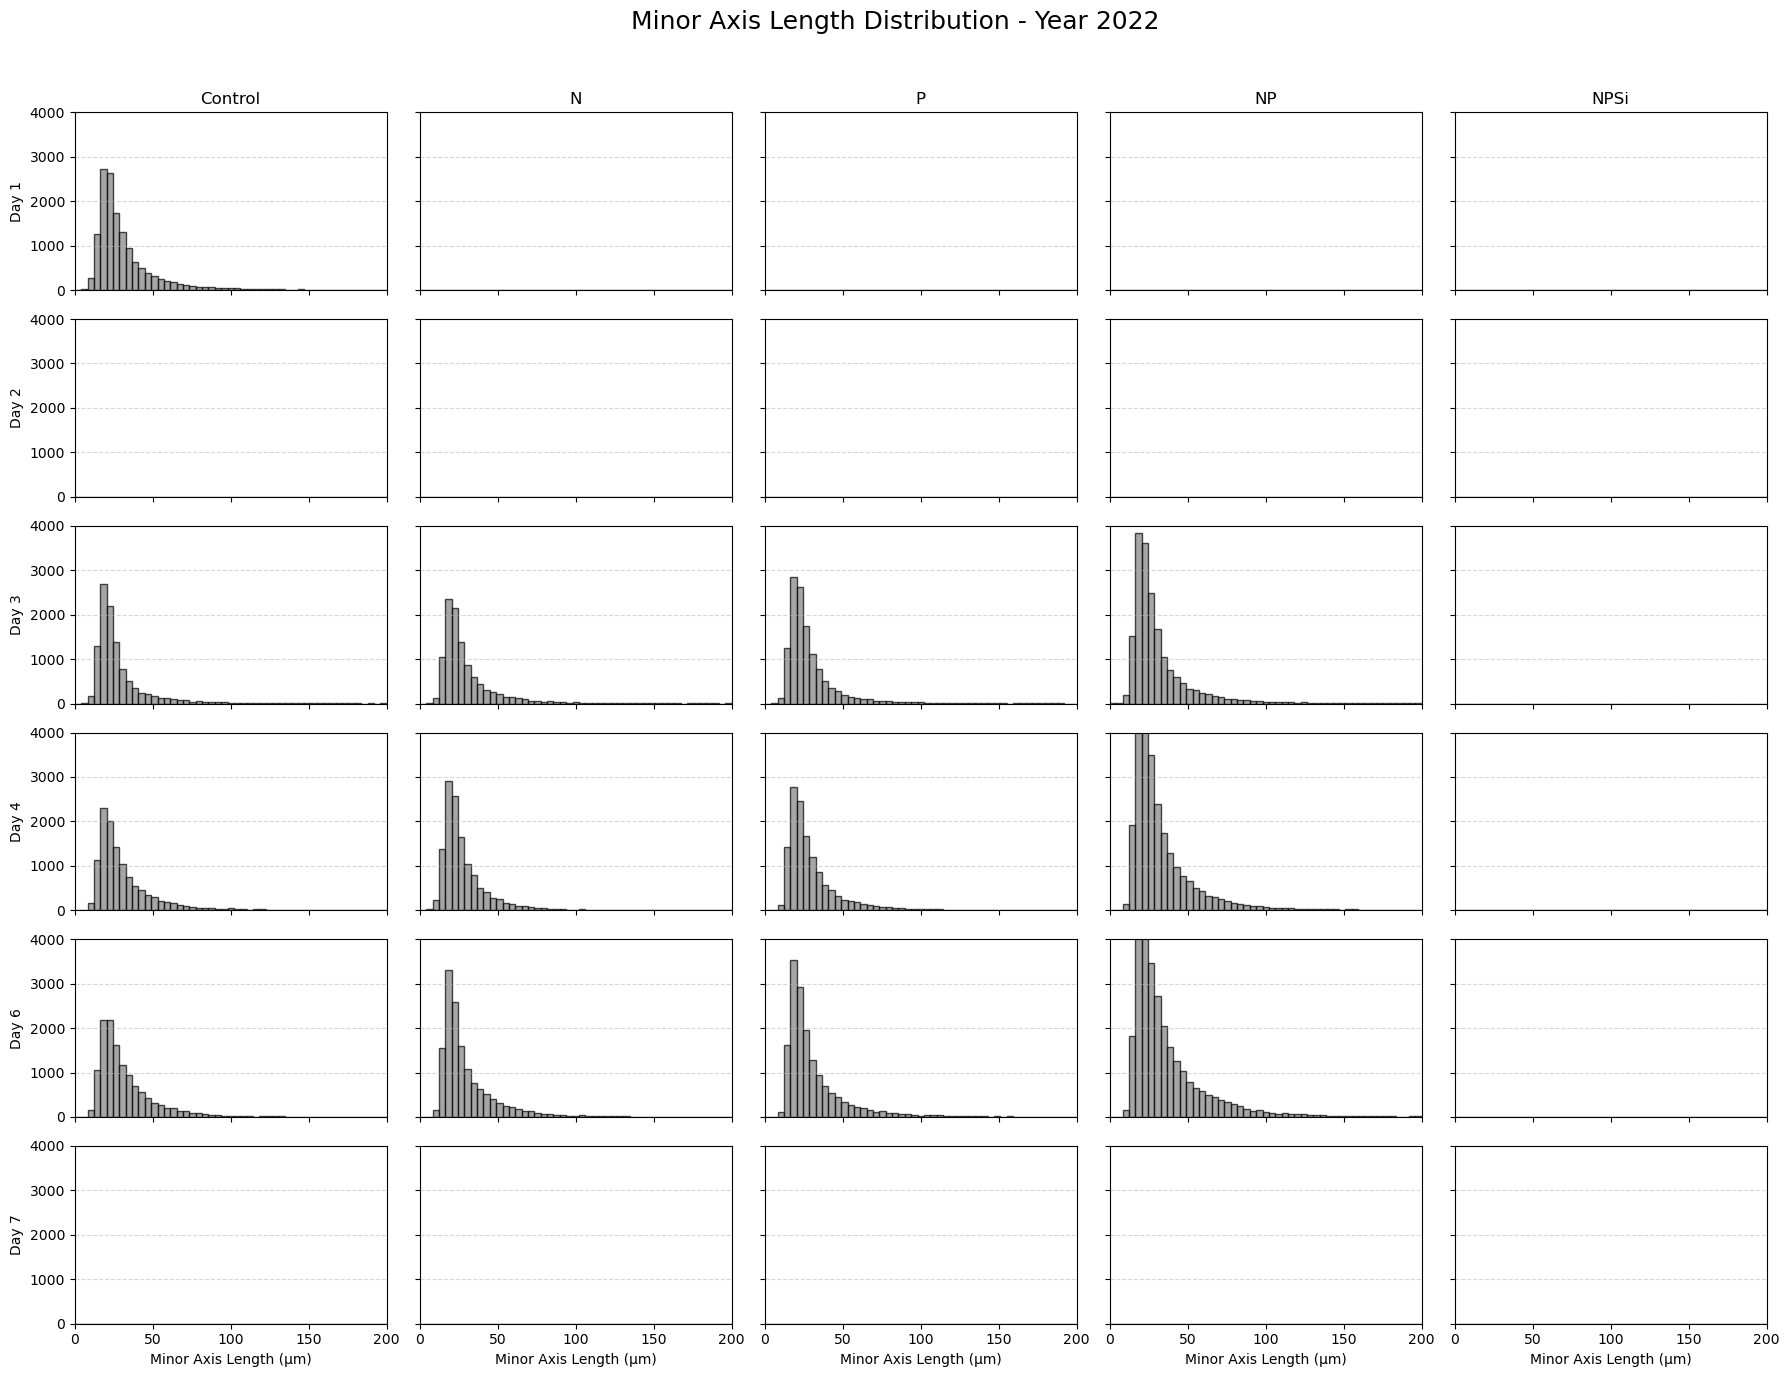

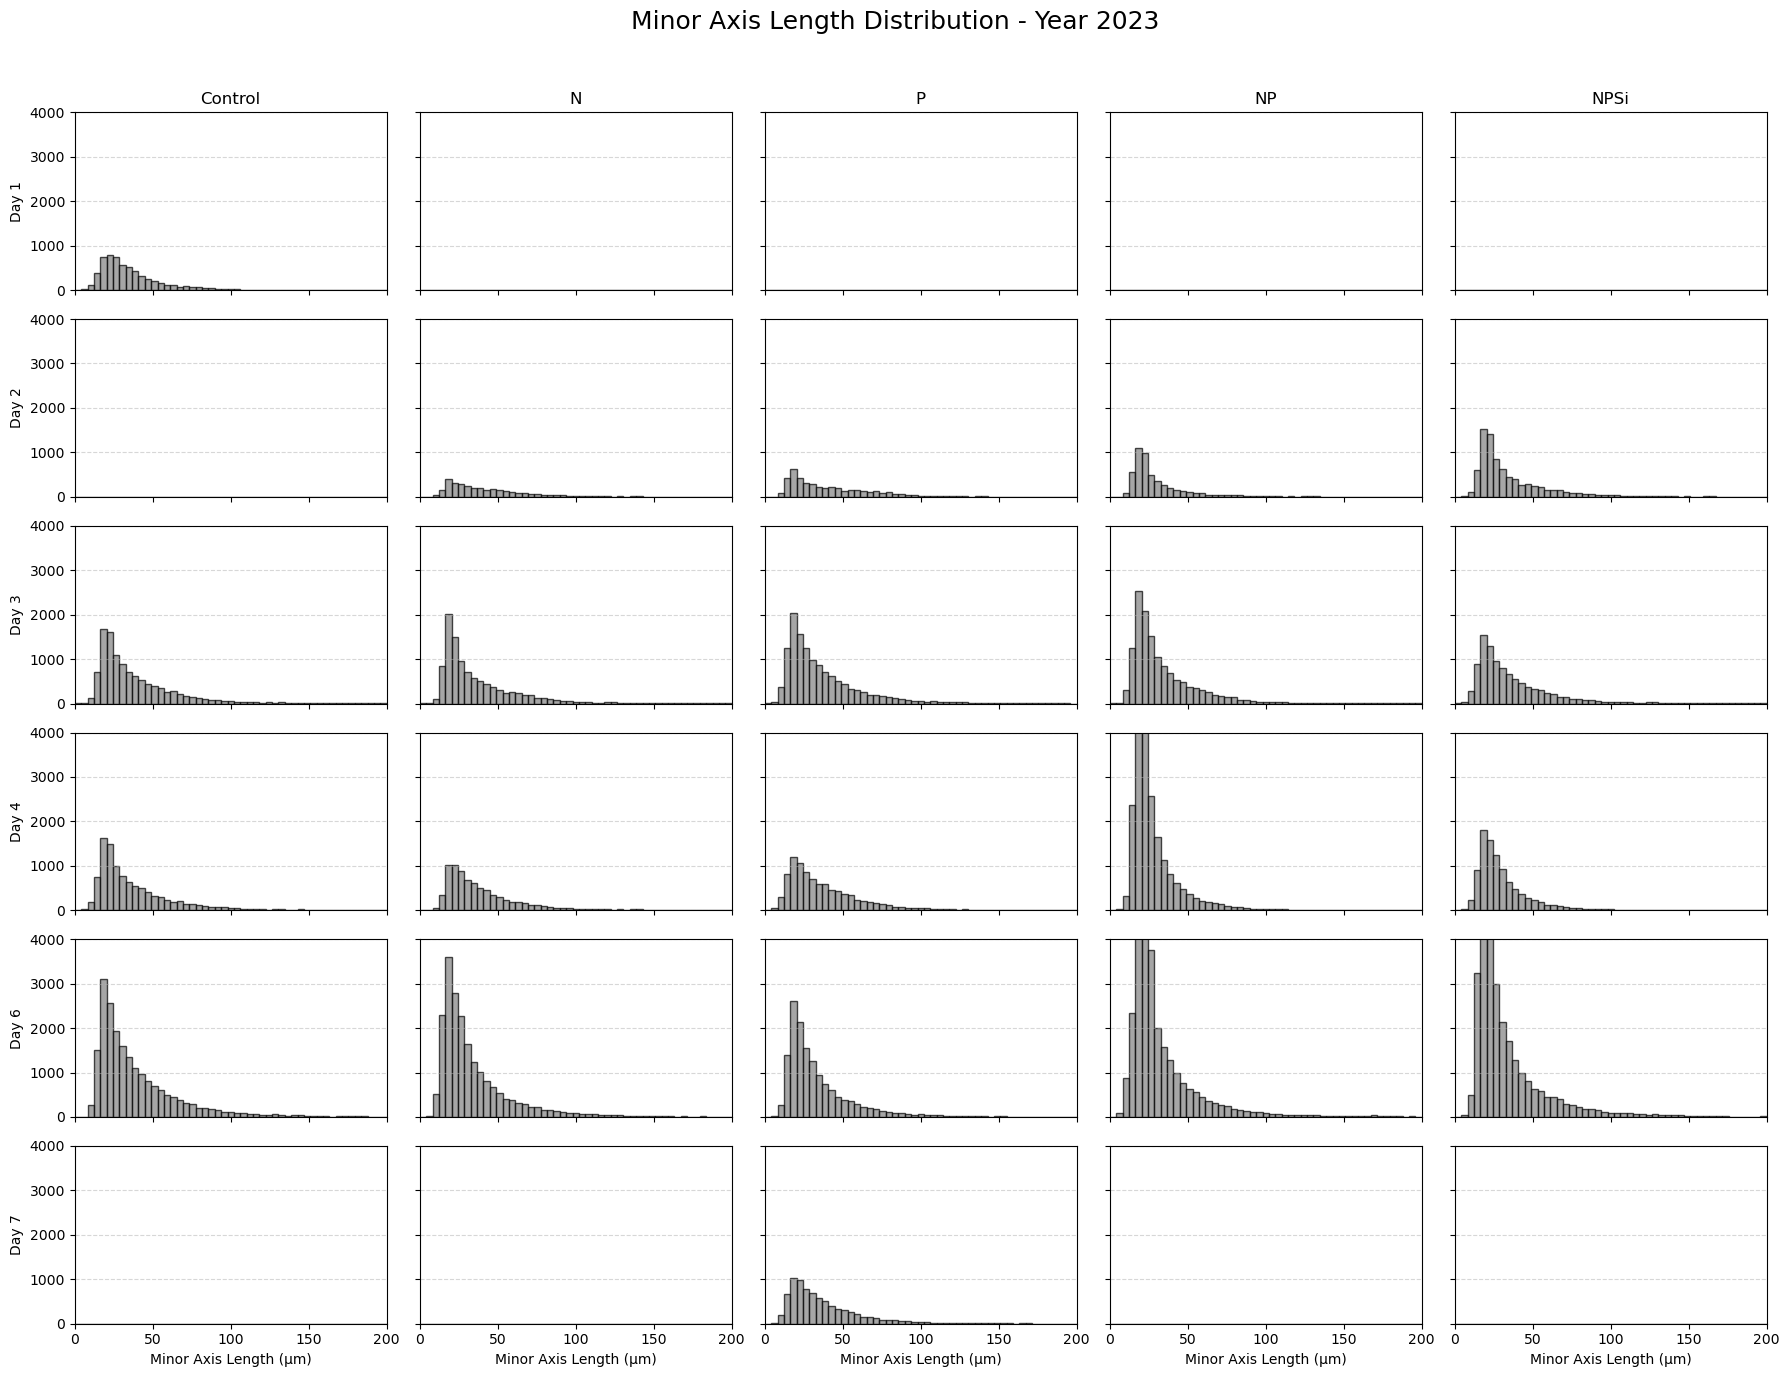

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'MinorAxisLength']]

# === Filter reasonable MinorAxisLength values if needed ===
df = df[(df['MinorAxisLength'] > 0) & (df['MinorAxisLength'] < 500)]  # optional cleanup

# === Define plotting settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
day_order = sorted(df['day'].unique())
year_order = sorted(df['year'].unique())

bins = np.linspace(0, 200, 50)  # Bins from 0 to 200 µm

# === Create one matrix of histograms per year ===
for year in year_order:
    df_year = df[df['year'] == year]
    
    fig, axes = plt.subplots(len(day_order), len(treatment_order), figsize=(18, 14), sharex=True, sharey=True)
    
    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]
            
            subset = df_year[(df_year['day'] == day) & (df_year['treatment'] == treatment)]
            ax.hist(subset['MinorAxisLength'], bins=bins, color='gray', edgecolor='black', alpha=0.7)
            ax.set_xlim(0, 200)
            ax.set_ylim(0, 4000)
            
            if i == len(day_order) - 1:
                ax.set_xlabel("Minor Axis Length (µm)")
            if j == 0:
                ax.set_ylabel(f"Day {day}")
            
            if i == 0:
                ax.set_title(treatment)
            
            ax.grid(axis='y', linestyle='--', alpha=0.5)

    fig.suptitle(f"Minor Axis Length Distribution - Year {year}", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    # === Commented Save ===
    # fig.savefig(f"MinorAxisLength_Histograms_{year}.tiff", dpi=600, bbox_inches='tight')
    # fig.savefig(f"MinorAxisLength_Histograms_{year}.eps", bbox_inches='tight')

    plt.show()

## EquivDiameter

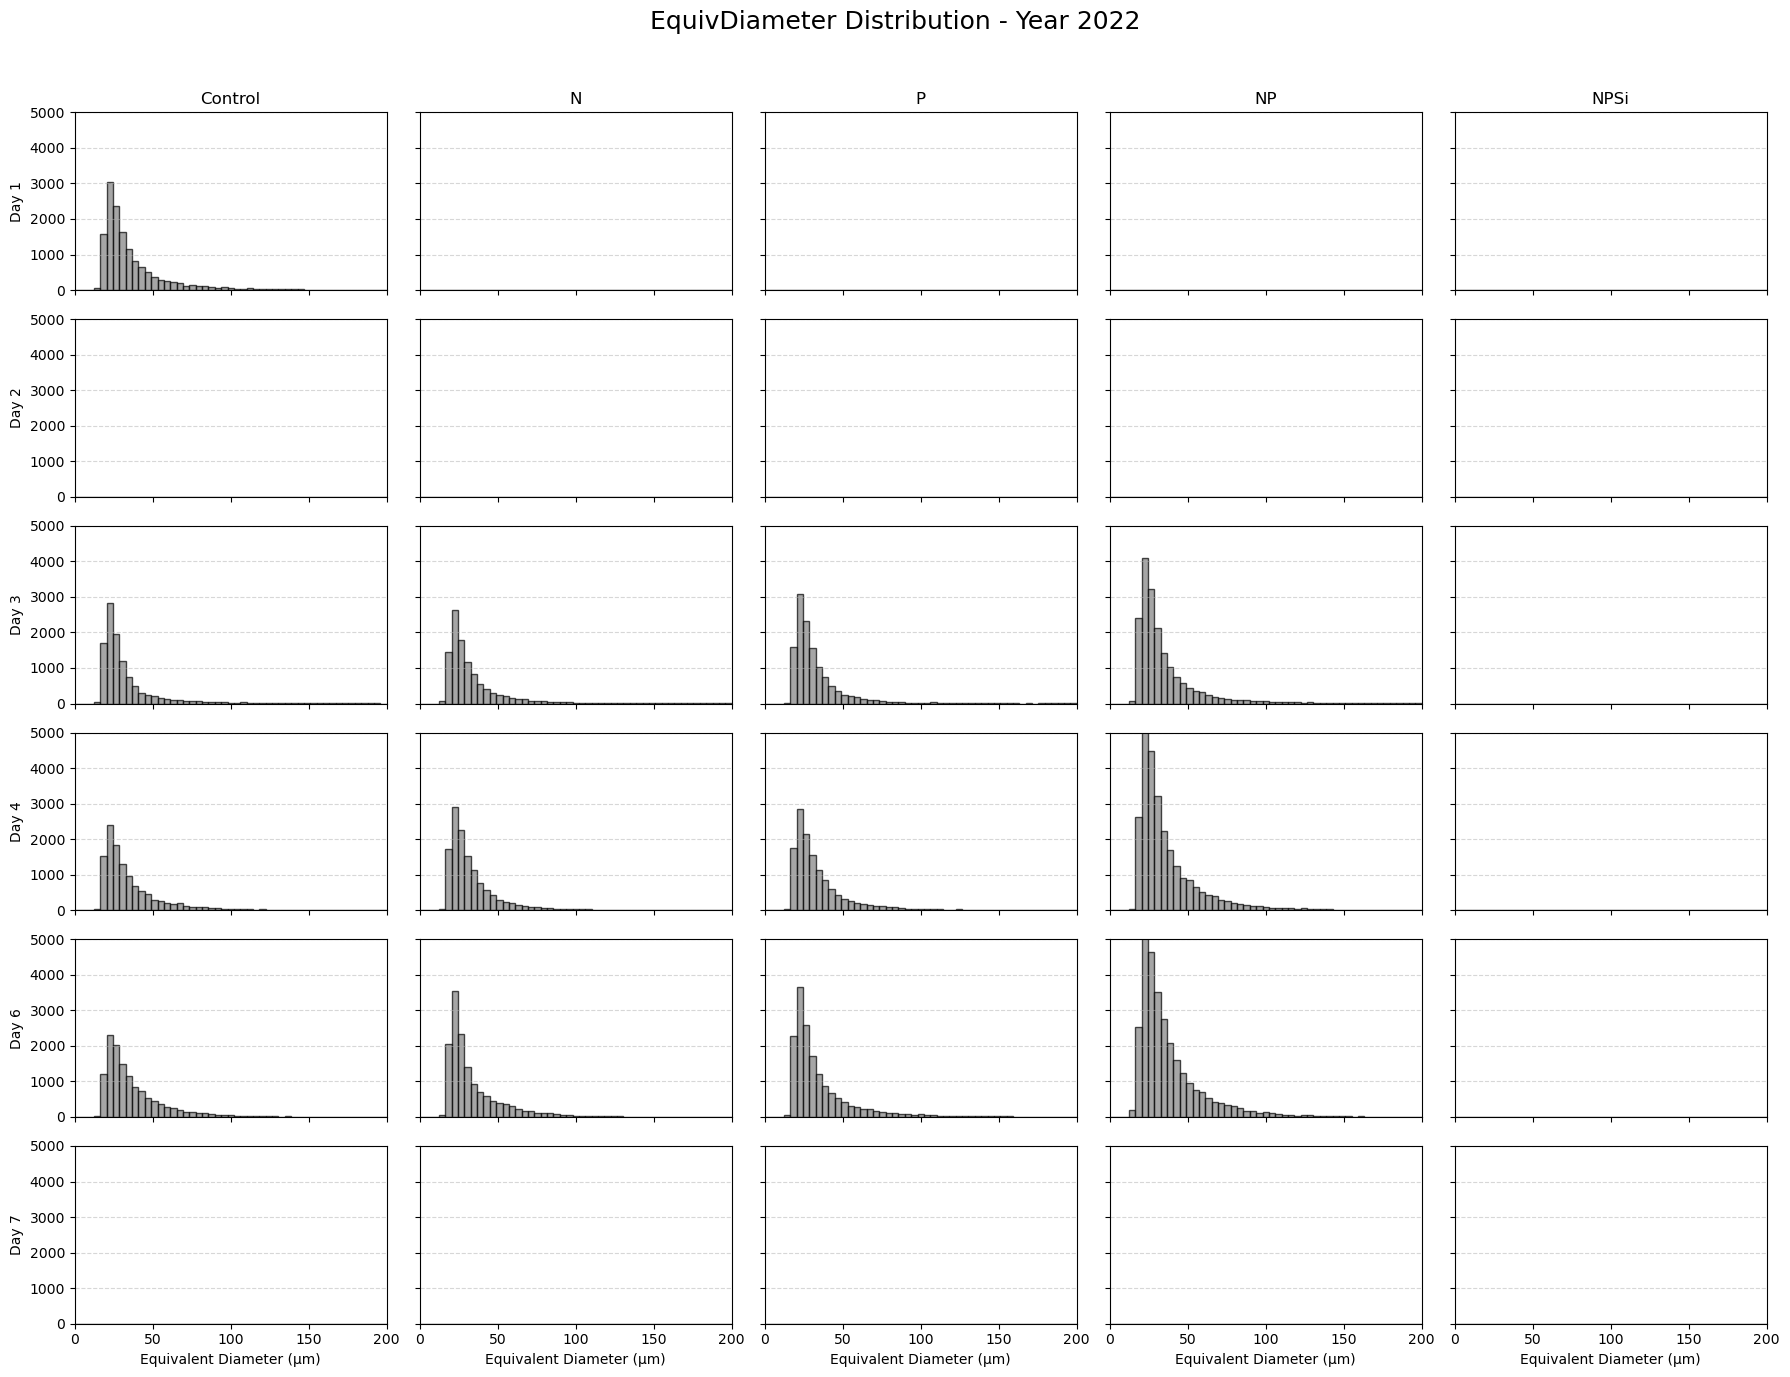

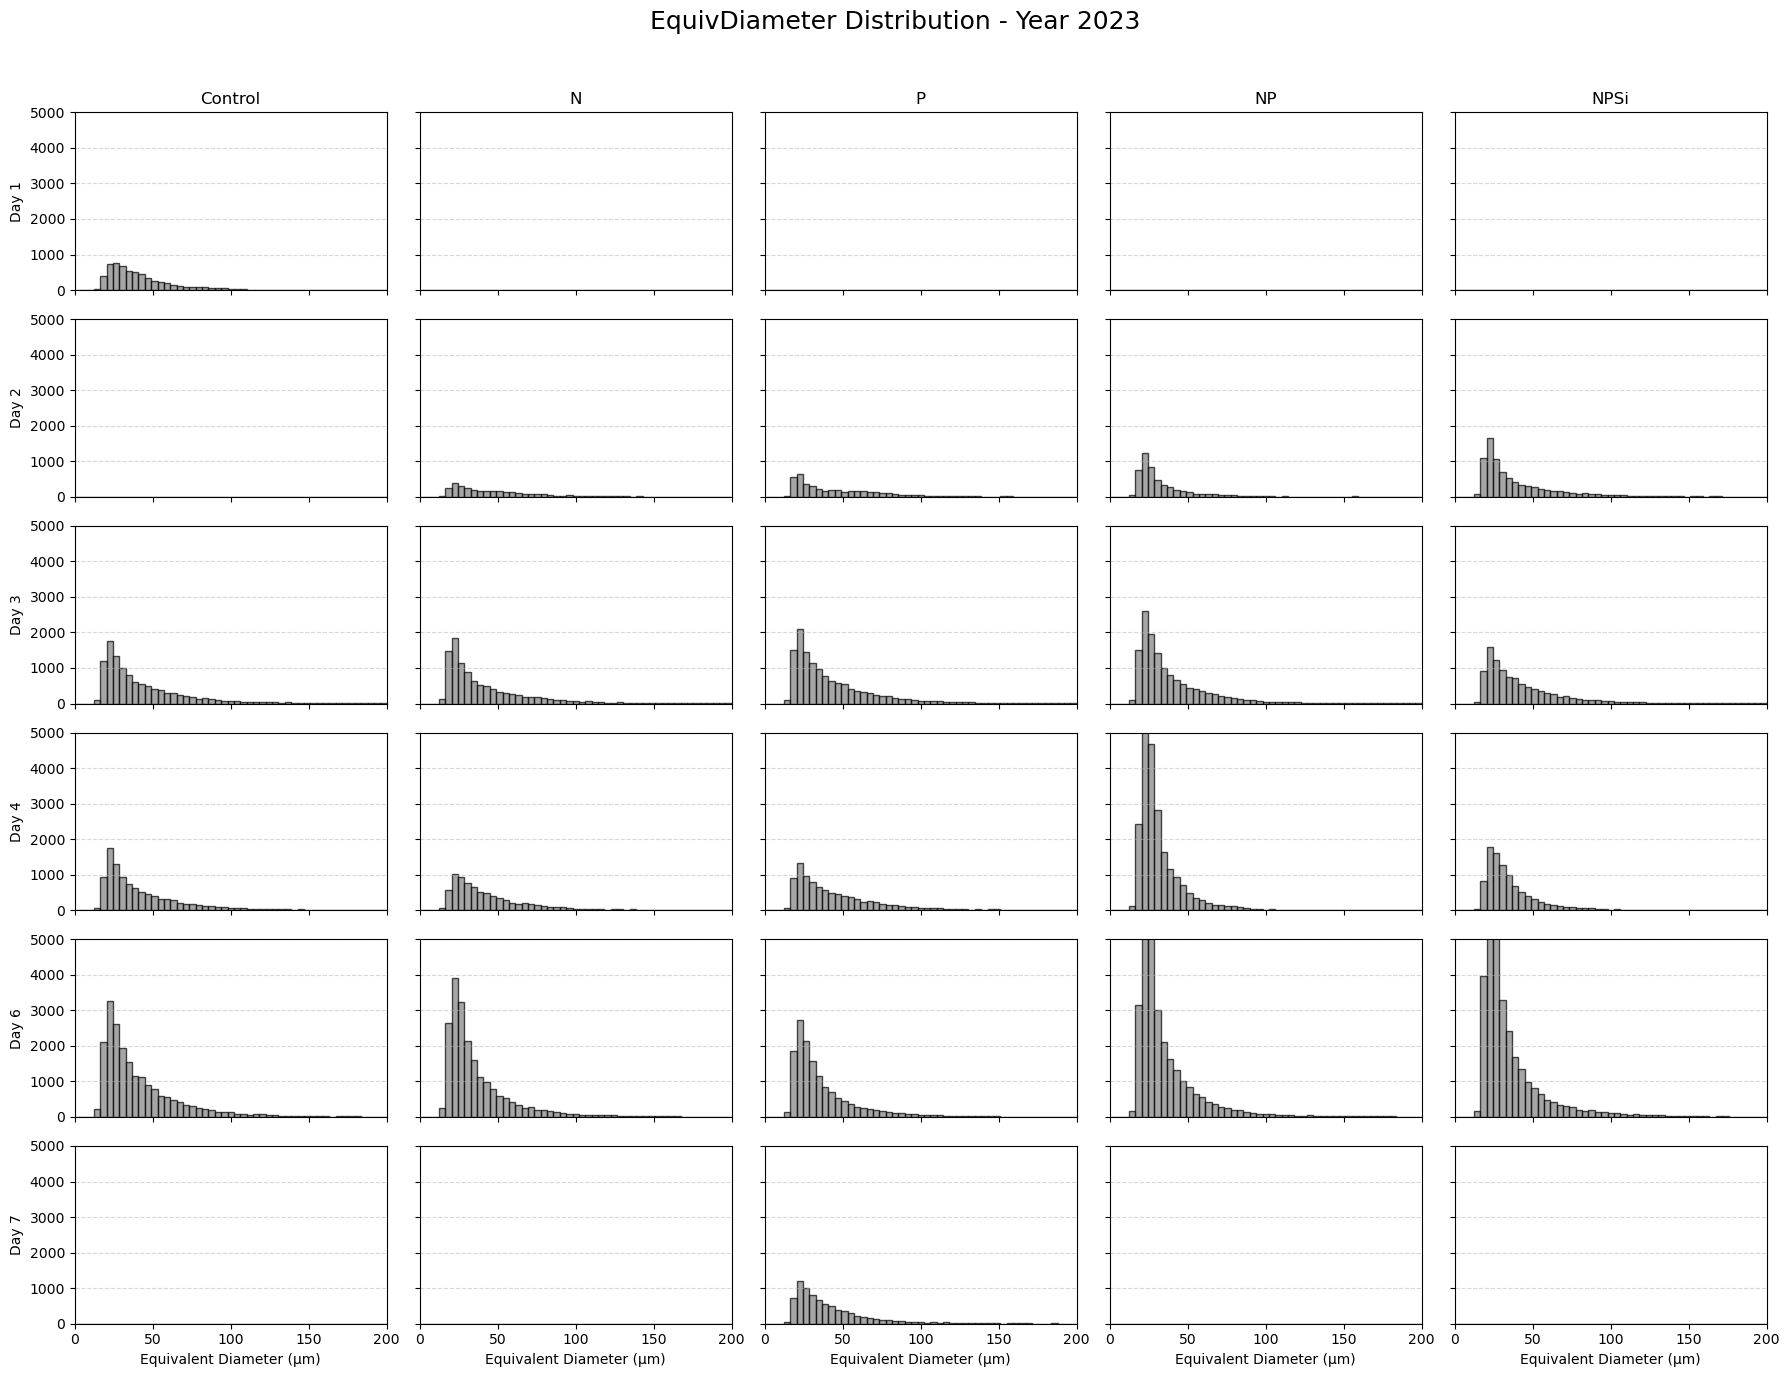

In [22]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
# Now using EquivDiameter instead of MajorAxisLength
df = df[['year', 'day', 'treatment', 'EquivDiameter']]

# === Filter reasonable EquivDiameter values ===
# Same idea as before: keep only positive and < 500 µm
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

# === Define plotting settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
day_order = sorted(df['day'].unique())
year_order = sorted(df['year'].unique())

# Bins from 0 to 200 µm, as with MajorAxisLength
bins = np.linspace(0, 200, 50)

# === Create one matrix of histograms per year ===
for year in year_order:
    df_year = df[df['year'] == year]
    
    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )
    
    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]
            
            subset = df_year[(df_year['day'] == day) &
                             (df_year['treatment'] == treatment)]
            
            ax.hist(
                subset['EquivDiameter'],
                bins=bins,
                color='gray',
                edgecolor='black',
                alpha=0.7
            )
            ax.set_xlim(0, 200)
            ax.set_ylim(0, 5000)
            
            # Axis labels
            if i == len(day_order) - 1:
                ax.set_xlabel("Equivalent Diameter (µm)")
            if j == 0:
                ax.set_ylabel(f"Day {day}")
            
            # Column titles = treatments
            if i == 0:
                ax.set_title(treatment)
            
            ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    fig.suptitle(f"EquivDiameter Distribution - Year {year}", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    # === Commented Save ===
    # fig.savefig(f"EquivDiameter_Histograms_{year}.tiff", dpi=600, bbox_inches='tight')
    # fig.savefig(f"EquivDiameter_Histograms_{year}.eps", bbox_inches='tight')

    plt.show()

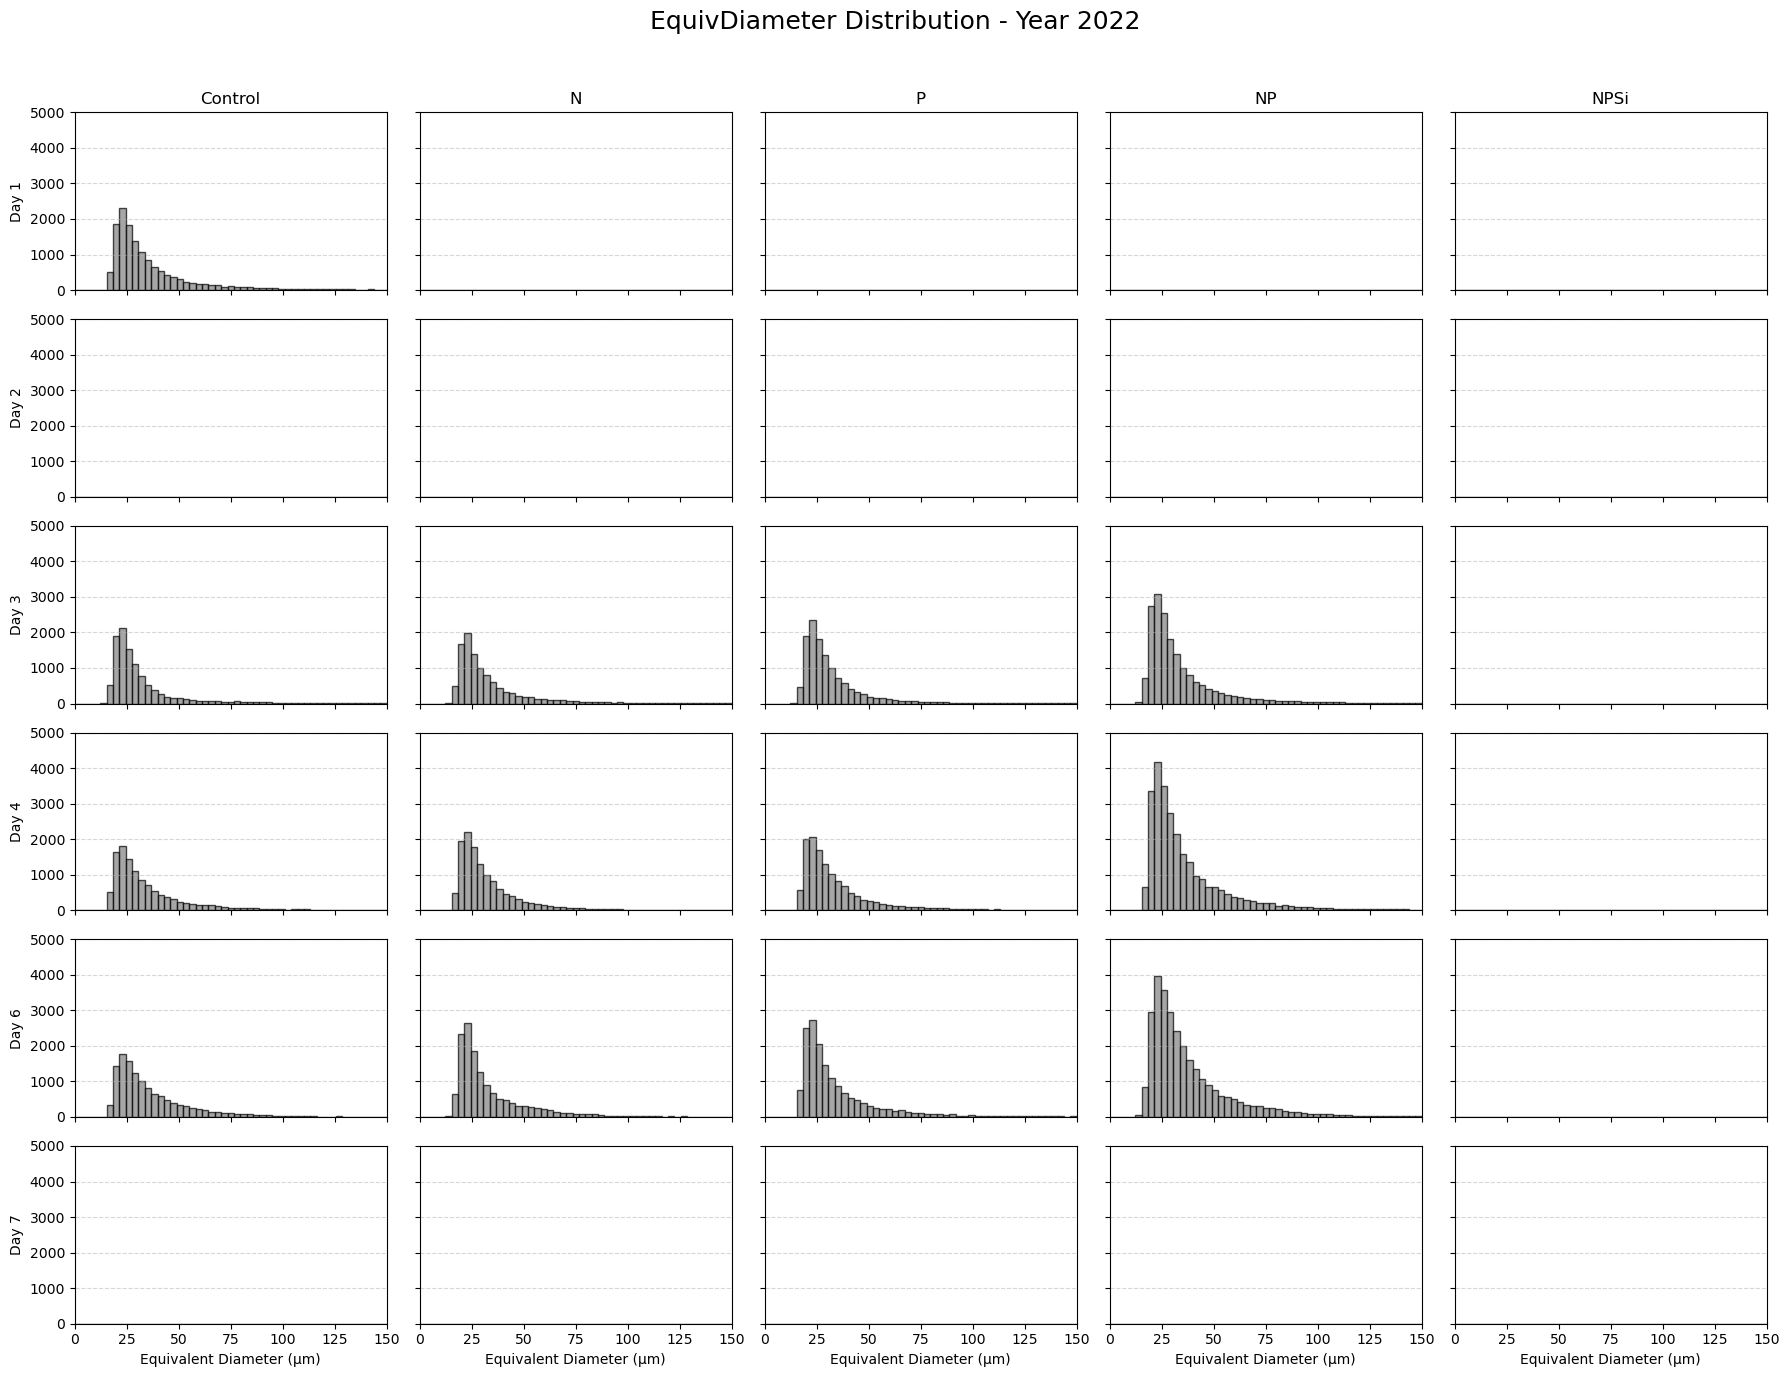

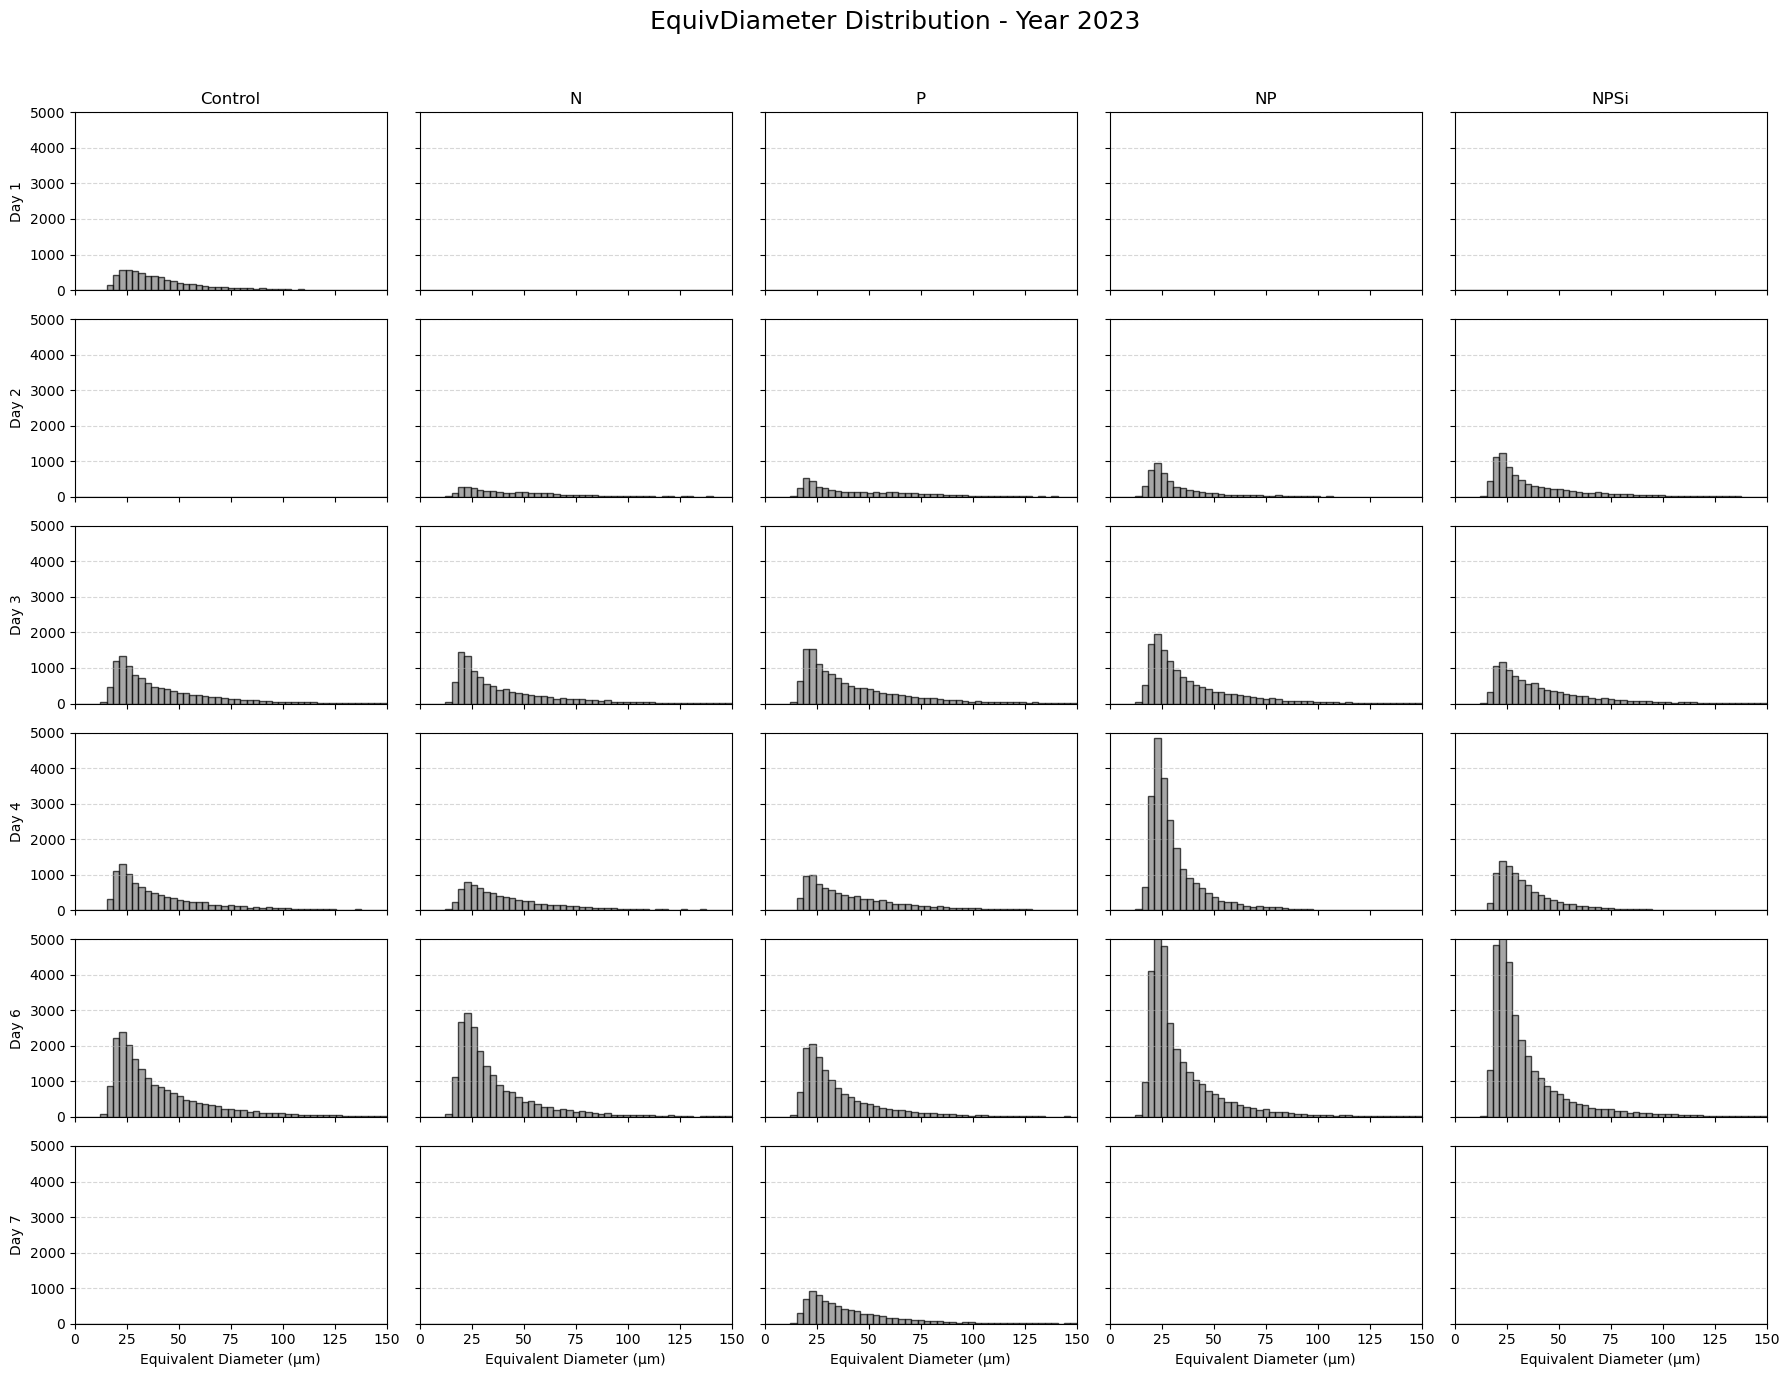

In [23]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'EquivDiameter']]

# === Filter reasonable EquivDiameter values ===
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

# === Define plotting settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
day_order = sorted(df['day'].unique())
year_order = sorted(df['year'].unique())

# Bins adjusted to match the new X max (0–150 µm)
bins = np.linspace(0, 150, 50)

# === Create one matrix of histograms per year ===
for year in year_order:
    df_year = df[df['year'] == year]
    
    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )
    
    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]
            
            subset = df_year[
                (df_year['day'] == day) &
                (df_year['treatment'] == treatment)
            ]
            
            ax.hist(
                subset['EquivDiameter'],
                bins=bins,
                color='gray',
                edgecolor='black',
                alpha=0.7
            )
            
            # Updated axis limits
            ax.set_xlim(0, 150)
            ax.set_ylim(0, 5000)

            if i == len(day_order) - 1:
                ax.set_xlabel("Equivalent Diameter (µm)")
            if j == 0:
                ax.set_ylabel(f"Day {day}")
            
            if i == 0:
                ax.set_title(treatment)
            
            ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    fig.suptitle(f"EquivDiameter Distribution - Year {year}", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    # === Optional Save ===
    # fig.savefig(f"EquivDiameter_Histograms_{year}.tiff", dpi=600, bbox_inches='tight')
    # fig.savefig(f"EquivDiameter_Histograms_{year}.eps", bbox_inches='tight')

    plt.show()

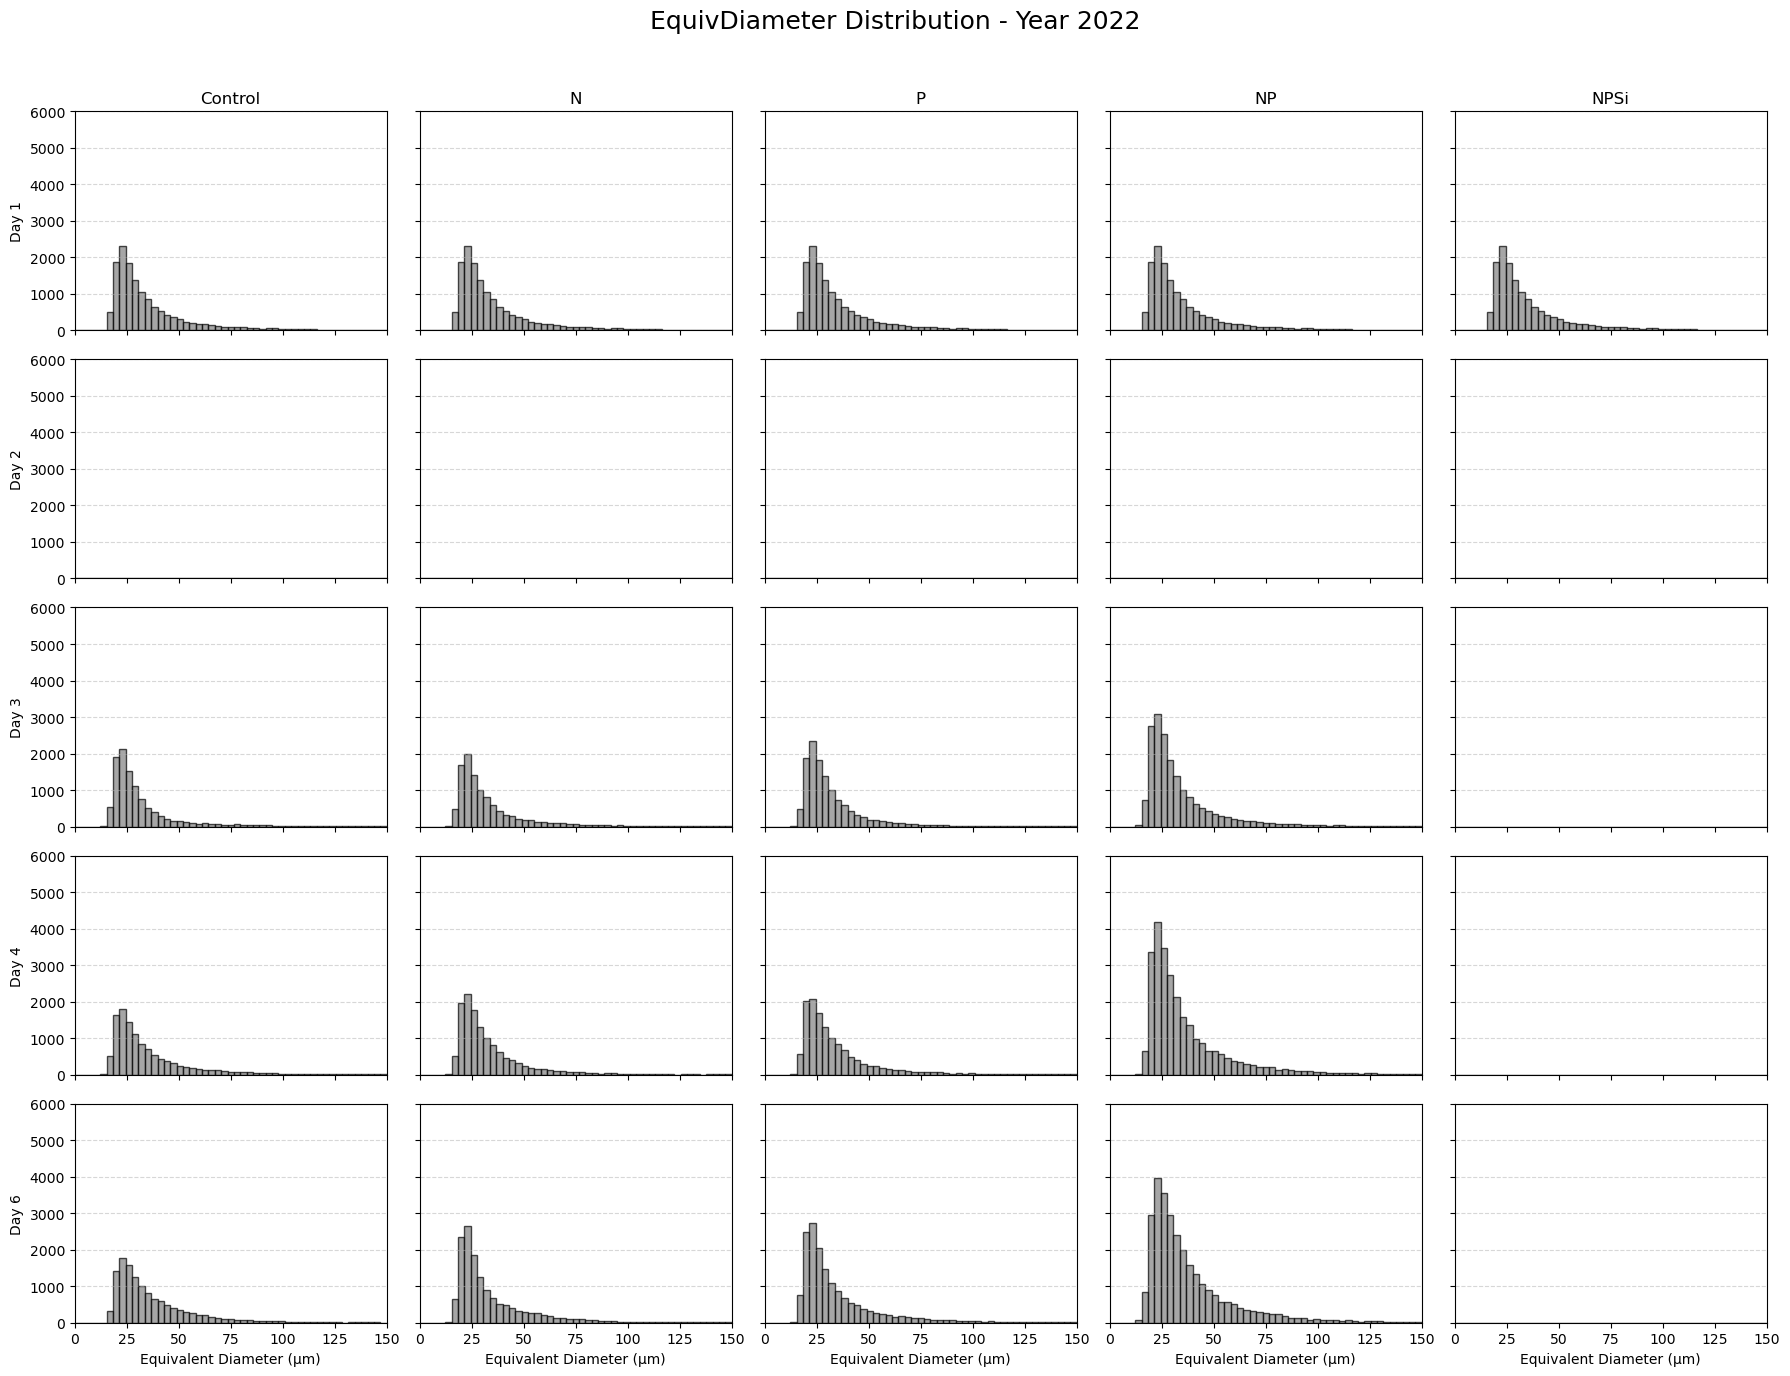

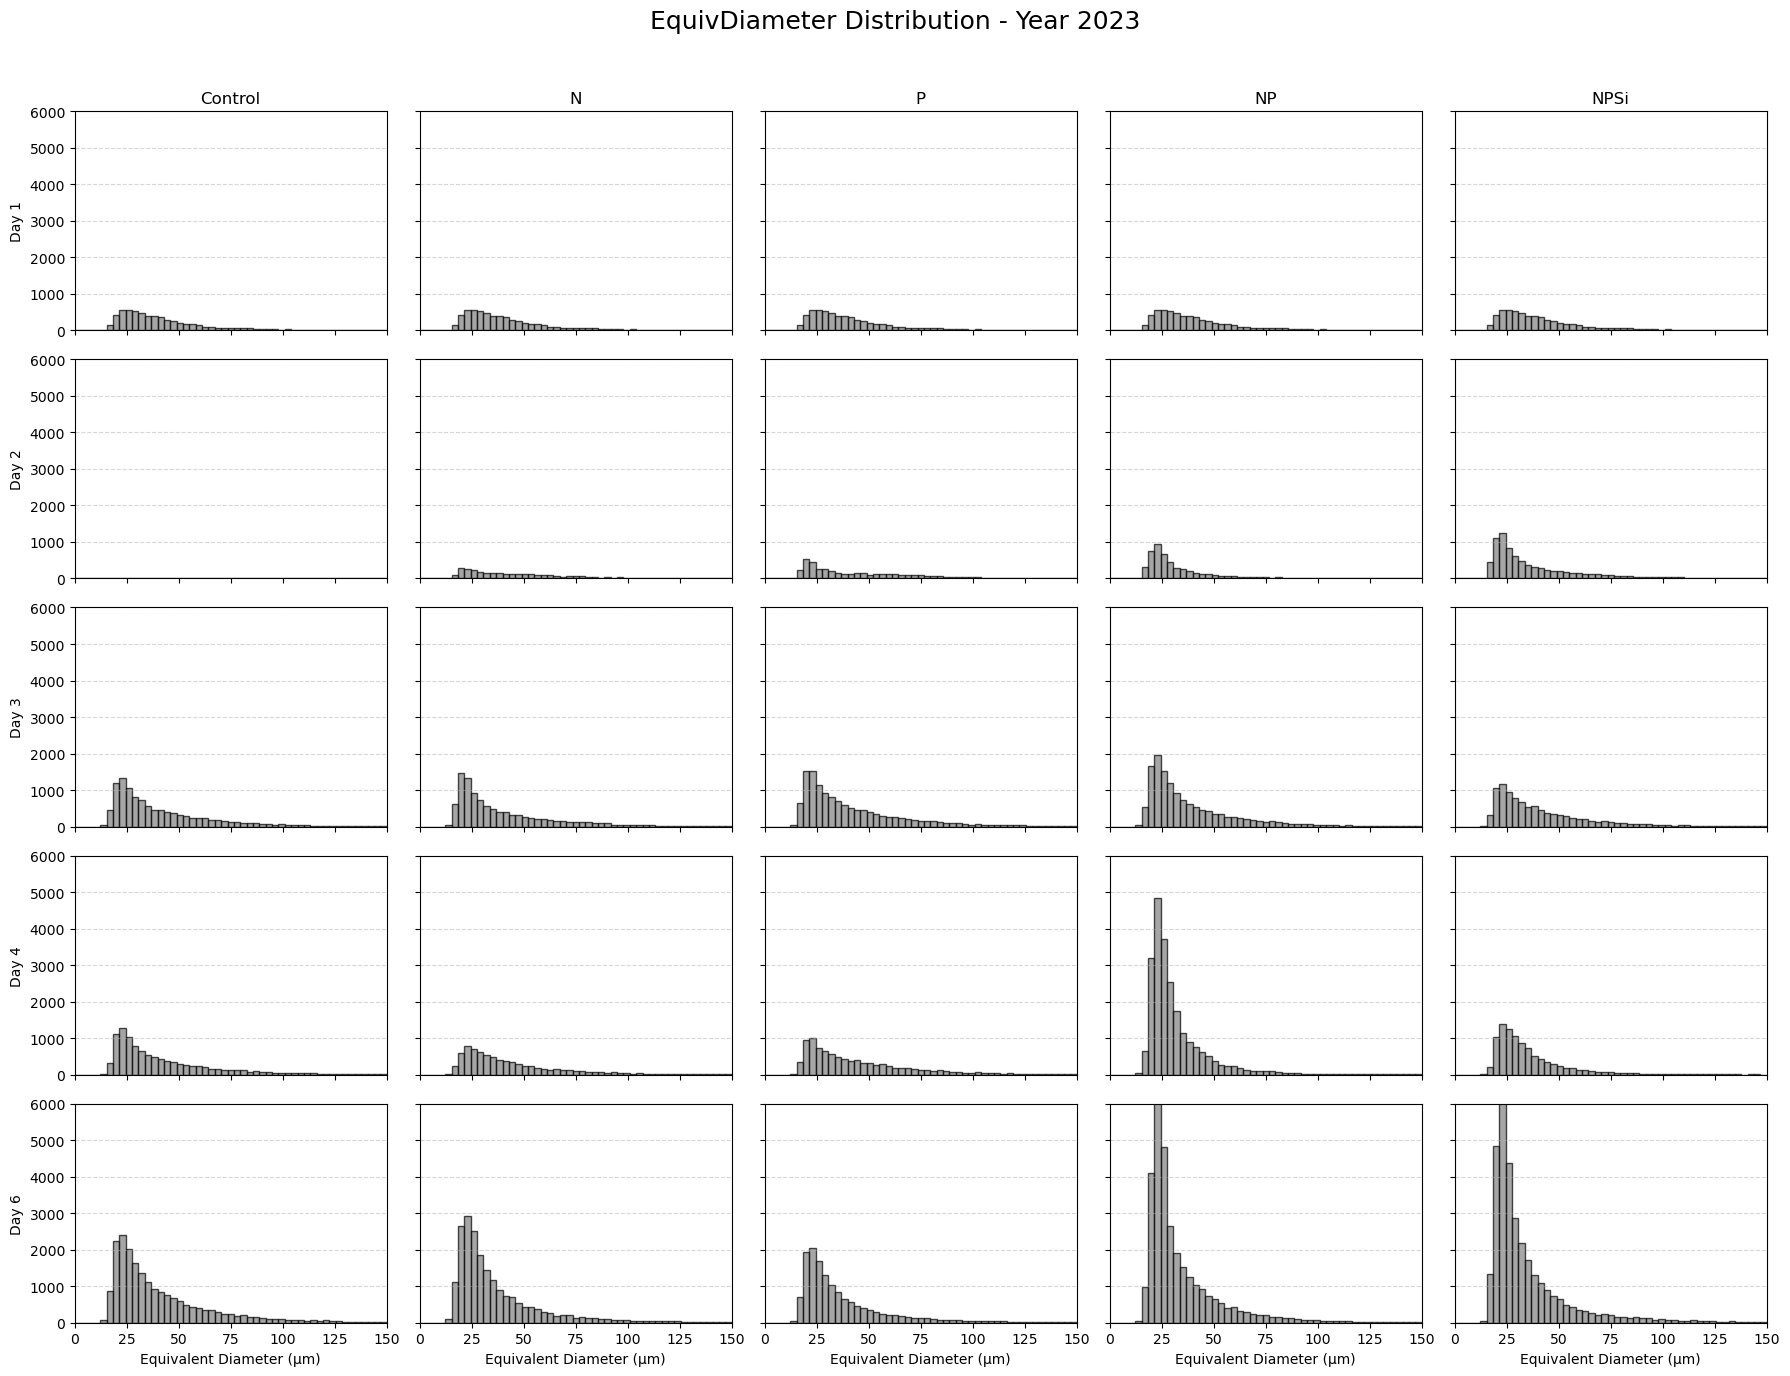

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'EquivDiameter']]

# === Filter reasonable EquivDiameter values ===
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

# === Exclude Day 7 ===
df = df[df['day'] != 7]

# === Define plotting settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

# ============================================================
# === Replicate Day 1 within each year to all treatments  ====
# ============================================================

# Work with the current df (after removing Day 7)
df_day1 = df[df['day'] == 1]

replicated_rows = []

# Use the years present in the data
year_order_all = sorted(df['year'].unique())

for year in year_order_all:
    base_day1 = df_day1[df_day1['year'] == year]
    if base_day1.empty:
        continue

    # For each treatment, create a copy of the Day 1 rows
    for treatment in treatment_order:
        temp = base_day1.copy()
        temp['treatment'] = treatment
        replicated_rows.append(temp)

# Remove original Day 1 rows and replace with replicated set
df = df[df['day'] != 1]
if replicated_rows:
    df_day1_combined = pd.concat(replicated_rows, ignore_index=True)
    df = pd.concat([df, df_day1_combined], ignore_index=True)

# ============================================================

# Recompute day and year orders after modifications
day_order = sorted(df['day'].unique())   # should be [1..6] now
year_order = sorted(df['year'].unique())

# Bins adjusted to match the new X max (0–150 µm)
bins = np.linspace(0, 150, 50)

# === Create one matrix of histograms per year ===
for year in year_order:
    df_year = df[df['year'] == year]
    
    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )
    
    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]
            
            subset = df_year[
                (df_year['day'] == day) &
                (df_year['treatment'] == treatment)
            ]
            
            ax.hist(
                subset['EquivDiameter'],
                bins=bins,
                color='gray',
                edgecolor='black',
                alpha=0.7
            )
            
            # Updated axis limits
            ax.set_xlim(0, 150)
            ax.set_ylim(0, 6000)

            if i == len(day_order) - 1:
                ax.set_xlabel("Equivalent Diameter (µm)")
            if j == 0:
                ax.set_ylabel(f"Day {day}")
            
            if i == 0:
                ax.set_title(treatment)
            
            ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    fig.suptitle(f"EquivDiameter Distribution - Year {year}", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    # === Optional Save ===
    #fig.savefig(f"EquivDiameter_Histograms_{year}.tiff", dpi=600, bbox_inches='tight')
    # fig.savefig(f"EquivDiameter_Histograms_{year}.eps", bbox_inches='tight')

    plt.show()

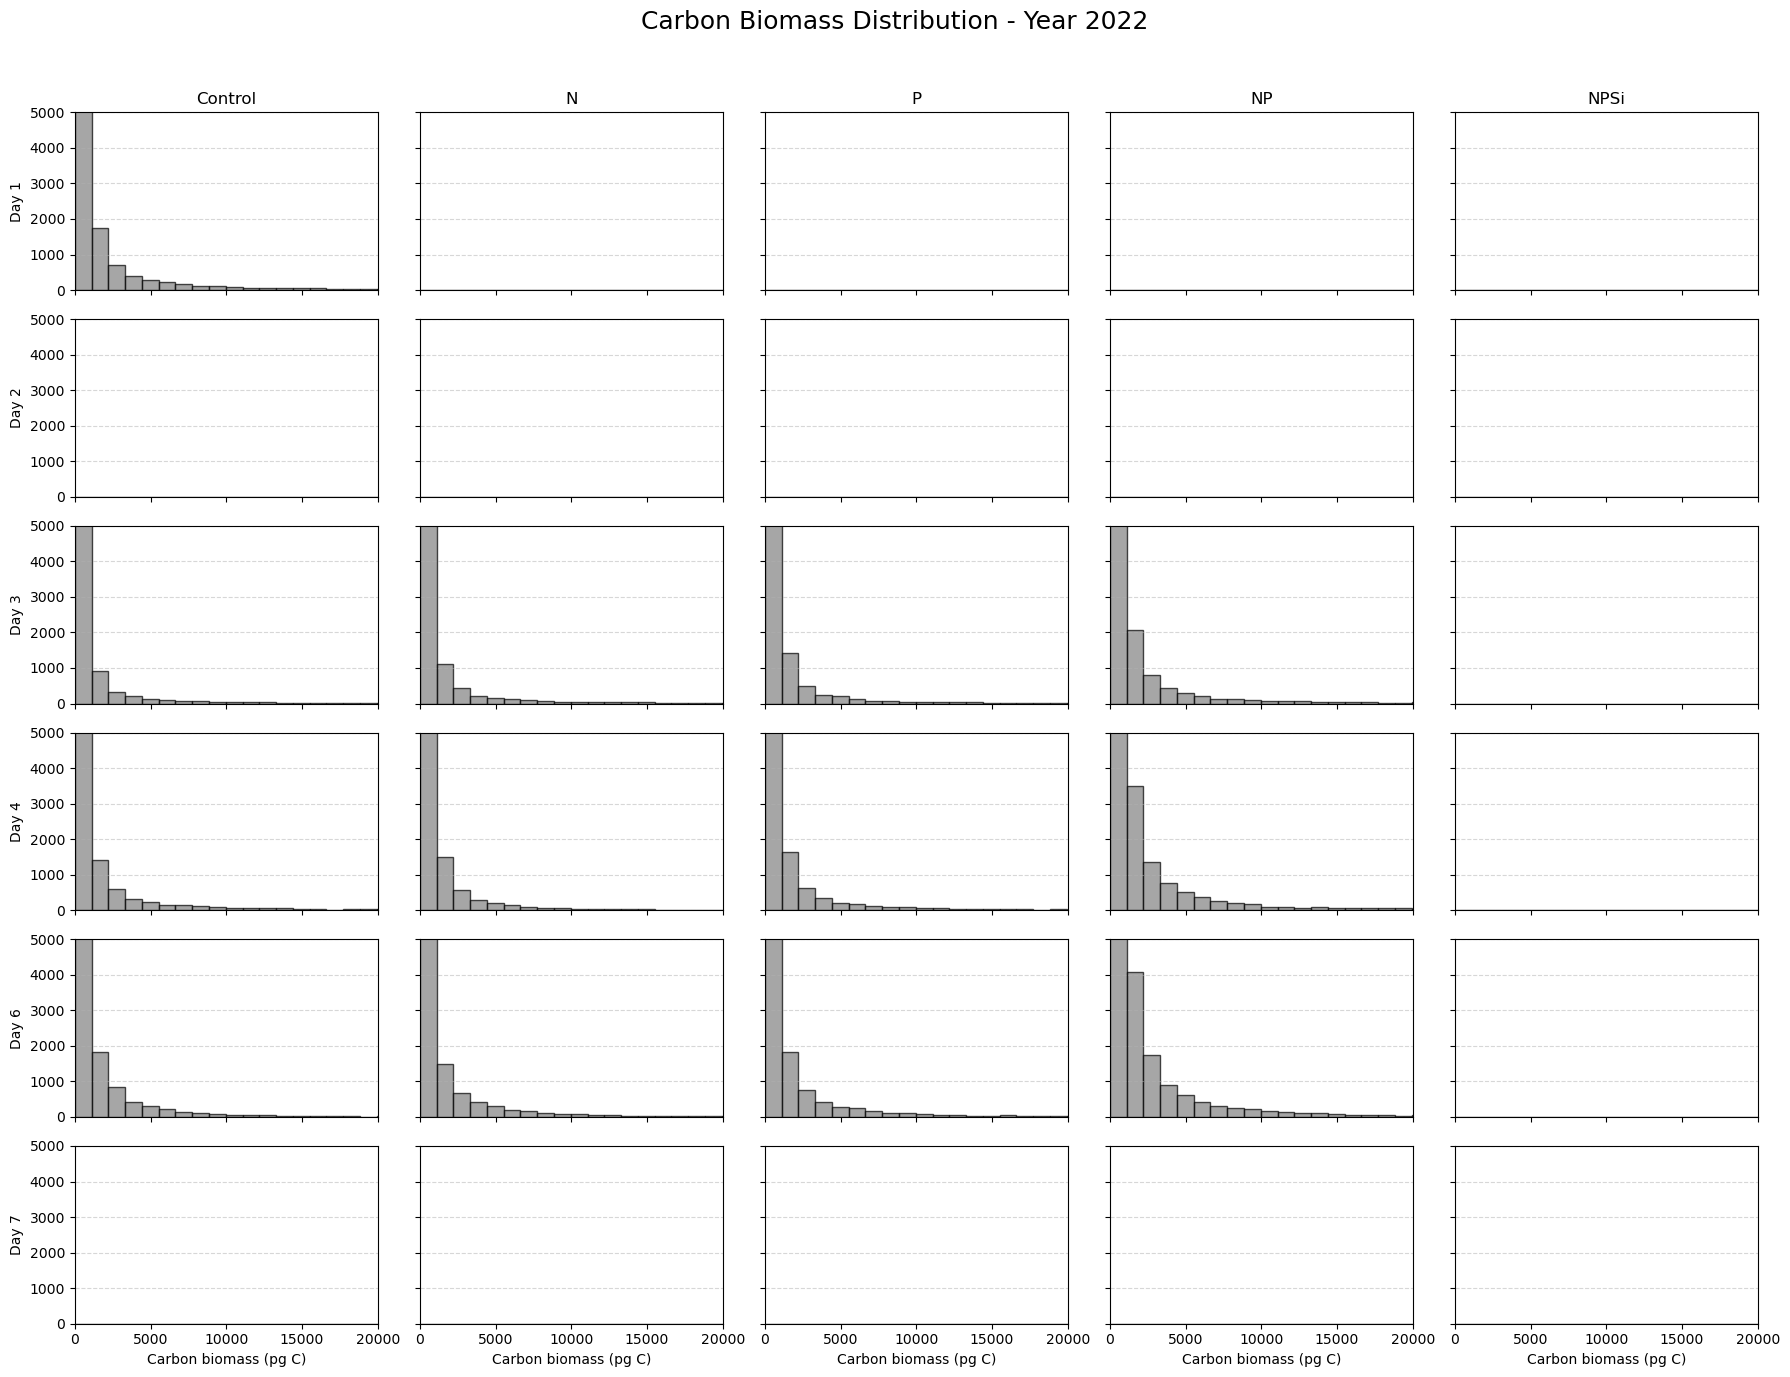

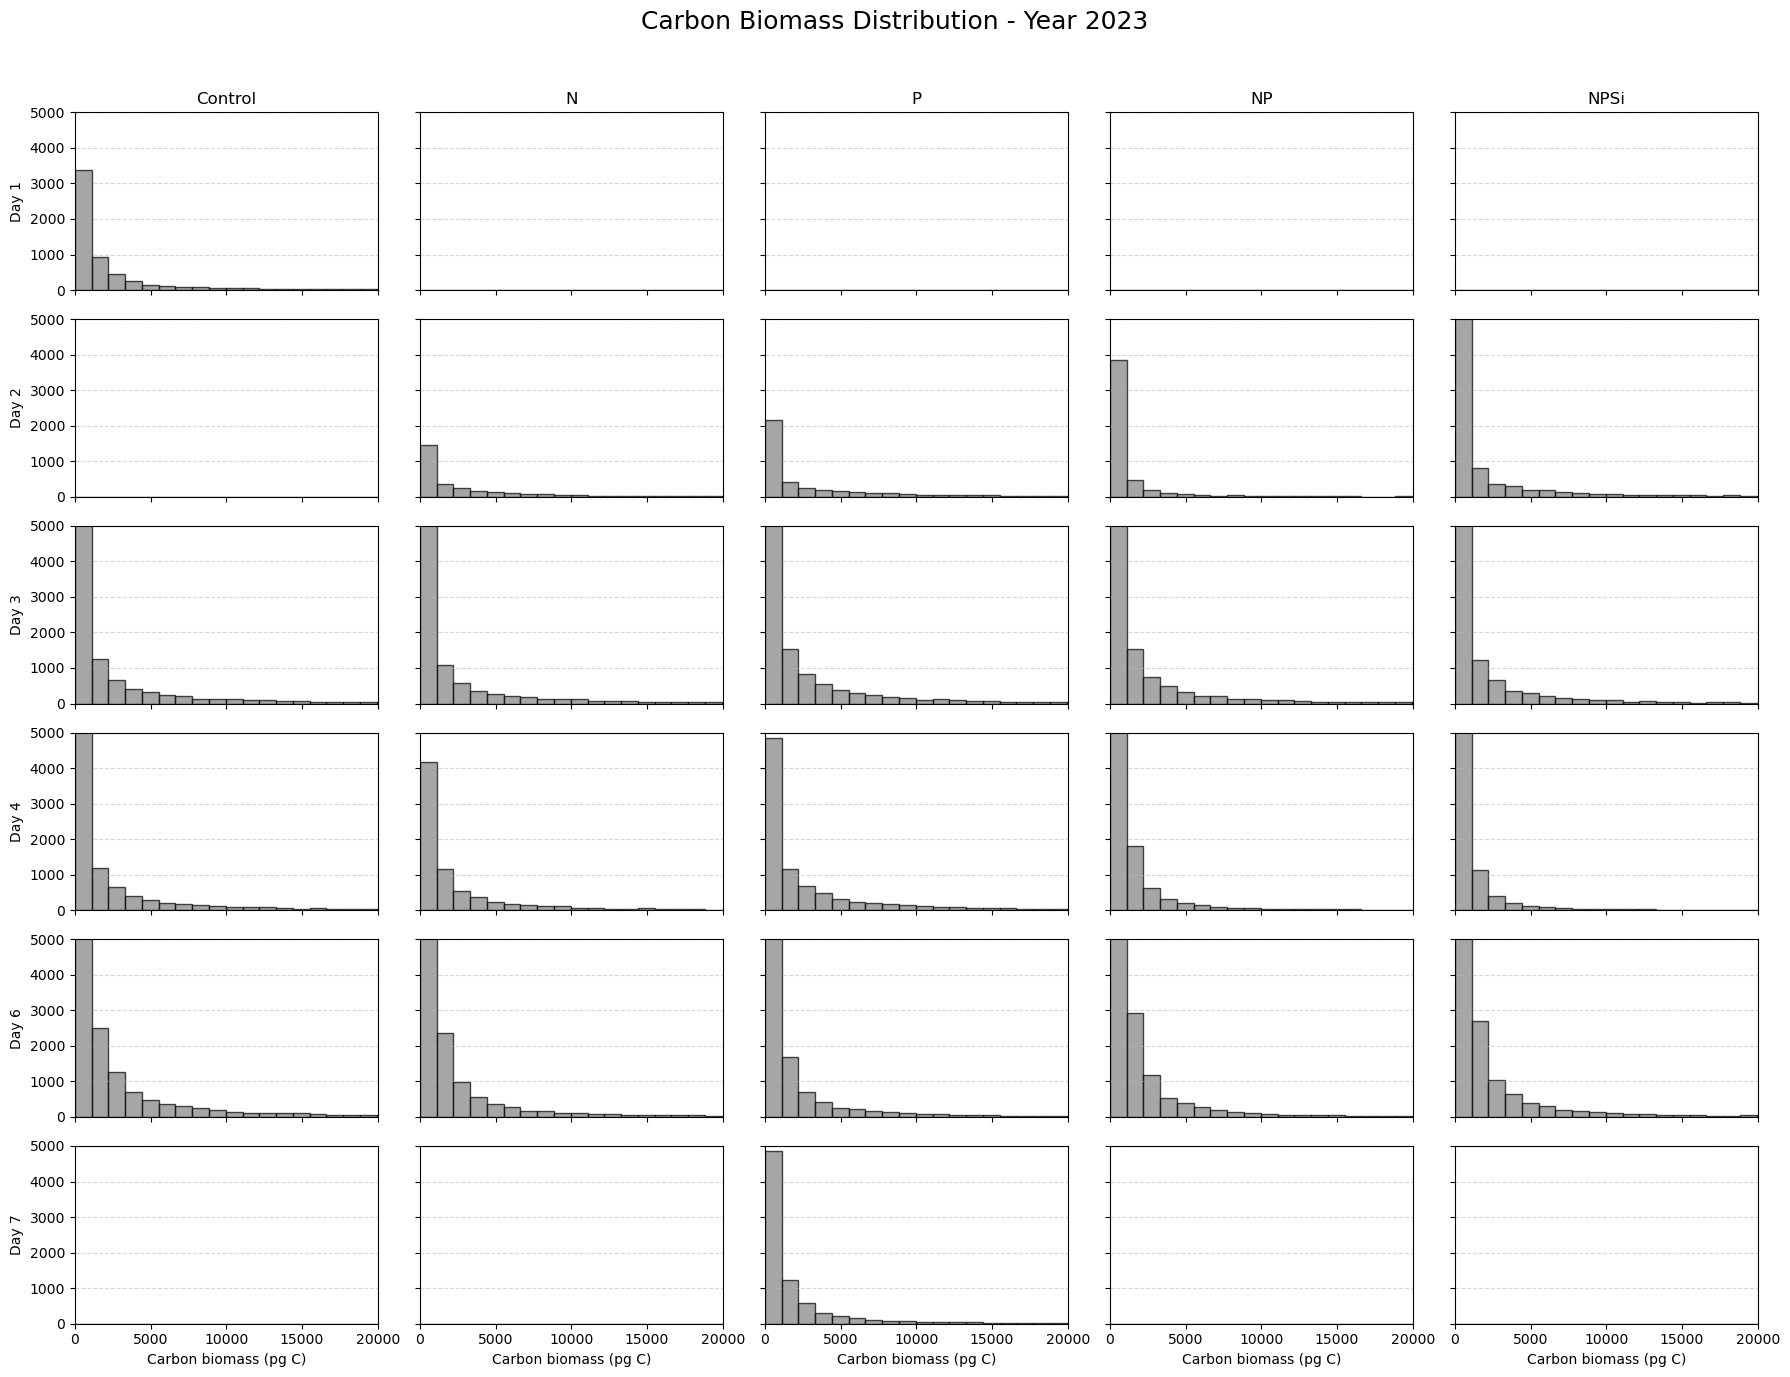

In [25]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'carbon_pgC']]

# === Filter reasonable carbon values ===
# Adjust limits if needed (here we keep only positive values)
df = df[(df['carbon_pgC'] > 0) & (df['carbon_pgC'] < 1e6)]

# === Define plotting settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
day_order = sorted(df['day'].unique())
year_order = sorted(df['year'].unique())

# Bins for carbon (modify if needed)
bins = np.linspace(0, df['carbon_pgC'].quantile(0.99), 50)

# === Create one matrix of histograms per year ===
for year in year_order:
    df_year = df[df['year'] == year]
    
    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )
    
    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]
            
            subset = df_year[
                (df_year['day'] == day) &
                (df_year['treatment'] == treatment)
            ]
            
            ax.hist(
                subset['carbon_pgC'],
                bins=bins,
                color='gray',
                edgecolor='black',
                alpha=0.7
            )
            
            # Updated axis limits
            ax.set_xlim(0, 20000)
            ax.set_ylim(0, 5000)

            # Labels and titles
            if i == len(day_order) - 1:
                ax.set_xlabel("Carbon biomass (pg C)")
            if j == 0:
                ax.set_ylabel(f"Day {day}")
            
            if i == 0:
                ax.set_title(treatment)
            
            ax.grid(axis='y', linestyle='--', alpha=0.5)
    
    fig.suptitle(f"Carbon Biomass Distribution - Year {year}", fontsize=18)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
    # === Optional Save ===
    # fig.savefig(f"Carbon_pgC_Histograms_{year}.tiff",
    #             dpi=600, bbox_inches='tight')
    # fig.savefig(f"Carbon_pgC_Histograms_{year}.eps",
    #             bbox_inches='tight')

    plt.show()

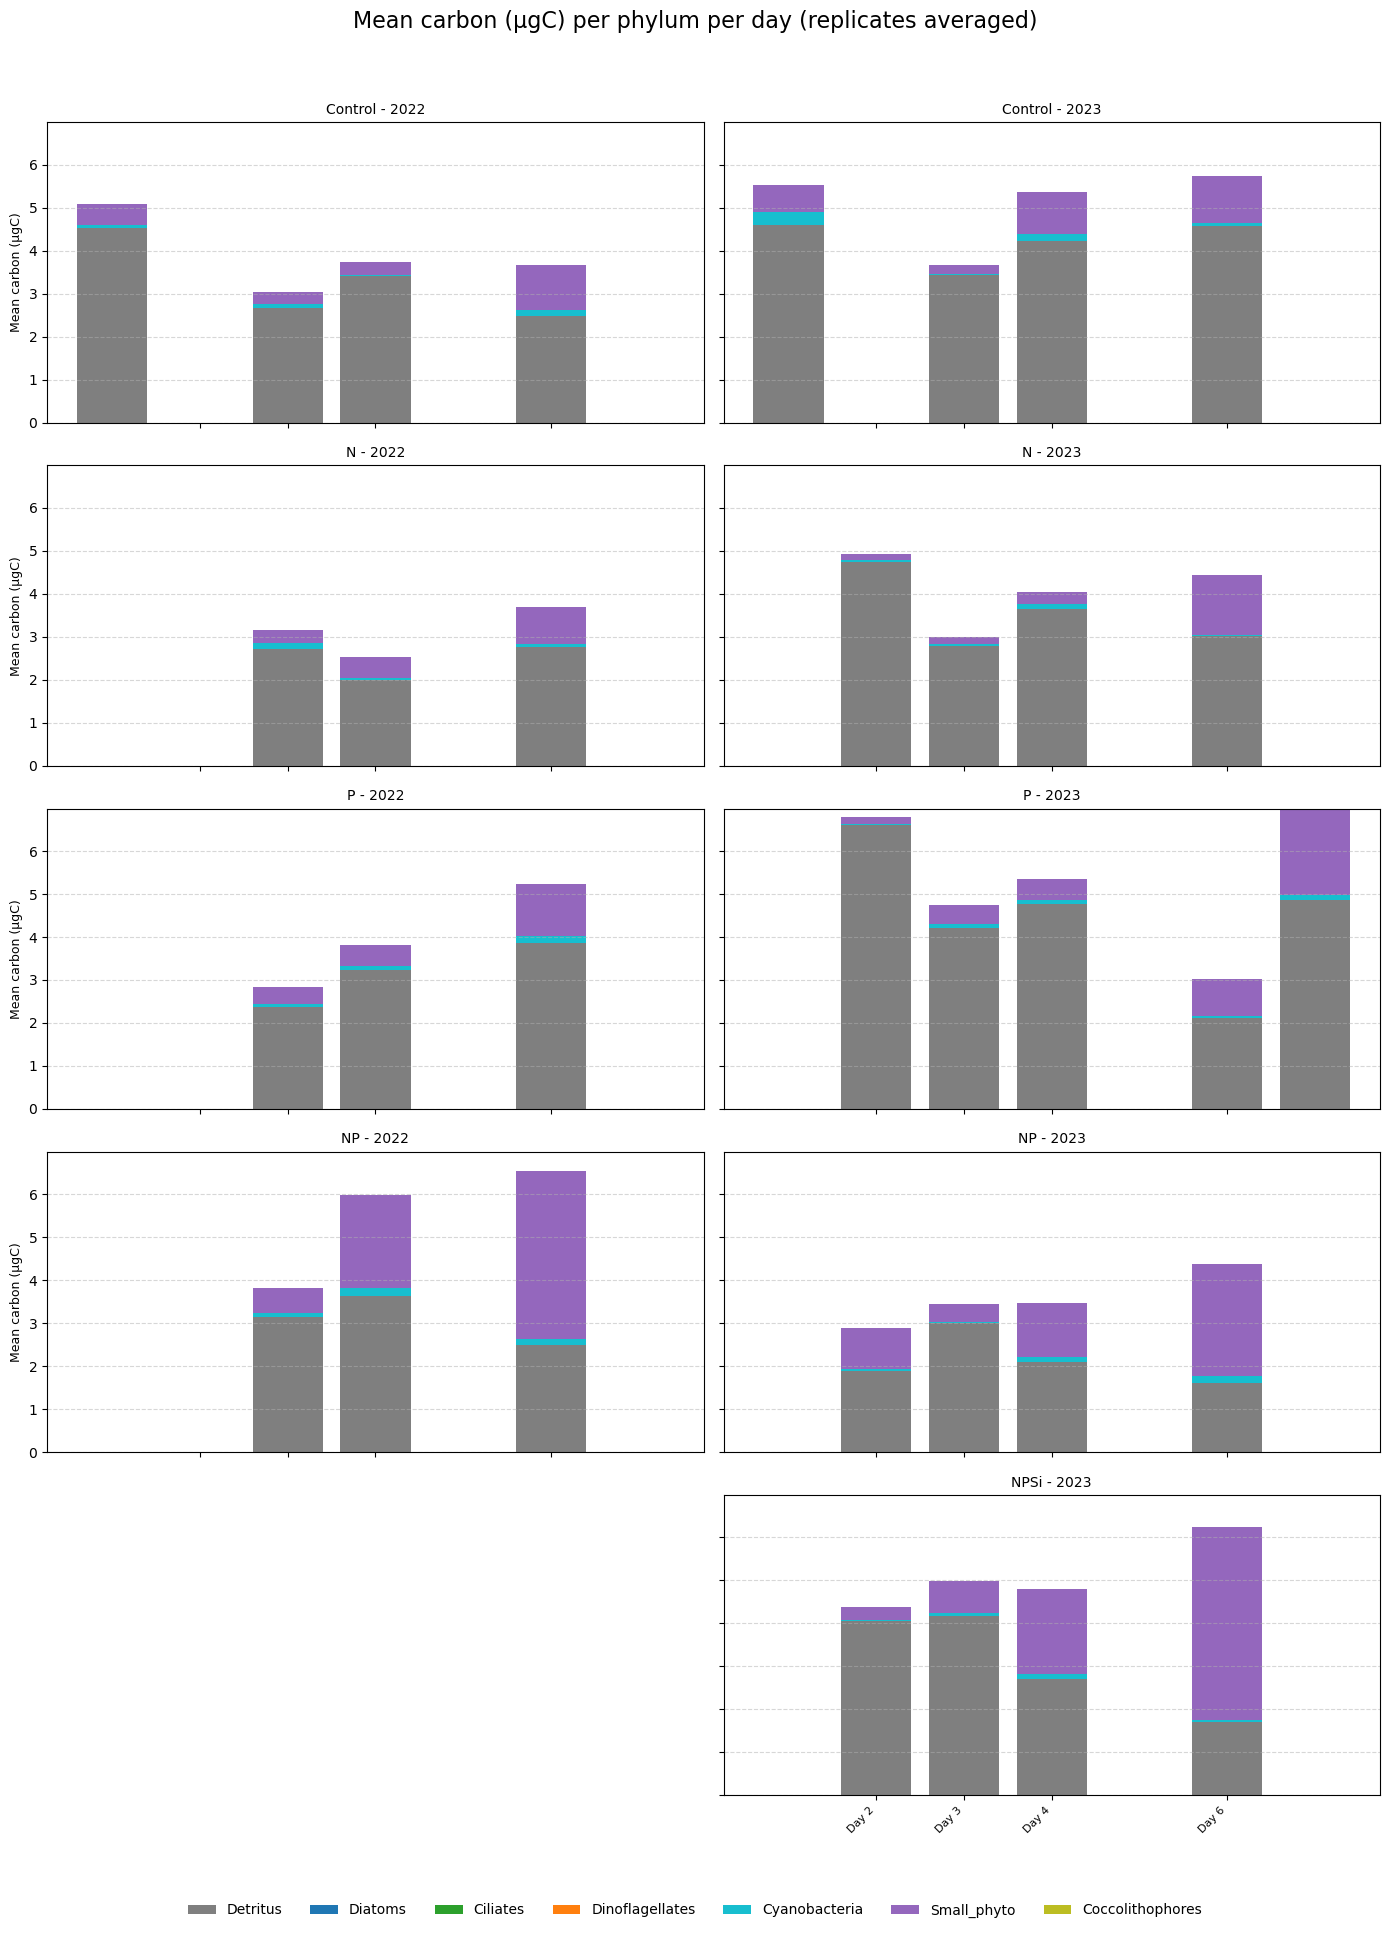

In [26]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === Load dataset ===
input_db = "03_datasets/Ishigaki2023/5A_C_biomass_per_replicate.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM C_biomass_by_replicate", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'replicate', 'phylum', 'carbon_ugC']]

# === Filter only valid phyla ===
phylum_keep = [
    'Detritus',
    'Diatoms',
    'Ciliates',
    'Dinoflagellates',
    'Cyanobacteria',
    'Small_phyto',
    'Coccolithophores'
]

df = df.dropna(subset=['phylum', 'carbon_ugC'])
df = df[df['phylum'].isin(phylum_keep)]

# === Optional: exclude Detritus if desired ===
EXCLUDE_DETRITUS = False
if EXCLUDE_DETRITUS:
    df = df[df['phylum'] != 'Detritus']

# === Define order of treatments and phyla ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']

phylum_order = [
    'Detritus',
    'Diatoms',
    'Ciliates',
    'Dinoflagellates',
    'Cyanobacteria',
    'Small_phyto',
    'Coccolithophores'
]

# Remove Detritus from plotting order if excluded
if EXCLUDE_DETRITUS:
    phylum_order = [p for p in phylum_order if p != 'Detritus']

# === Color palette for phyla ===
phylum_palette = {
    'Detritus':         '#7f7f7f',
    'Diatoms':          '#1f77b4',
    'Ciliates':         '#2ca02c',
    'Dinoflagellates':  '#ff7f0e',
    'Cyanobacteria':    '#17becf',
    'Small_phyto':      '#9467bd',
    'Coccolithophores': '#bcbd22'
}

# === Output folder ===
output_dir = "FINAL_figs"
os.makedirs(output_dir, exist_ok=True)

# === Figure and axes ===
fig, axes = plt.subplots(
    nrows=len(treatment_order),
    ncols=2,
    figsize=(14, 20),
    sharex=True,
    sharey=True
)

years = [2022, 2023]

for i, treatment in enumerate(treatment_order):
    for j, year in enumerate(years):
        ax = axes[i, j]

        # Filter data for this treatment–year
        subset = df[(df['treatment'] == treatment) & (df['year'] == year)]

        if subset.empty:
            ax.axis('off')
            continue

        # === Average across replicates ===
        # Mean carbon_ugC for each (day, phylum)
        mean_by_day = (
            subset
            .groupby(['day', 'phylum'], observed=True)['carbon_ugC']
            .mean()
            .reset_index()
        )

        # Pivot: rows = day, columns = phylum
        pivot = mean_by_day.pivot_table(
            index='day',
            columns='phylum',
            values='carbon_ugC',
            fill_value=0
        )

        # Ensure all phylum columns exist (even if 0)
        for p in phylum_order:
            if p not in pivot.columns:
                pivot[p] = 0.0

        # Sort days and columns
        pivot = pivot.sort_index()
        pivot = pivot[phylum_order]

        days = pivot.index.values
        x = days  # use day as x position

        bottom = np.zeros(len(pivot))
        for p in phylum_order:
            values = pivot[p].values
            ax.bar(
                x,
                values,
                bottom=bottom,
                label=p if (i == 0 and j == 0) else "",
                color=phylum_palette.get(p, 'gray'),
                width=0.8
            )
            bottom += values

        # Axis formatting
        ax.set_xticks(days)
        ax.set_xticklabels([f"Day {d}" for d in days], rotation=45, ha='right', fontsize=8)

        if j == 0:
            ax.set_ylabel("Mean carbon (µgC)", fontsize=9)
        else:
            ax.set_ylabel("")

        ax.set_title(f"{treatment} - {year}", fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.5)

# === General figure settings ===
fig.suptitle("Mean carbon (µgC) per phylum per day (replicates averaged)", fontsize=16)

# Legend from first non-empty panel
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.02),
    ncol=len(phylum_order),
    frameon=False
)

plt.tight_layout(rect=[0, 0.06, 1, 0.96])

# Save figure (still commented)
figure_name = "mean_carbon_per_phylum_per_day"
if EXCLUDE_DETRITUS:
    figure_name += "_no_detritus"

# fig.savefig(os.path.join(output_dir, f"{figure_name}.tiff"), dpi=600)
# fig.savefig(os.path.join(output_dir, f"{figure_name}.eps"))

plt.show()

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

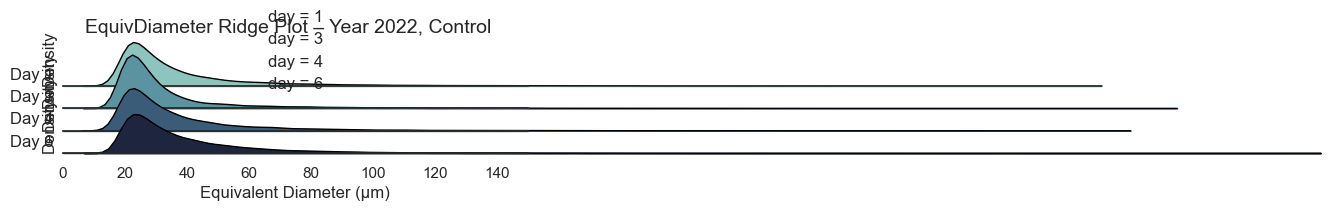

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

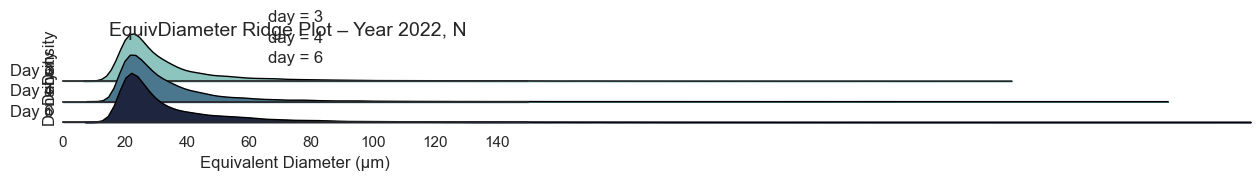

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

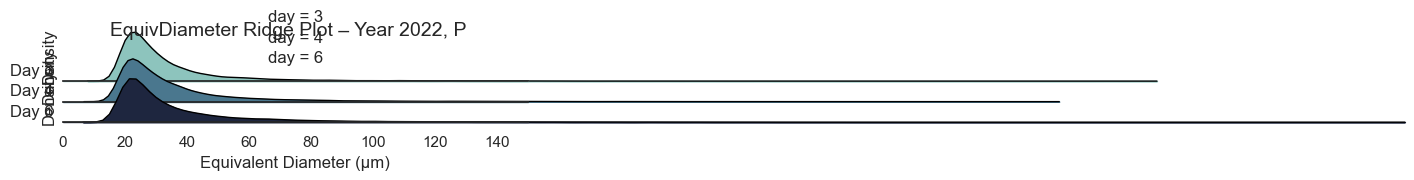

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

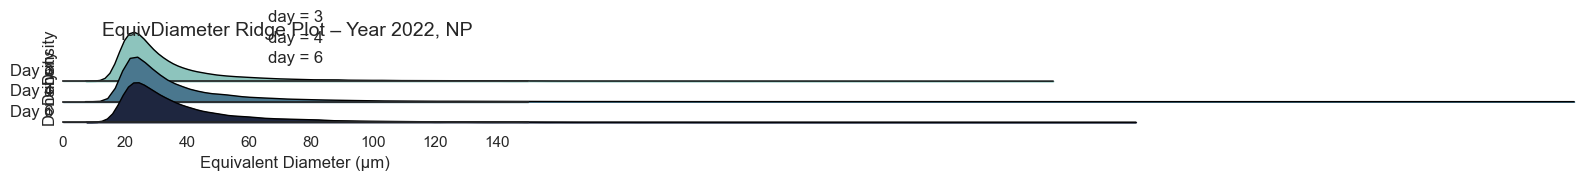

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

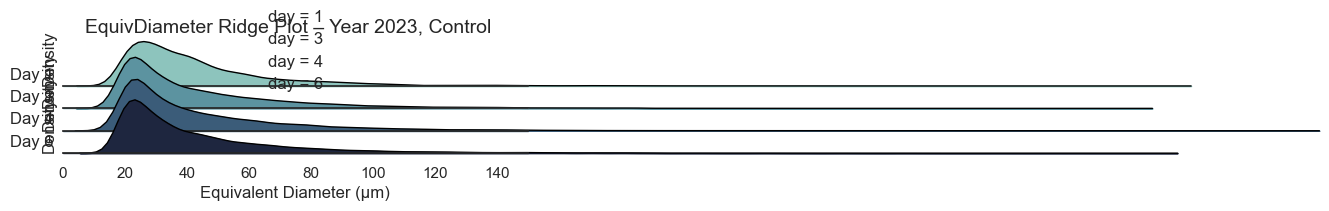

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

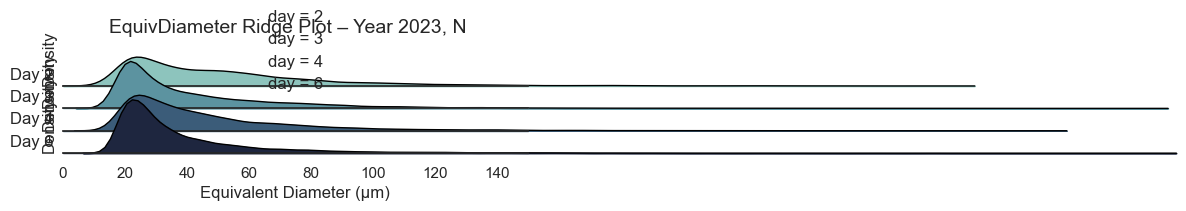

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

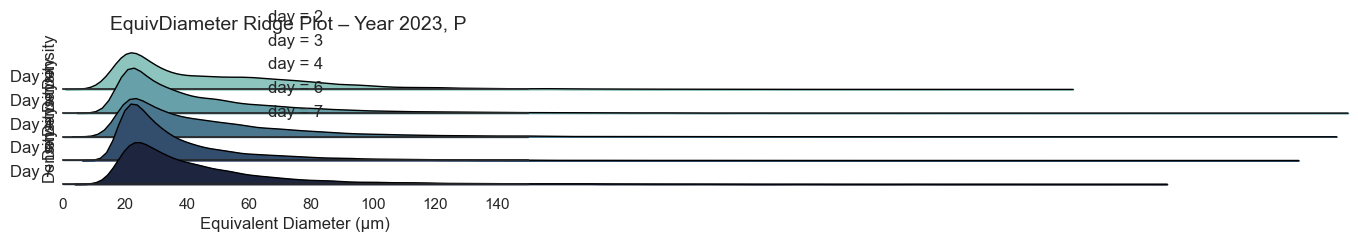

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

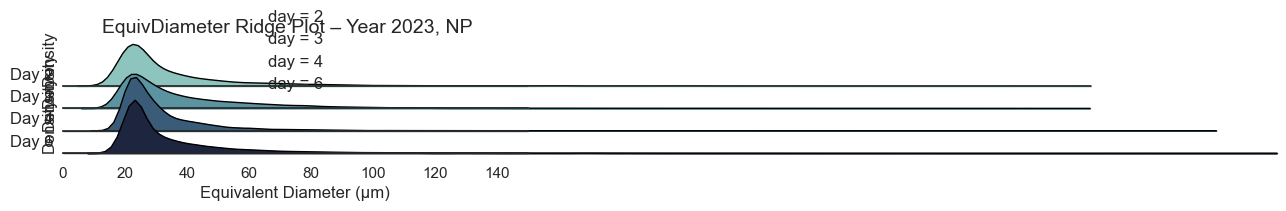

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

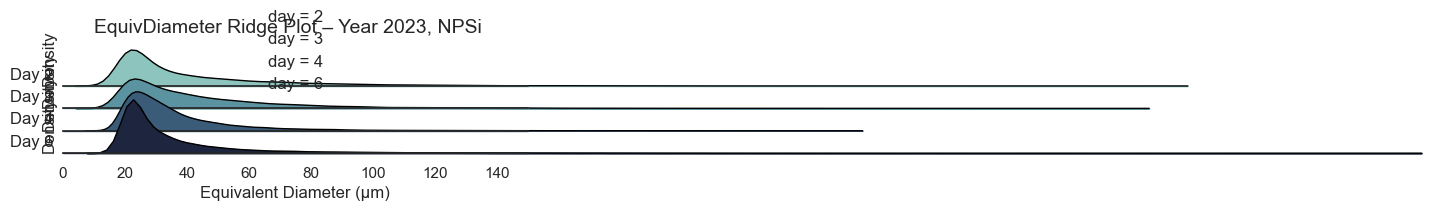

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# Keep only what we need
df = df[['year', 'day', 'treatment', 'EquivDiameter']]
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
year_order = sorted(df['year'].unique())

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

for year in year_order:
    df_year = df[df['year'] == year].copy()
    df_year = df_year[df_year['treatment'].isin(treatment_order)]

    for treatment in treatment_order:
        df_yt = df_year[df_year['treatment'] == treatment].copy()
        if df_yt.empty:
            continue

        # Order days
        df_yt['day'] = df_yt['day'].astype(int)
        day_order = sorted(df_yt['day'].unique())

        # Palette and FacetGrid for ridge-style KDEs
        pal = sns.cubehelix_palette(len(day_order), rot=-0.3, light=0.7)

        g = sns.FacetGrid(
            df_yt,
            row="day",
            hue="day",
            aspect=15,
            height=0.4,
            palette=pal,
            row_order=day_order
        )

        # KDE filled
        g.map(
            sns.kdeplot,
            "EquivDiameter",
            bw_adjust=0.7,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1
        )

        # Outline the KDE
        g.map(
            sns.kdeplot,
            "EquivDiameter",
            bw_adjust=0.7,
            clip_on=False,
            color="black",
            linewidth=1
        )

        # Baseline for each ridge
        g.map(plt.axhline, y=0, linewidth=1, clip_on=False)

        # Set x-limits and remove y-axis
        g.set(xlim=(0, 150))
        g.set(yticks=[])
        g.despine(left=True)

        # Reduce vertical spacing so ridges overlap a bit
        g.fig.subplots_adjust(hspace=-0.6)

        # Label each ridge with its day on the left
        for ax, day in zip(g.axes.flatten(), day_order):
            ax.text(
                -0.02,
                0.2,
                f"Day {day}",
                transform=ax.transAxes,
                ha="right",
                va="center"
            )

        g.fig.suptitle(
            f"EquivDiameter Ridge Plot – Year {year}, {treatment}",
            fontsize=14,
            y=0.95
        )
        g.set_xlabels("Equivalent Diameter (µm)")

        plt.show()
        # Optional save:
        # g.fig.savefig(f"Ridge_EquivDiameter_{year}_{treatment}.tiff",
        #               dpi=600, bbox_inches='tight')

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

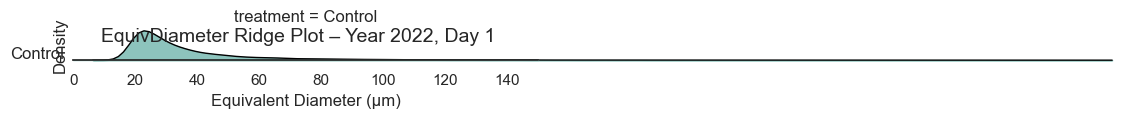

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

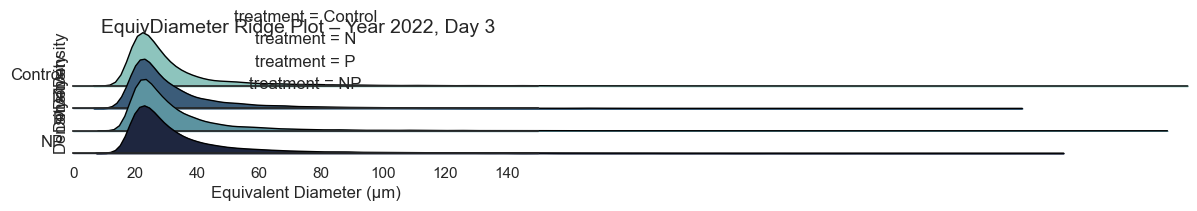

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

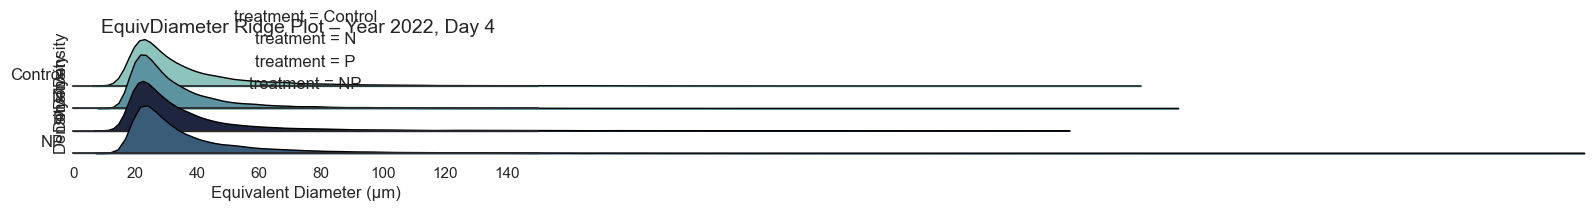

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

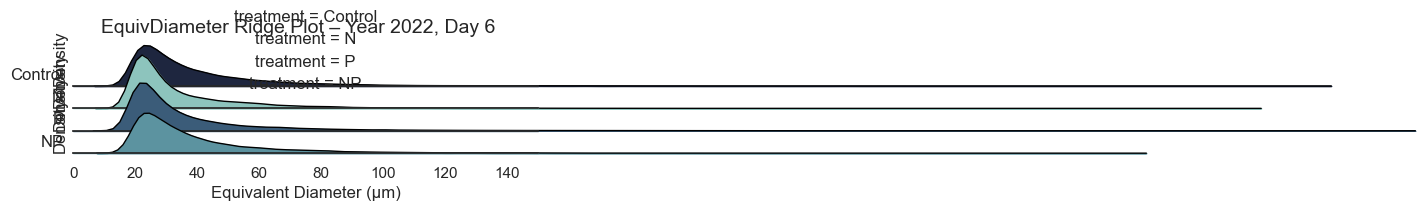

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

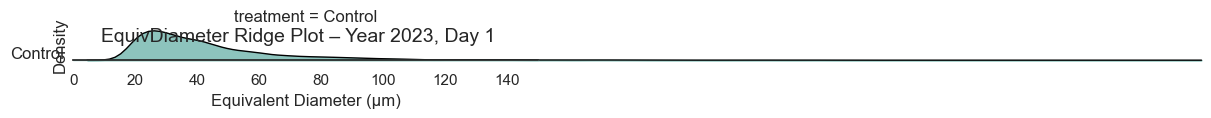

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

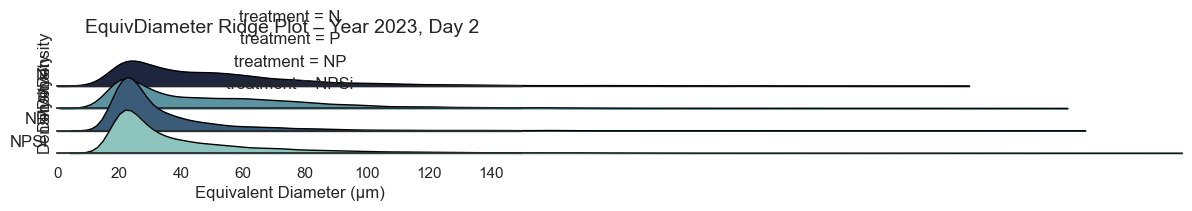

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

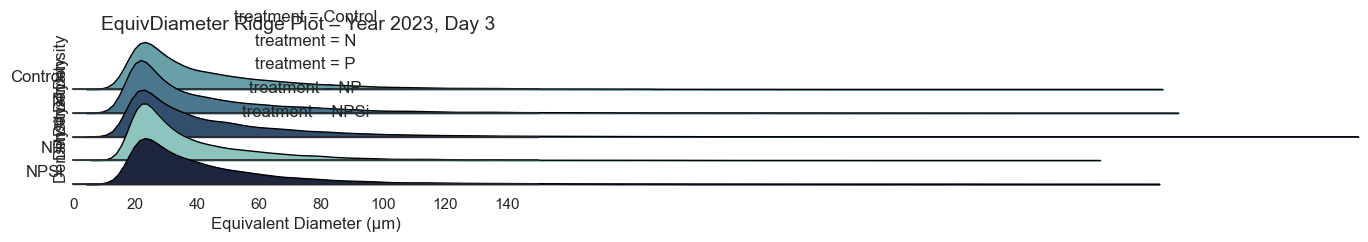

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

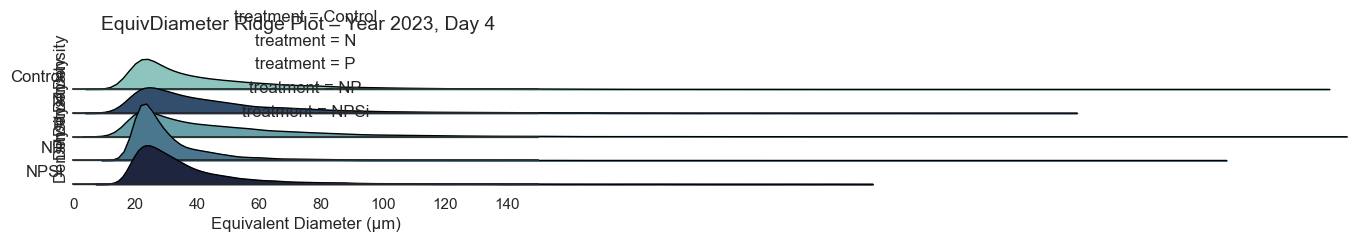

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommo

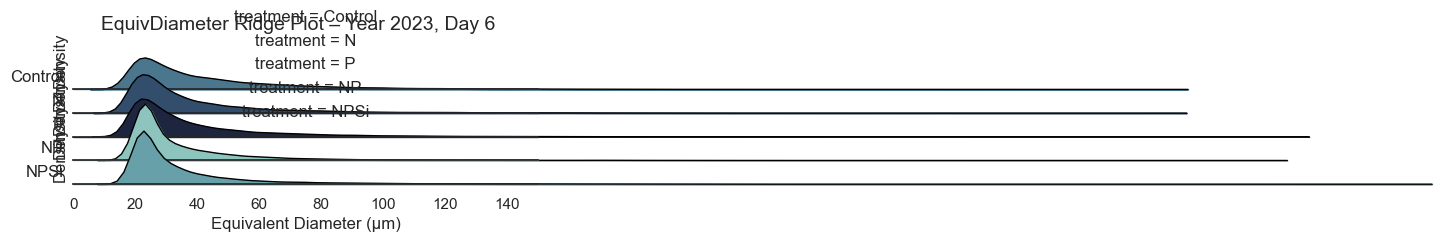

/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/jorge/miniforge3/envs/data_analysis/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

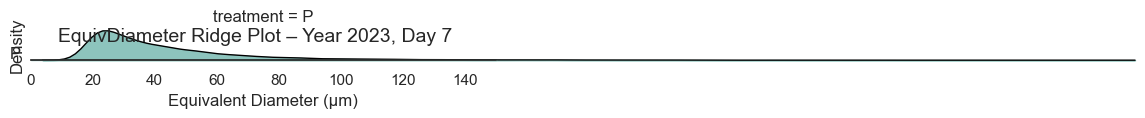

In [28]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# Keep only what we need
df = df[['year', 'day', 'treatment', 'EquivDiameter']]
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
year_order = sorted(df['year'].unique())

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

for year in year_order:
    df_year = df[df['year'] == year].copy()
    # Only keep the treatments of interest
    df_year = df_year[df_year['treatment'].isin(treatment_order)]

    if df_year.empty:
        continue

    day_order = sorted(df_year['day'].unique())

    for day in day_order:
        df_yd = df_year[df_year['day'] == day].copy()
        if df_yd.empty:
            continue

        # Only include treatments that are present for this day, in your preferred order
        present_treatments = [
            tr for tr in treatment_order
            if tr in df_yd['treatment'].unique()
        ]
        if not present_treatments:
            continue

        # Color palette for treatments
        pal = sns.cubehelix_palette(len(present_treatments), rot=-0.3, light=0.7)

        # === Ridge-style FacetGrid: rows = treatments, same day ===
        g = sns.FacetGrid(
            df_yd,
            row="treatment",
            hue="treatment",
            aspect=15,
            height=0.4,
            palette=pal,
            row_order=present_treatments
        )

        # Filled KDE
        g.map(
            sns.kdeplot,
            "EquivDiameter",
            bw_adjust=0.7,
            clip_on=False,
            fill=True,
            alpha=1,
            linewidth=1
        )

        # Outline
        g.map(
            sns.kdeplot,
            "EquivDiameter",
            bw_adjust=0.7,
            clip_on=False,
            color="black",
            linewidth=1
        )

        # Baseline for each ridge
        g.map(plt.axhline, y=0, linewidth=1, clip_on=False)

        # Axis formatting
        g.set(xlim=(0, 150))
        g.set(yticks=[])
        g.despine(left=True)

        # Overlap ridges a bit
        g.fig.subplots_adjust(hspace=-0.6)

        # Label each ridge with treatment name on the left
        for ax, tr in zip(g.axes.flatten(), present_treatments):
            ax.text(
                -0.02,
                0.2,
                tr,
                transform=ax.transAxes,
                ha="right",
                va="center"
            )

        # Titles and labels
        g.fig.suptitle(
            f"EquivDiameter Ridge Plot – Year {year}, Day {day}",
            fontsize=14,
            y=0.95
        )
        g.set_xlabels("Equivalent Diameter (µm)")

        plt.show()
        # Optional save:
        # g.fig.savefig(
        #     f"Ridge_EquivDiameter_year{year}_day{day}.tiff",
        #     dpi=600,
        #     bbox_inches='tight'
        # )

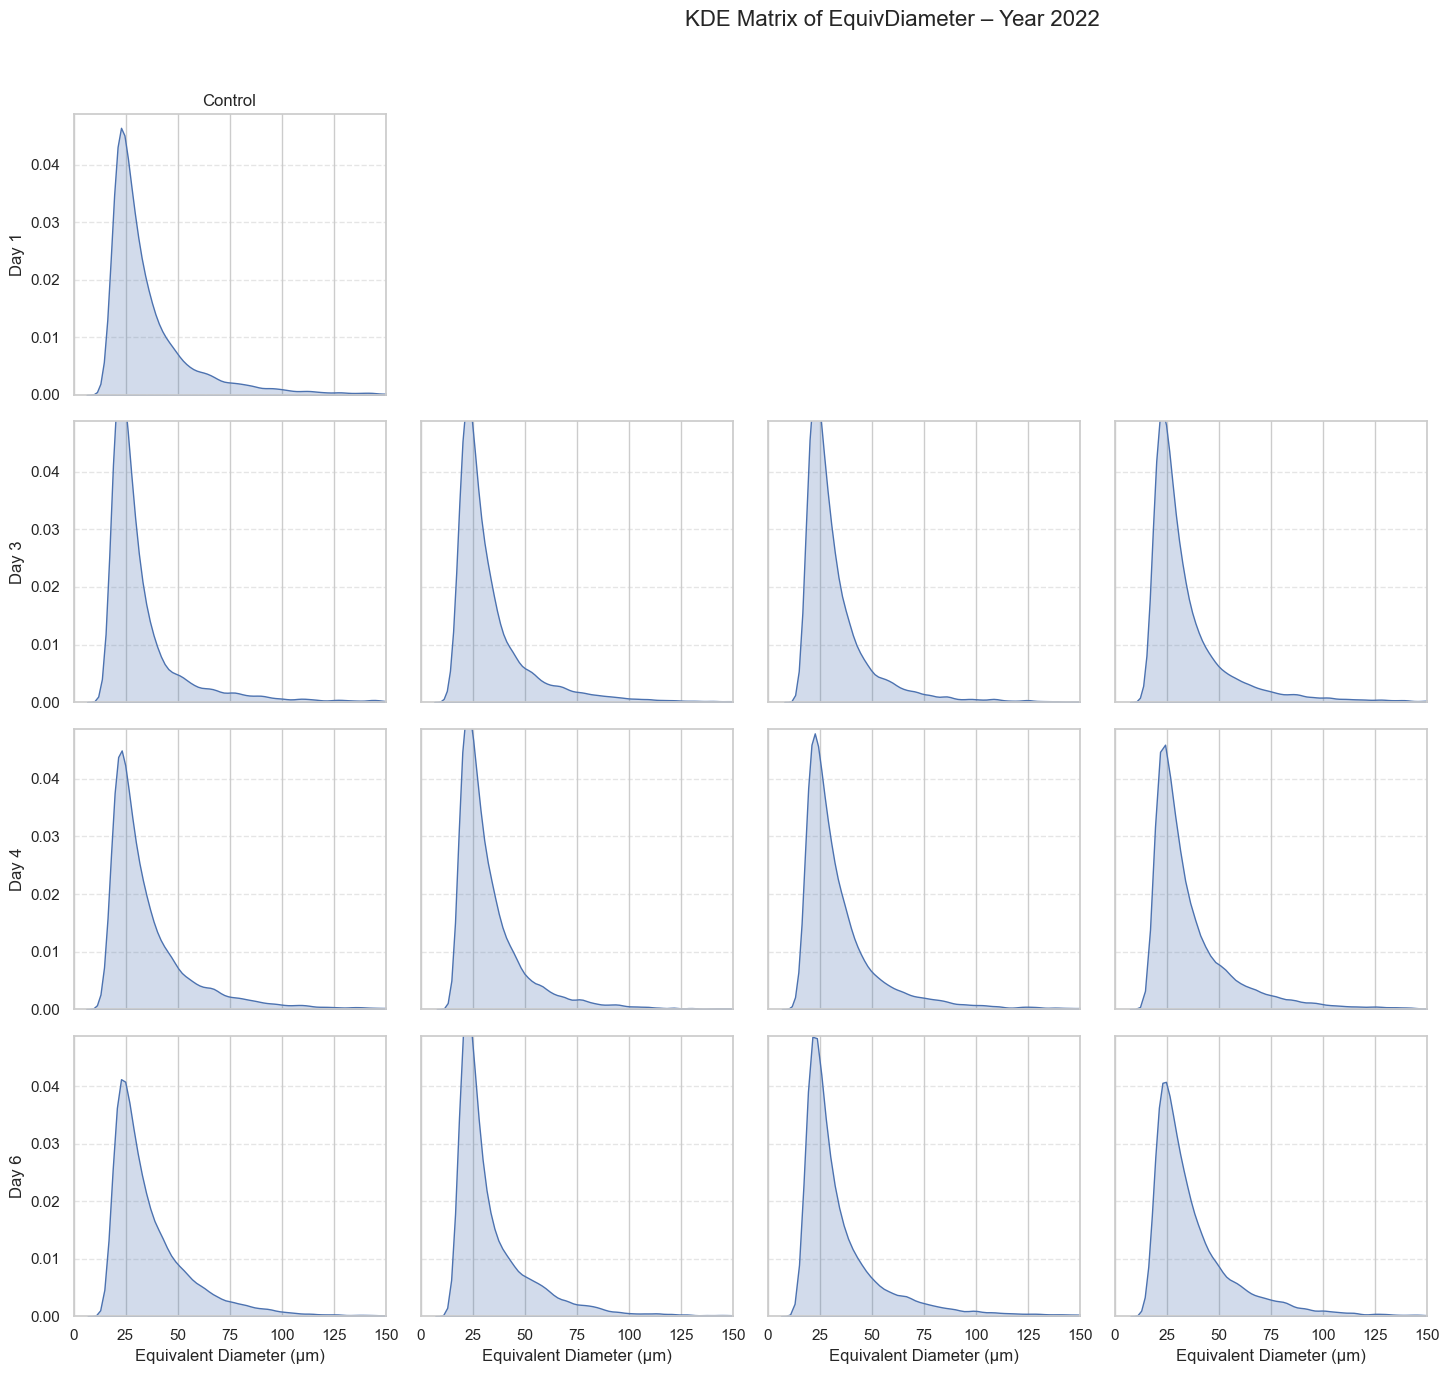

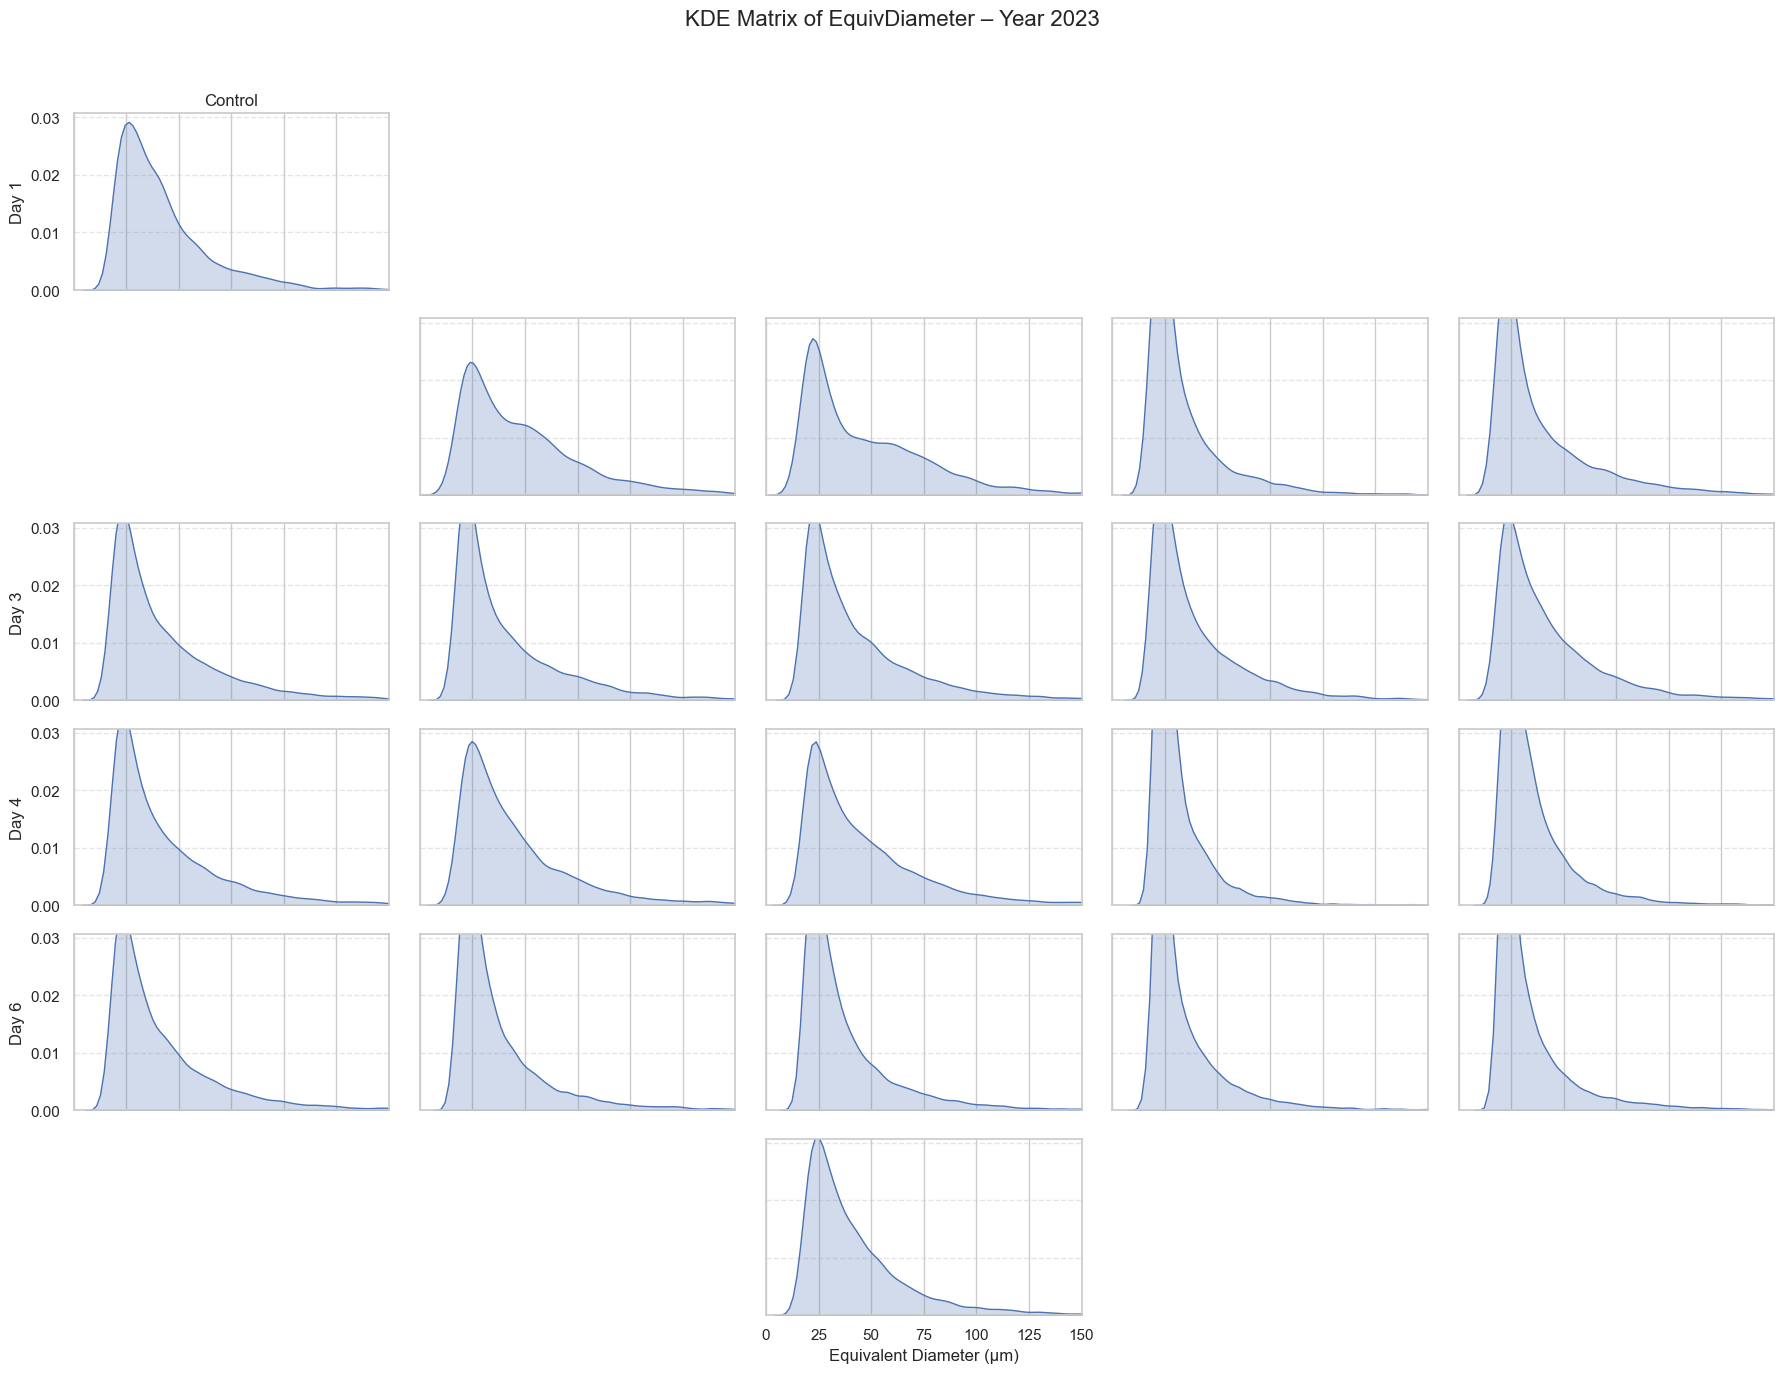

In [29]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

df = df[['year', 'day', 'treatment', 'EquivDiameter']]
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
year_order = sorted(df['year'].unique())

sns.set(style="whitegrid")

for year in year_order:
    df_year = df[df['year'] == year].copy()
    df_year = df_year[df_year['treatment'].isin(treatment_order)]
    if df_year.empty:
        continue

    day_order = sorted(df_year['day'].unique())

    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True,
        sharey=True
    )

    # Handle case of single row/col
    if len(day_order) == 1:
        axes = np.array([axes])
    if len(treatment_order) == 1:
        axes = axes.reshape(len(day_order), 1)

    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]

            subset = df_year[
                (df_year['day'] == day) &
                (df_year['treatment'] == treatment)
            ]

            if subset.empty:
                ax.set_visible(False)
                continue

            sns.kdeplot(
                data=subset,
                x="EquivDiameter",
                bw_adjust=0.7,
                fill=True,
                ax=ax
            )

            ax.set_xlim(0, 150)
            ax.set_ylim(bottom=0)

            if i == len(day_order) - 1:
                ax.set_xlabel("Equivalent Diameter (µm)")
            else:
                ax.set_xlabel("")

            if j == 0:
                ax.set_ylabel(f"Day {day}")
            else:
                ax.set_ylabel("")

            if i == 0:
                ax.set_title(treatment)

            ax.grid(axis='y', linestyle='--', alpha=0.5)

    fig.suptitle(
        f"KDE Matrix of EquivDiameter – Year {year}",
        fontsize=16
    )
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()
    # Optional save:
    # fig.savefig(f"EquivDiameter_KDE_matrix_{year}.tiff",
    #             dpi=600, bbox_inches='tight')

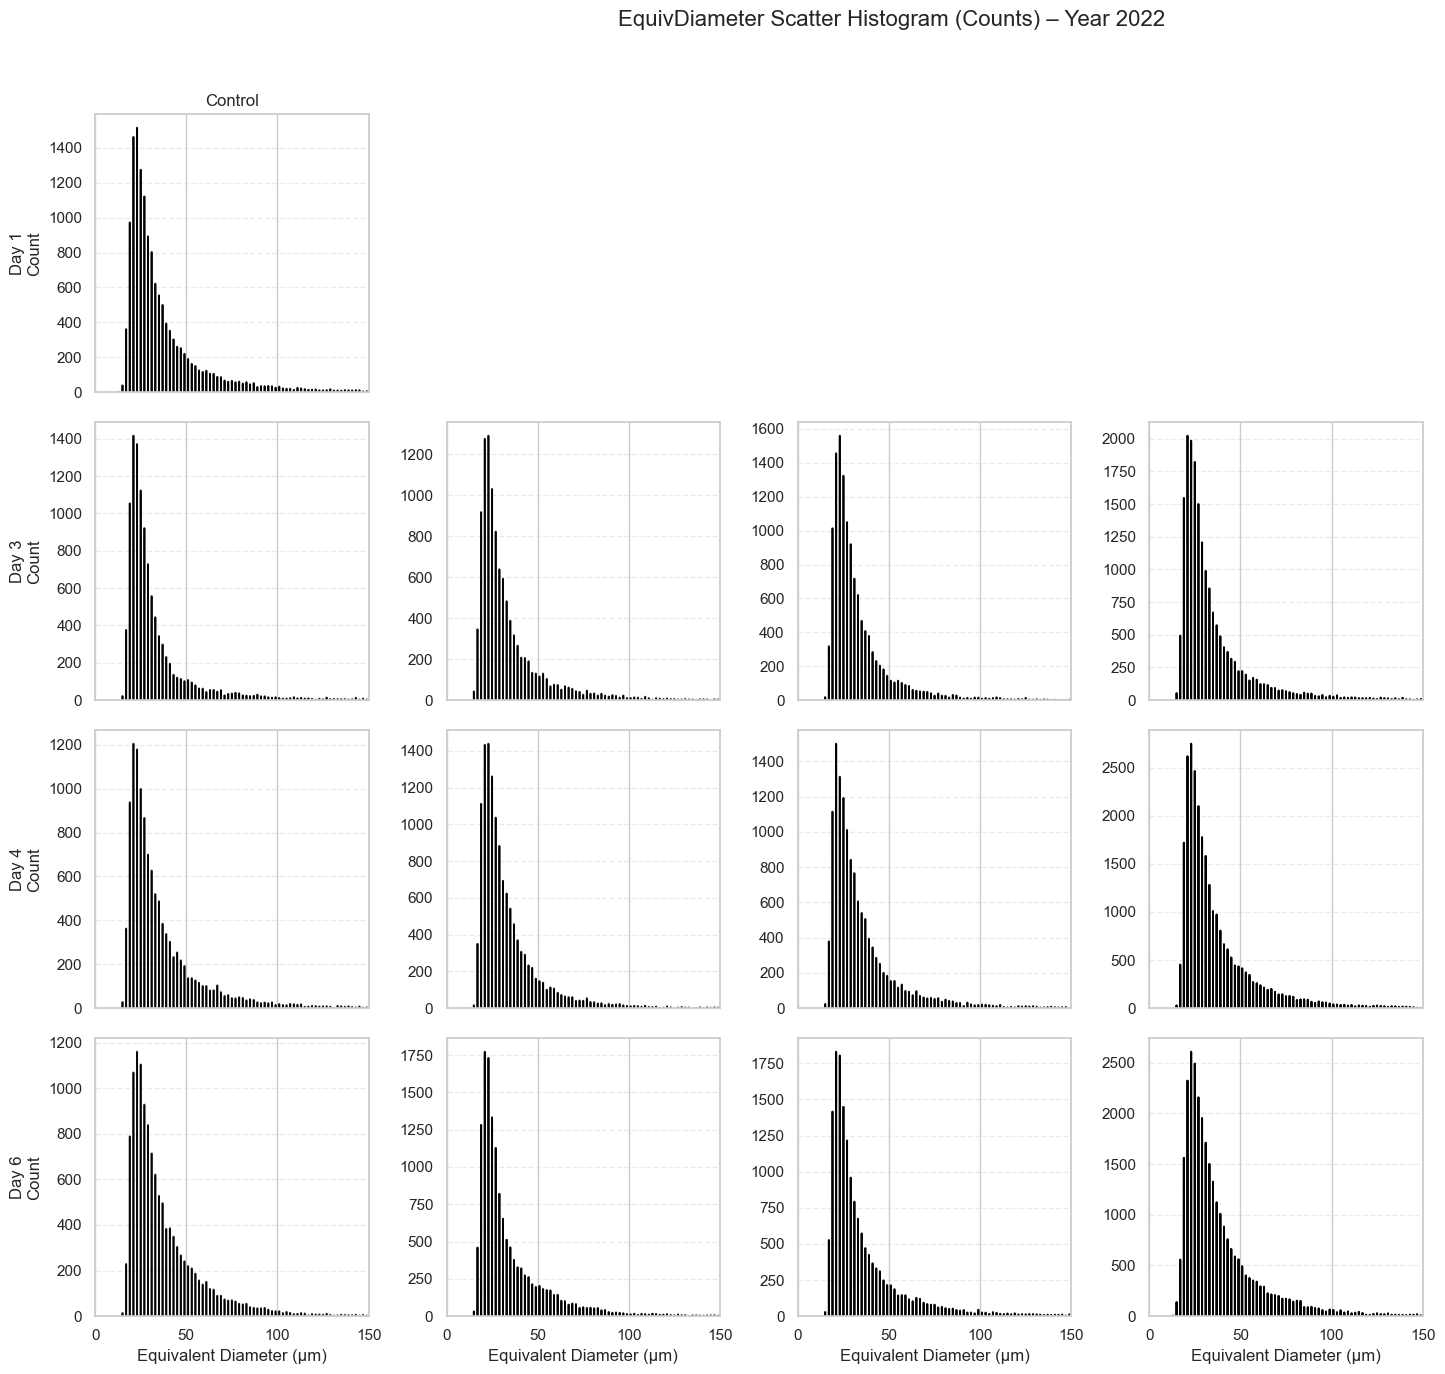

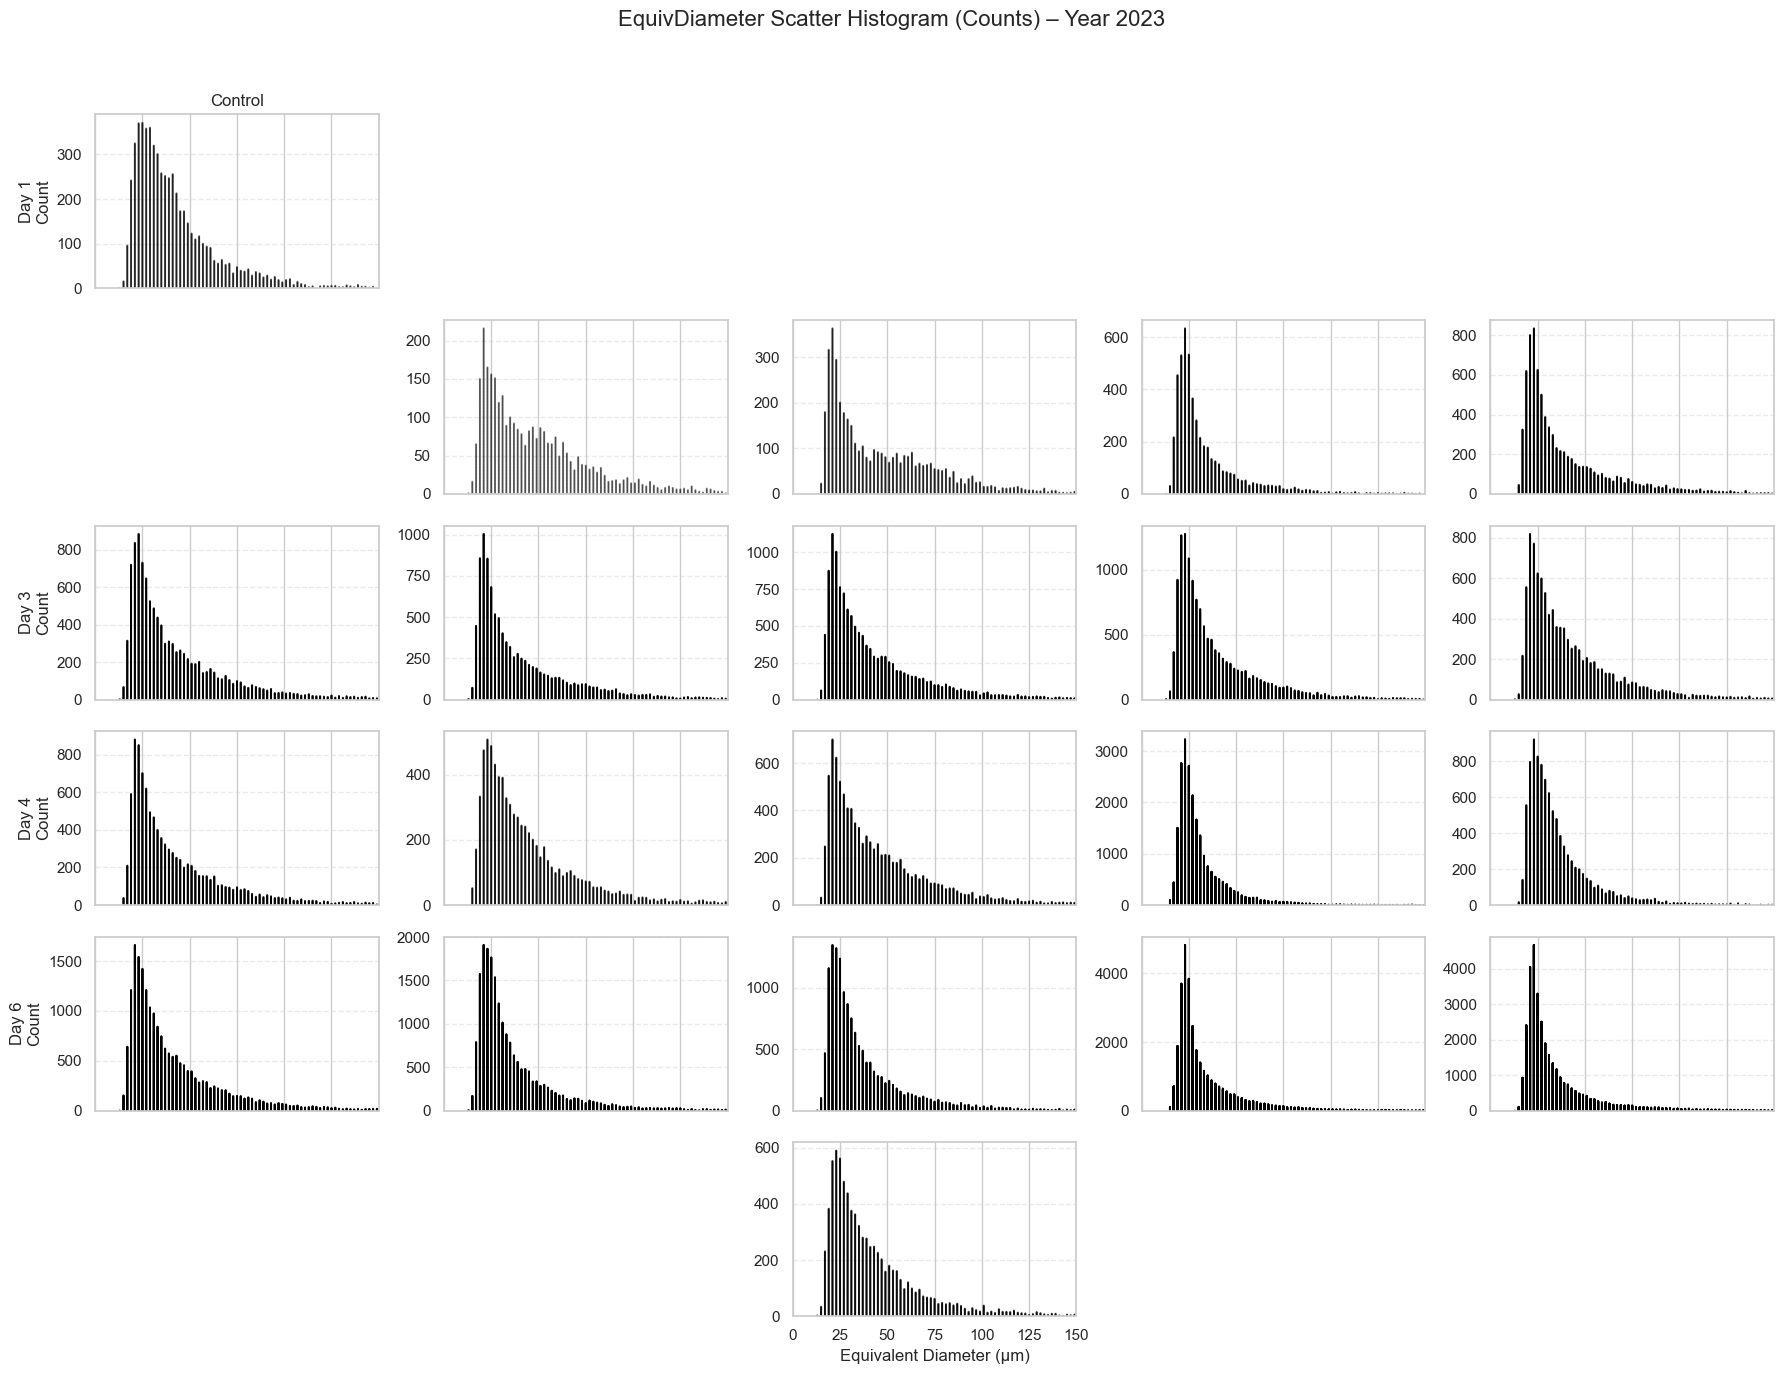

In [30]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# === Load Step 4 particle-level data ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Keep necessary columns ===
df = df[['year', 'day', 'treatment', 'EquivDiameter']]
df = df[(df['EquivDiameter'] > 0) & (df['EquivDiameter'] < 500)]

# === Settings ===
treatment_order = ['Control', 'N', 'P', 'NP', 'NPSi']
year_order = sorted(df['year'].unique())

# Bin settings for 0–150 µm
bin_width = 2          # resolution in µm
bins = np.arange(0, 150 + bin_width, bin_width)

sns.set(style="whitegrid")

for year in year_order:
    df_year = df[df['year'] == year]
    df_year = df_year[df_year['treatment'].isin(treatment_order)]

    if df_year.empty:
        continue

    day_order = sorted(df_year['day'].unique())

    fig, axes = plt.subplots(
        len(day_order),
        len(treatment_order),
        figsize=(18, 14),
        sharex=True
    )

    # Ensure 2D array format even if single row/column
    if len(day_order) == 1:
        axes = np.array([axes])
    if len(treatment_order) == 1:
        axes = axes.reshape(len(day_order), 1)

    for i, day in enumerate(day_order):
        for j, treatment in enumerate(treatment_order):
            ax = axes[i, j]

            subset = df_year[(df_year['day'] == day) &
                             (df_year['treatment'] == treatment)]

            if subset.empty:
                ax.set_visible(False)
                continue

            # === Convert to histogram bins ===
            counts, edges = np.histogram(subset['EquivDiameter'], bins=bins)

            # X = bin centers
            bin_centers = (edges[:-1] + edges[1:]) / 2

            # === Scatter histogram ===
            # For each bin, stack “count” points vertically
            scatter_x = []
            scatter_y = []

            for x, c in zip(bin_centers, counts):
                scatter_x.extend([x] * c)
                scatter_y.extend(range(1, c + 1))

            ax.scatter(
                scatter_x,
                scatter_y,
                s=2,
                alpha=0.4,
                color="black",
                edgecolors="none"
            )

            # === Limits ===
            ax.set_xlim(0, 150)
            ax.set_ylim(0, max(scatter_y) * 1.05 if scatter_y else 1)

            # === Labels ===
            if i == len(day_order) - 1:
                ax.set_xlabel("Equivalent Diameter (µm)")
            else:
                ax.set_xlabel("")

            if j == 0:
                ax.set_ylabel(f"Day {day}\nCount")
            else:
                ax.set_ylabel("")

            if i == 0:
                ax.set_title(treatment)

            ax.grid(axis='y', linestyle='--', alpha=0.4)

    fig.suptitle(
        f"EquivDiameter Scatter Histogram (Counts) – Year {year}",
        fontsize=16
    )
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()
    # Optional save:
    # fig.savefig(f"EquivDiameter_scatterCounts_{year}.tiff",
    #             dpi=600, bbox_inches='tight')

# Tables

In [31]:
import sqlite3
import pandas as pd
import numpy as np
import os

# === Paths ===
input_db = "03_datasets/Ishigaki2023/4_carbon_biomass.db"
output_dir = "03_datasets/Ishigaki2023/morphometry"
os.makedirs(output_dir, exist_ok=True)

# === Load dataset ===
conn = sqlite3.connect(input_db)
df = pd.read_sql("SELECT * FROM ifcb_biomass_per_particle", conn)
conn.close()

# === Select necessary columns ===
# Added organism_type, feeding_mode, toxins so we can group on them too
cols_to_keep = [
    'class_name', 'phylum', 'class', 'order', 'family', 'genus', 'taxon_name', 'category',
    'organism_type', 'feeding_mode', 'toxins',
    'Area', 'Biovolume', 'MajorAxisLength', 'MinorAxisLength',
    'probability', 'volume_um3', 'carbon_pgC'
]
df = df[cols_to_keep].copy()

# === Create carbon_ugC ===
df['carbon_ugC'] = df['carbon_pgC'] / 1e6

# === Remove rows with missing taxon_name or essential numeric fields ===
df = df.dropna(subset=['taxon_name', 'Area', 'Biovolume', 'volume_um3', 'carbon_pgC'])

# === Pixel to micron conversion factors ===
PIXEL_TO_UM3 = 0.422
PIXEL_TO_UM2 = PIXEL_TO_UM3 ** (2/3)  # ≈ 0.650
PIXEL_TO_UM  = PIXEL_TO_UM3 ** (1/3)  # ≈ 0.812

# === Convert pixel-based measurements to microns ===
df['Area']            = df['Area'] * PIXEL_TO_UM2
df['Biovolume']       = df['Biovolume'] * PIXEL_TO_UM3
df['MajorAxisLength'] = df['MajorAxisLength'] * PIXEL_TO_UM
df['MinorAxisLength'] = df['MinorAxisLength'] * PIXEL_TO_UM

# === Variables to summarize (means, SD, SE) ===
numeric_vars = [
    'Area', 'Biovolume', 'MajorAxisLength', 'MinorAxisLength',
    'probability', 'volume_um3', 'carbon_pgC', 'carbon_ugC'
]

# === Base metadata we may want to carry (when meaningful) ===
# For summaries, we only keep the grouping key(s) plus numeric summaries.
# Keeping unrelated taxonomy columns can mislead (they'll be arbitrary 'first's), so we avoid that.
# We'll use a helper to summarize cleanly.

def summarize(df_in: pd.DataFrame, group_cols, filename_stub: str):
    """
    Group df_in by group_cols and compute mean, SD, and SE for numeric_vars.
    Returns the summary DataFrame and writes a CSV to output_dir.
    """
    # Means
    means = df_in.groupby(group_cols, observed=True)[numeric_vars].mean()

    # SD
    sd = df_in.groupby(group_cols, observed=True)[numeric_vars].std()
    sd = sd.rename(columns={c: f"{c}_StdDev" for c in sd.columns})

    # SE = SD / sqrt(n)
    counts = df_in.groupby(group_cols, observed=True)[numeric_vars].count()
    se = sd.copy()
    for c in numeric_vars:
        # Use the SD we computed; counts[c] aligns by group
        se_col = f"{c}_StdErr"
        # When SD is NaN (n=1), SE naturally becomes NaN, which is fine.
        se[se_col] = sd[f"{c}_StdDev"] / np.sqrt(counts[c])
    se = se[[f"{c}_StdErr" for c in numeric_vars]]  # keep only *_StdErr columns

    # Concatenate results
    out = pd.concat([means, sd, se], axis=1).reset_index()

    # Round numeric columns
    num_cols = out.select_dtypes(include=[np.number]).columns
    out[num_cols] = out[num_cols].round(3)

    # Save
    out_path = os.path.join(output_dir, f"average_morphometry_and_carbon_per_{filename_stub}.csv")
    out.to_csv(out_path, index=False)
    print(f"Summary table by {', '.join(group_cols)} saved to: {out_path}")
    return out

# === Your original summaries ===

# 1) By class_name (keeps class-level identity only)
summary_class = summarize(df, ['class_name'], 'class')

# 2) By category (broad ecological bucket)
summary_category = summarize(df, ['category'], 'category')

# === New summaries you asked for ===

# 3) By phylum
summary_phylum = summarize(df, ['phylum'], 'phylum')

# 4) By organism_type (e.g., M, A, Z, etc., depending on your traits table)
#    If organism_type has NaNs, they will form a "NaN" group. You can drop them if you prefer:
#    df_org = df.dropna(subset=['organism_type'])
summary_organism_type = summarize(df, ['organism_type'], 'organism_type')

# 5) By feeding_mode (e.g., autotrophic, mixotrophic, heterotrophic)
#    Same note on NaNs as above if needed.
summary_feeding_mode = summarize(df, ['feeding_mode'], 'feeding_mode')

Summary table by class_name saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_class.csv
Summary table by category saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_category.csv
Summary table by phylum saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_phylum.csv
Summary table by organism_type saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_organism_type.csv
Summary table by feeding_mode saved to: 03_datasets/Ishigaki2023/morphometry/average_morphometry_and_carbon_per_feeding_mode.csv
